X_encoder shape: torch.Size([32, 23])
X_pm shape: torch.Size([32, 17])
X_pm_steam shape: torch.Size([32, 17])
y shape: torch.Size([32, 2])


/Users/nguyendinhhuy/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/20, Training Loss: 0.8576
Epoch 1/20, Validation Loss: 1.3983
Epoch 2/20, Training Loss: 0.7930
Epoch 2/20, Validation Loss: 1.2783
Epoch 3/20, Training Loss: 0.7609
Epoch 3/20, Validation Loss: 1.3098
Epoch 4/20, Training Loss: 0.7389
Epoch 4/20, Validation Loss: 1.2549
Epoch 5/20, Training Loss: 0.7190
Epoch 5/20, Validation Loss: 1.2777
Epoch 6/20, Training Loss: 0.7009
Epoch 6/20, Validation Loss: 1.2897
Epoch 7/20, Training Loss: 0.6824
Epoch 7/20, Validation Loss: 1.2828
Epoch 8/20, Training Loss: 0.6667
Epoch 8/20, Validation Loss: 1.2140
Epoch 9/20, Training Loss: 0.6499
Epoch 9/20, Validation Loss: 1.2807
Epoch 10/20, Training Loss: 0.6380
Epoch 10/20, Validation Loss: 1.1455
Epoch 11/20, Training Loss: 0.6210
Epoch 11/20, Validation Loss: 1.1629
Epoch 12/20, Training Loss: 0.6061
Epoch 12/20, Validation Loss: 1.2208
Epoch 13/20, Training Loss: 0.5980
Epoch 13/20, Validation Loss: 1.2259
Epoch 14/20, Training Loss: 0.5834
Epoch 14/20, Validation Loss: 1.1646
Epoch 15/2

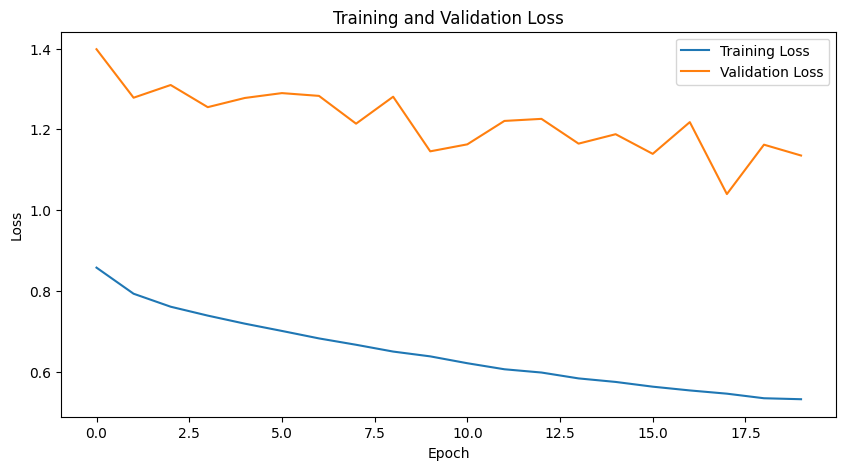

Test Loss: 1.2244
MAPE for PM: 16.21%
MAPE for PM_steam: 25.13%


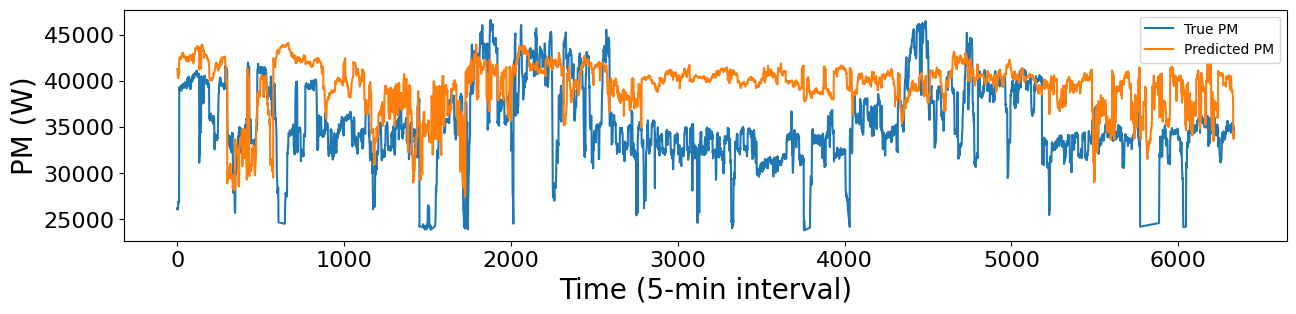

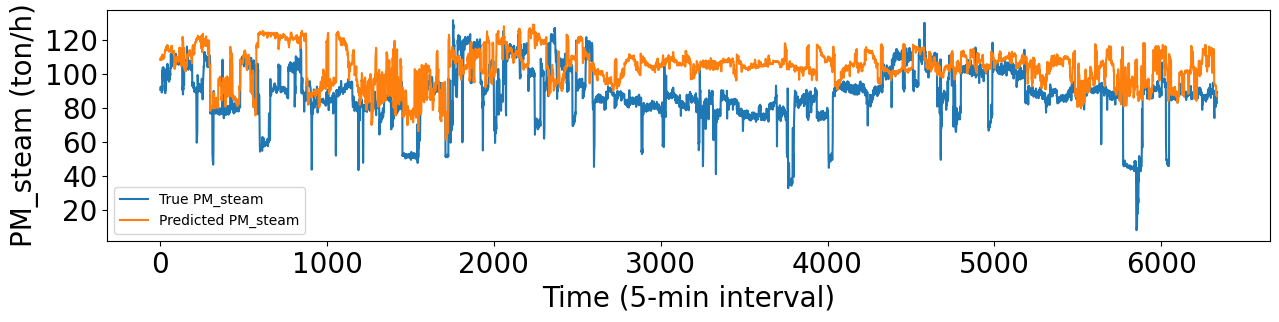

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random

# Đặt seed cho các thư viện khác nhau
random.seed(100)
np.random.seed(100)
torch.manual_seed(100)
torch.cuda.manual_seed(100)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Đọc và chuẩn bị dữ liệu
data = pd.read_csv('/Users/nguyendinhhuy/Desktop/Rolling/fortraining.csv')
data = data.sort_values(by='Time')

# Định nghĩa các đặc trưng
encoder_features = ['PM_lw1','PM_lw2', 'PM_lw3', 'PM_lw4', 'PM_lw5', 'PM_lw6', 'PM_lw7','PM_s1', 'PM_s2', 'PM_s3', 'PM_s4', 'PM_s5', 'PM_s6', 'PM_s7',
                    'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month', 'hour', 'minute'
                    ]
pm_features = ['PM_lw1', 'PM_lw2', 'PM_lw3', 'PM_lw4', 'PM_lw5', 'PM_lw6', 'PM_lw7', 'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month', 'hour', 'minute','PM_s1']
pm_steam_features = ['PM_s1', 'PM_s2', 'PM_s3', 'PM_s4', 'PM_s5', 'PM_s6', 'PM_s7', 'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month', 'hour', 'minute','PM_lw1']
y = data[['PM', 'PM_steam']].values

# Chuẩn hóa dữ liệu
scaler_encoder = StandardScaler()
scaler_pm = StandardScaler()
scaler_pm_steam = StandardScaler()
scaler_y = StandardScaler()  # Thêm scaler cho y

X_encoder = scaler_encoder.fit_transform(data[encoder_features])
X_pm = scaler_pm.fit_transform(data[pm_features])
X_pm_steam = scaler_pm_steam.fit_transform(data[pm_steam_features])
y = scaler_y.fit_transform(y)  # Chuẩn hóa y

# Định nghĩa tổng số mẫu và phần trăm chia
total_samples = len(data)
train_percentage = 0.8
val_percentage = 0.1
test_percentage = 0.1

# Tính kích thước các tập
train_size = int(total_samples * train_percentage)
val_size = int(total_samples * val_percentage)
test_size = total_samples - train_size - val_size

# Điều chỉnh kích thước để chia hết cho 288
train_size -= train_size % 288
val_size -= val_size % 288
test_size -= test_size % 288

# Chuyển đổi sang tensor
X_encoder = torch.tensor(X_encoder, dtype=torch.float32)
X_pm = torch.tensor(X_pm, dtype=torch.float32)
X_pm_steam = torch.tensor(X_pm_steam, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Tạo TensorDataset
train_dataset = TensorDataset(X_encoder[:train_size], X_pm[:train_size], X_pm_steam[:train_size], y[:train_size])
val_dataset = TensorDataset(X_encoder[train_size:train_size + val_size], X_pm[train_size:train_size + val_size], X_pm_steam[train_size:train_size + val_size], y[train_size:train_size + val_size])
test_dataset = TensorDataset(X_encoder[-test_size:], X_pm[-test_size:], X_pm_steam[-test_size:], y[-test_size:])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Kiểm tra kích thước của các tensor
for X_enc, X_pm, X_pm_steam, y in train_loader:
    print(f"X_encoder shape: {X_enc.shape}")
    print(f"X_pm shape: {X_pm.shape}")
    print(f"X_pm_steam shape: {X_pm_steam.shape}")
    print(f"y shape: {y.shape}")
    break  # Chỉ cần in kích thước của batch đầu tiên

# Định nghĩa mô hình với Dropout và Batch Normalization
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, dropout=0.1):
        super(Encoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=8, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.encoder(x)
        return self.norm(x)

class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, dropout=0.2):
        super(Decoder, self).__init__()
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=8, dropout=dropout)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)
        self.output_layer = nn.Linear(d_model, 1)  # Output is a scalar per time step

    def forward(self, memory, x):
        x = self.decoder(x, memory)
        x = self.norm(x)
        x = self.output_layer(x)
        return x

class MultiDeT(nn.Module):
    def __init__(self, encoder_layers=1, decoder_layers=1, d_model=16, dropout=0.2):
        super(MultiDeT, self).__init__()
        self.encoder = Encoder(encoder_layers, d_model=d_model, dropout=dropout)
        self.decoder1 = Decoder(decoder_layers, d_model=d_model, dropout=dropout)
        self.decoder2 = Decoder(decoder_layers, d_model=d_model, dropout=dropout)

        self.encoderLinear = nn.Sequential(
            nn.Linear(len(encoder_features), d_model),
            nn.BatchNorm1d(d_model)  # Thêm BatchNorm1d
        )
        self.decoder1_Linear = nn.Sequential(
            nn.Linear(len(pm_features), d_model),
            nn.BatchNorm1d(d_model)  # Thêm BatchNorm1d
        )
        self.decoder2_Linear = nn.Sequential(
            nn.Linear(len(pm_steam_features), d_model),
            nn.BatchNorm1d(d_model)  # Thêm BatchNorm1d
        )

    def forward(self, src, src_dec1, src_dec2):
        encoder_output = self.encoder(self.encoderLinear(src))

        decoder1_output = self.decoder1(encoder_output, self.decoder1_Linear(src_dec1))
        decoder2_output = self.decoder2(encoder_output, self.decoder2_Linear(src_dec2))

        return decoder1_output, decoder2_output

# Khởi tạo mô hình
model = MultiDeT()

# Định nghĩa hàm loss và optimizer với Weight Decay
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-3)  # Thêm weight_decay

# Hàm huấn luyện mô hình với Early Stopping
def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, patience=10):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_enc, X_pm, X_pm_steam, y in train_loader:
            optimizer.zero_grad()
            output1, output2 = model(X_enc, X_pm, X_pm_steam)

            # Reshape outputs to match the target shape
            output1 = output1.view(-1)
            output2 = output2.view(-1)

            # Calculate loss for each output
            loss1 = criterion(output1, y[:, 0])
            loss2 = criterion(output2, y[:, 1])

            # Combine the losses
            loss = 0.8 * loss1 + 0.2 * loss2
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_enc.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_enc, X_pm, X_pm_steam, y in val_loader:
                output1, output2 = model(X_enc, X_pm, X_pm_steam)

                # Reshape outputs to match the target shape
                output1 = output1.view(-1)
                output2 = output2.view(-1)

                # Calculate loss for each output
                loss1 = criterion(output1, y[:, 0])
                loss2 = criterion(output2, y[:, 1])

                # Combine the losses
                loss = 0.8 * loss1 + 0.2 * loss2
                val_loss += loss.item() * X_enc.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}')

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # reset patience counter
            best_model_wts = model.state_dict()  # save the best model
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            model.load_state_dict(best_model_wts)  # load the best model weights
            break

    return train_losses, val_losses

# Huấn luyện mô hình với Early Stopping
train_losses, val_losses = train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, patience=10)

# Vẽ biểu đồ loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

import numpy as np
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader, criterion, scaler_y):
    model.eval()
    test_loss = 0.0
    true_values_pm = []
    true_values_pm_steam = []
    predicted_values_pm = []
    predicted_values_pm_steam = []

    with torch.no_grad():
        for X_enc, X_pm, X_pm_steam, y in test_loader:
            output1, output2 = model(X_enc, X_pm, X_pm_steam)

            # Reshape outputs to match the target shape
            output1 = output1.view(-1)
            output2 = output2.view(-1)

            # Calculate loss for each output
            loss1 = criterion(output1, y[:, 0])
            loss2 = criterion(output2, y[:, 1])
            loss = 0.8 * loss1 + 0.2 * loss2  # Sử dụng cùng trọng số như trong quá trình huấn luyện
            test_loss += loss.item() * X_enc.size(0)

            true_values_pm.extend(y[:, 0].cpu().numpy())
            true_values_pm_steam.extend(y[:, 1].cpu().numpy())
            predicted_values_pm.extend(output1.cpu().numpy())
            predicted_values_pm_steam.extend(output2.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')

    # Convert lists to numpy arrays
    true_values_pm = np.array(true_values_pm)
    true_values_pm_steam = np.array(true_values_pm_steam)
    predicted_values_pm = np.array(predicted_values_pm)
    predicted_values_pm_steam = np.array(predicted_values_pm_steam)

    # Inverse transform the predictions and true values to their original scale
    true_values = scaler_y.inverse_transform(np.vstack((true_values_pm, true_values_pm_steam)).T)
    predicted_values = scaler_y.inverse_transform(np.vstack((predicted_values_pm, predicted_values_pm_steam)).T)

    true_values_pm = true_values[:, 0]
    true_values_pm_steam = true_values[:, 1]
    predicted_values_pm = predicted_values[:, 0]
    predicted_values_pm_steam = predicted_values[:, 1]

    # Calculate Mean Absolute Percentage Error (MAPE)
    mape_pm = np.mean(np.abs((true_values_pm - predicted_values_pm) / true_values_pm)) * 100
    mape_pm_steam = np.mean(np.abs((true_values_pm_steam - predicted_values_pm_steam) / true_values_pm_steam)) * 100

    print(f'MAPE for PM: {mape_pm:.2f}%')
    print(f'MAPE for PM_steam: {mape_pm_steam:.2f}%')

    return true_values_pm, true_values_pm_steam, predicted_values_pm, predicted_values_pm_steam, mape_pm, mape_pm_steam

# Đánh giá mô hình và lưu lại các giá trị dự báo và giá trị thực
true_values_pm, true_values_pm_steam, predicted_values_pm, predicted_values_pm_steam, mape_pm, mape_pm_steam = evaluate_model(model, test_loader, criterion, scaler_y)

# Vẽ biểu đồ dự báo và giá trị thực cho PM
plt.figure(figsize=(15, 3))
plt.plot(true_values_pm, label='True PM')
plt.plot(predicted_values_pm, label='Predicted PM')
plt.yticks( fontsize=16)  # Increased y-tick label font size
plt.xticks(fontsize=16)  # Increased x-tick label font size
plt.xlabel('Time (5-min interval)',fontsize=20)
plt.ylabel('PM (W)',fontsize=20)
plt.legend()
# plt.title('True vs Predicted PM')
plt.show()

# Vẽ biểu đồ dự báo và giá trị thực cho PM_steam
plt.figure(figsize=(15, 3))
plt.plot(true_values_pm_steam, label='True PM_steam')
plt.plot(predicted_values_pm_steam, label='Predicted PM_steam')
plt.yticks( fontsize=20)  # Increased y-tick label font size
plt.xticks(fontsize=20)  # Increased x-tick label font size
plt.xlabel('Time (5-min interval)',fontsize=20)
plt.ylabel('PM_steam (ton/h)',fontsize=20)
plt.legend()
# plt.title('True vs Predicted PM_steam')
plt.show()

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random
from statsmodels.tsa.arima.model import ARIMA

# Đặt seed cho các thư viện khác nhau
random.seed(100)
np.random.seed(100)
torch.manual_seed(100)
torch.cuda.manual_seed(100)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Đọc và chuẩn bị dữ liệu
data = pd.read_csv('/Users/nguyendinhhuy/Desktop/Rolling/fortraining.csv')
data = data.sort_values(by='Time')

# Định nghĩa các đặc trưng
encoder_features = ['PM_lw1','PM_lw2', 'PM_lw3', 'PM_lw4', 'PM_lw5', 'PM_lw6', 'PM_lw7','PM_s1', 'PM_s2', 'PM_s3', 'PM_s4', 'PM_s5', 'PM_s6', 'PM_s7',
                    'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month', 'hour', 'minute'
                    ]
pm_features = ['PM_lw1', 'PM_lw2', 'PM_lw3', 'PM_lw4', 'PM_lw5', 'PM_lw6', 'PM_lw7', 'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month', 'hour', 'minute','PM_s1']
pm_steam_features = ['PM_s1', 'PM_s2', 'PM_s3', 'PM_s4', 'PM_s5', 'PM_s6', 'PM_s7', 'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month', 'hour', 'minute','PM_lw1']
y = data[['PM', 'PM_steam']].values

# Chuẩn hóa dữ liệu
scaler_encoder = StandardScaler()
scaler_pm = StandardScaler()
scaler_pm_steam = StandardScaler()
scaler_y = StandardScaler()  # Thêm scaler cho y

X_encoder = scaler_encoder.fit_transform(data[encoder_features])
X_pm = scaler_pm.fit_transform(data[pm_features])
X_pm_steam = scaler_pm_steam.fit_transform(data[pm_steam_features])
y = scaler_y.fit_transform(y)  # Chuẩn hóa y

# Định nghĩa tổng số mẫu và phần trăm chia
total_samples = len(data)
train_percentage = 0.8
val_percentage = 0.1
test_percentage = 0.1

# Tính kích thước các tập
train_size = int(total_samples * train_percentage)
val_size = int(total_samples * val_percentage)
test_size = total_samples - train_size - val_size

# Điều chỉnh kích thước để chia hết cho 288
train_size -= train_size % 288
val_size -= val_size % 288
test_size -= test_size % 288

# Chuyển đổi sang tensor
X_encoder = torch.tensor(X_encoder, dtype=torch.float32)
X_pm = torch.tensor(X_pm, dtype=torch.float32)
X_pm_steam = torch.tensor(X_pm_steam, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Tạo TensorDataset
train_dataset = TensorDataset(X_encoder[:train_size], X_pm[:train_size], X_pm_steam[:train_size], y[:train_size])
val_dataset = TensorDataset(X_encoder[train_size:train_size + val_size], X_pm[train_size:train_size + val_size], X_pm_steam[train_size:train_size + val_size], y[train_size:train_size + val_size])
test_dataset = TensorDataset(X_encoder[-test_size:], X_pm[-test_size:], X_pm_steam[-test_size:], y[-test_size:])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Định nghĩa mô hình với Dropout và Batch Normalization
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, dropout=0.1):
        super(Encoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=8, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.encoder(x)
        return self.norm(x)

class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, dropout=0.2):
        super(Decoder, self).__init__()
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=8, dropout=dropout)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)
        self.output_layer = nn.Linear(d_model, 1)  # Output is a scalar per time step

    def forward(self, memory, x):
        x = self.decoder(x, memory)
        x = self.norm(x)
        x = self.output_layer(x)
        return x

class MultiDeT(nn.Module):
    def __init__(self, encoder_layers=1, decoder_layers=1, d_model=16, dropout=0.2):
        super(MultiDeT, self).__init__()
        self.encoder = Encoder(encoder_layers, d_model=d_model, dropout=dropout)
        self.decoder1 = Decoder(decoder_layers, d_model=d_model, dropout=dropout)
        self.decoder2 = Decoder(decoder_layers, d_model=d_model, dropout=dropout)

        self.encoderLinear = nn.Sequential(
            nn.Linear(len(encoder_features), d_model),
            nn.BatchNorm1d(d_model)  # Thêm BatchNorm1d
        )
        self.decoder1_Linear = nn.Sequential(
            nn.Linear(len(pm_features), d_model),
            nn.BatchNorm1d(d_model)  # Thêm BatchNorm1d
        )
        self.decoder2_Linear = nn.Sequential(
            nn.Linear(len(pm_steam_features), d_model),
            nn.BatchNorm1d(d_model)  # Thêm BatchNorm1d
        )

    def forward(self, src, src_dec1, src_dec2):
        encoder_output = self.encoder(self.encoderLinear(src))

        decoder1_output = self.decoder1(encoder_output, self.decoder1_Linear(src_dec1))
        decoder2_output = self.decoder2(encoder_output, self.decoder2_Linear(src_dec2))

        return decoder1_output, decoder2_output

# Khởi tạo mô hình
model = MultiDeT()

# Định nghĩa hàm loss và optimizer với Weight Decay
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-3)  # Thêm weight_decay

# Hàm huấn luyện mô hình với Early Stopping
def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, patience=10):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_enc, X_pm, X_pm_steam, y in train_loader:
            optimizer.zero_grad()
            output1, output2 = model(X_enc, X_pm, X_pm_steam)

            # Reshape outputs to match the target shape
            output1 = output1.view(-1)
            output2 = output2.view(-1)

            # Calculate loss for each output
            loss1 = criterion(output1, y[:, 0])
            loss2 = criterion(output2, y[:, 1])

            # Combine the losses
            loss = 0.8 * loss1 + 0.2 * loss2
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_enc.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_enc, X_pm, X_pm_steam, y in val_loader:
                output1, output2 = model(X_enc, X_pm, X_pm_steam)

                # Reshape outputs to match the target shape
                output1 = output1.view(-1)
                output2 = output2.view(-1)

                # Calculate loss for each output
                loss1 = criterion(output1, y[:, 0])
                loss2 = criterion(output2, y[:, 1])

                # Combine the losses
                loss = 0.8 * loss1 + 0.2 * loss2
                val_loss += loss.item() * X_enc.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}')

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # reset patience counter
            best_model_wts = model.state_dict()  # save the best model
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            model.load_state_dict(best_model_wts)  # load the best model weights
            break

    return train_losses, val_losses

# Huấn luyện mô hình với Early Stopping
train_losses, val_losses = train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, patience=10)

# Vẽ biểu đồ loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

def evaluate_model(model, test_loader, criterion, scaler_y):
    model.eval()
    test_loss = 0.0
    true_values_pm = []
    true_values_pm_steam = []
    predicted_values_pm = []
    predicted_values_pm_steam = []

    with torch.no_grad():
        for X_enc, X_pm, X_pm_steam, y in test_loader:
            output1, output2 = model(X_enc, X_pm, X_pm_steam)

            # Reshape outputs to match the target shape
            output1 = output1.view(-1)
            output2 = output2.view(-1)

            # Calculate loss for each output
            loss1 = criterion(output1, y[:, 0])
            loss2 = criterion(output2, y[:, 1])
            loss = 0.8 * loss1 + 0.2 * loss2  # Sử dụng cùng trọng số như trong quá trình huấn luyện
            test_loss += loss.item() * X_enc.size(0)

            true_values_pm.extend(y[:, 0].cpu().numpy())
            true_values_pm_steam.extend(y[:, 1].cpu().numpy())
            predicted_values_pm.extend(output1.cpu().numpy())
            predicted_values_pm_steam.extend(output2.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')

    # Convert lists to numpy arrays
    true_values_pm = np.array(true_values_pm)
    true_values_pm_steam = np.array(true_values_pm_steam)
    predicted_values_pm = np.array(predicted_values_pm)
    predicted_values_pm_steam = np.array(predicted_values_pm_steam)

    # Inverse transform the predictions and true values to their original scale
    true_values = scaler_y.inverse_transform(np.vstack((true_values_pm, true_values_pm_steam)).T)
    predicted_values = scaler_y.inverse_transform(np.vstack((predicted_values_pm, predicted_values_pm_steam)).T)

    true_values_pm = true_values[:, 0]
    true_values_pm_steam = true_values[:, 1]
    predicted_values_pm = predicted_values[:, 0]
    predicted_values_pm_steam = predicted_values[:, 1]

    # Calculate Mean Absolute Percentage Error (MAPE)
    mape_pm = np.mean(np.abs((true_values_pm - predicted_values_pm) / true_values_pm)) * 100
    mape_pm_steam = np.mean(np.abs((true_values_pm_steam - predicted_values_pm_steam) / true_values_pm_steam)) * 100

    print(f'MAPE for PM: {mape_pm:.2f}%')
    print(f'MAPE for PM_steam: {mape_pm_steam:.2f}%')

    return true_values_pm, true_values_pm_steam, predicted_values_pm, predicted_values_pm_steam, mape_pm, mape_pm_steam

# Đánh giá mô hình và lưu lại các giá trị dự báo và giá trị thực
true_values_pm, true_values_pm_steam, predicted_values_pm, predicted_values_pm_steam, mape_pm, mape_pm_steam = evaluate_model(model, test_loader, criterion, scaler_y)

# Vẽ biểu đồ dự báo và giá trị thực cho PM
plt.figure(figsize=(15, 3))
plt.plot(true_values_pm, label='True PM')
plt.plot(predicted_values_pm, label='Predicted PM')
plt.yticks( fontsize=16)  # Increased y-tick label font size
plt.xticks(fontsize=16)  # Increased x-tick label font size
plt.xlabel('Time (5-min interval)',fontsize=20)
plt.ylabel('PM (W)',fontsize=20)
plt.legend()
# plt.title('True vs Predicted PM')
plt.show()

# Vẽ biểu đồ dự báo và giá trị thực cho PM_steam
plt.figure(figsize=(15, 3))
plt.plot(true_values_pm_steam, label='True PM_steam')
plt.plot(predicted_values_pm_steam, label='Predicted PM_steam')
plt.yticks( fontsize=20)  # Increased y-tick label font size
plt.xticks(fontsize=20)  # Increased x-tick label font size
plt.xlabel('Time (5-min interval)',fontsize=20)
plt.ylabel('PM_steam (ton/h)',fontsize=20)
plt.legend()
# plt.title('True vs Predicted PM_steam')
plt.show()

# Calculate residuals
residuals_pm = true_values_pm - predicted_values_pm
residuals_pm_steam = true_values_pm_steam - predicted_values_pm_steam

# Fit ARIMA model to residuals
arima_order = (5, 1, 0)  # Example order, you may need to tune this
arima_model_pm = ARIMA(residuals_pm, order=arima_order).fit()
arima_model_pm_steam = ARIMA(residuals_pm_steam, order=arima_order).fit()

# Forecast residuals using ARIMA
arima_forecast_pm = arima_model_pm.forecast(steps=len(residuals_pm))
arima_forecast_pm_steam = arima_model_pm_steam.forecast(steps=len(residuals_pm_steam))

# Combine predictions
final_predictions_pm = predicted_values_pm + arima_forecast_pm
final_predictions_pm_steam = predicted_values_pm_steam + arima_forecast_pm_steam

# Plot final predictions vs. true values for PM
plt.figure(figsize=(15, 3))
plt.plot(true_values_pm, label='True PM')
plt.plot(final_predictions_pm, label='Final Predicted PM')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel('Time (5-min interval)', fontsize=20)
plt.ylabel('PM (W)', fontsize=20)
plt.legend()
plt.show()

# Plot final predictions vs. true values for PM_steam
plt.figure(figsize=(15, 3))
plt.plot(true_values_pm_steam, label='True PM_steam')
plt.plot(final_predictions_pm_steam, label='Final Predicted PM_steam')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Time (5-min interval)', fontsize=20)
plt.ylabel('PM_steam (ton/h)', fontsize=20)
plt.legend()
plt.show()

/Users/nguyendinhhuy/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/20, Training Loss: 0.8562
Epoch 1/20, Validation Loss: 1.2087
Epoch 2/20, Training Loss: 0.7927
Epoch 2/20, Validation Loss: 1.2753


KeyboardInterrupt: 

X_encoder shape: torch.Size([32, 23])
X_pm shape: torch.Size([32, 17])
X_pm_steam shape: torch.Size([32, 17])
y shape: torch.Size([32, 2])


/Users/nguyendinhhuy/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/Users/nguyendinhhuy/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50, Training Loss: 0.8409
Epoch 1/50, Validation Loss: 1.1931
Epoch 2/50, Training Loss: 0.7508
Epoch 2/50, Validation Loss: 1.2189
Epoch 3/50, Training Loss: 0.6997
Epoch 3/50, Validation Loss: 1.2071
Epoch 4/50, Training Loss: 0.6574
Epoch 4/50, Validation Loss: 1.2130
Epoch 5/50, Training Loss: 0.6272
Epoch 5/50, Validation Loss: 1.0815
Epoch 6/50, Training Loss: 0.6037
Epoch 6/50, Validation Loss: 1.1960
Epoch 7/50, Training Loss: 0.5824
Epoch 7/50, Validation Loss: 1.2588
Epoch 8/50, Training Loss: 0.5600
Epoch 8/50, Validation Loss: 1.1342
Epoch 9/50, Training Loss: 0.5463
Epoch 9/50, Validation Loss: 1.2009
Epoch 10/50, Training Loss: 0.5299
Epoch 10/50, Validation Loss: 1.2907
Epoch 11/50, Training Loss: 0.5217
Epoch 11/50, Validation Loss: 1.1136
Epoch 12/50, Training Loss: 0.5034
Epoch 12/50, Validation Loss: 1.1887
Epoch 13/50, Training Loss: 0.4905
Epoch 13/50, Validation Loss: 1.1988
Epoch 14/50, Training Loss: 0.4894
Epoch 14/50, Validation Loss: 1.2061
Epoch 15/5

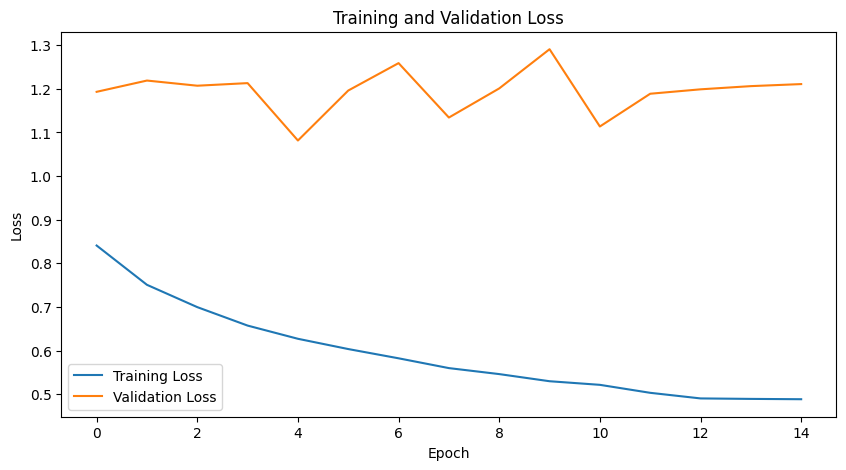

Test Loss: 1.1861
MAPE for PM: 15.44%
MAPE for PM_steam: 25.86%


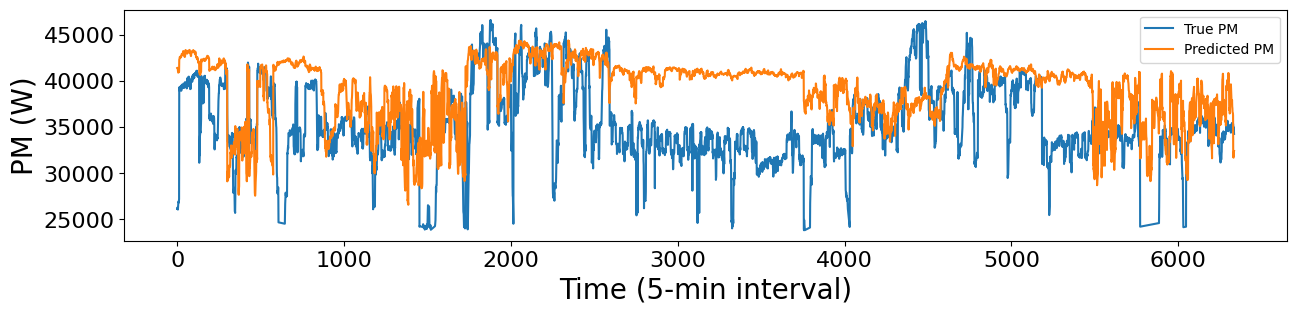

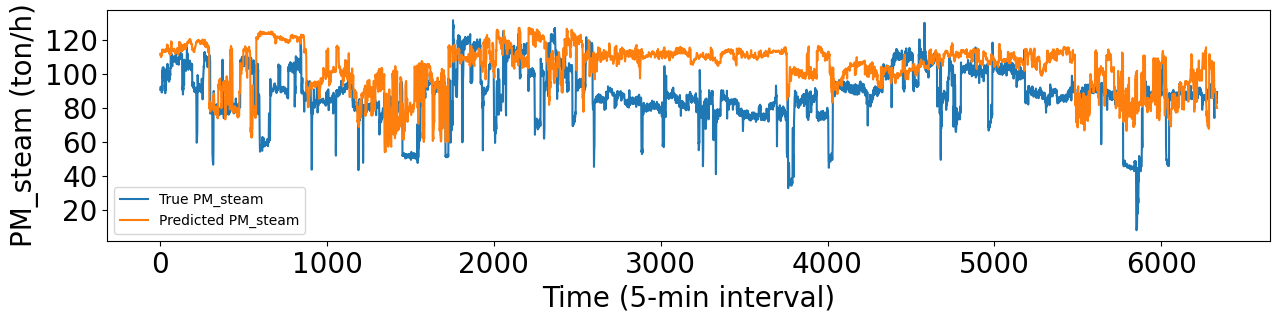

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random

# Đặt seed cho các thư viện khác nhau
random.seed(100)
np.random.seed(100)
torch.manual_seed(100)
torch.cuda.manual_seed(100)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Đọc và chuẩn bị dữ liệu
data = pd.read_csv('/Users/nguyendinhhuy/Desktop/Rolling/fortraining.csv')
data = data.sort_values(by='Time')

# Định nghĩa các đặc trưng
encoder_features = ['PM_lw1','PM_lw2', 'PM_lw3', 'PM_lw4', 'PM_lw5', 'PM_lw6', 'PM_lw7','PM_s1', 'PM_s2', 'PM_s3', 'PM_s4', 'PM_s5', 'PM_s6', 'PM_s7',
                    'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month', 'hour', 'minute'
                    ]
pm_features = ['PM_lw1', 'PM_lw2', 'PM_lw3', 'PM_lw4', 'PM_lw5', 'PM_lw6', 'PM_lw7', 'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month', 'hour', 'minute','PM_s1']
pm_steam_features = ['PM_s1', 'PM_s2', 'PM_s3', 'PM_s4', 'PM_s5', 'PM_s6', 'PM_s7', 'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month', 'hour', 'minute','PM_lw1']
y = data[['PM', 'PM_steam']].values

# Chuẩn hóa dữ liệu
scaler_encoder = StandardScaler()
scaler_pm = StandardScaler()
scaler_pm_steam = StandardScaler()
scaler_y = StandardScaler()  # Thêm scaler cho y

X_encoder = scaler_encoder.fit_transform(data[encoder_features])
X_pm = scaler_pm.fit_transform(data[pm_features])
X_pm_steam = scaler_pm_steam.fit_transform(data[pm_steam_features])
y = scaler_y.fit_transform(y)  # Chuẩn hóa y

# Định nghĩa tổng số mẫu và phần trăm chia
total_samples = len(data)
train_percentage = 0.8
val_percentage = 0.1
test_percentage = 0.1

# Tính kích thước các tập
train_size = int(total_samples * train_percentage)
val_size = int(total_samples * val_percentage)
test_size = total_samples - train_size - val_size

# Điều chỉnh kích thước để chia hết cho 288
train_size -= train_size % 288
val_size -= val_size % 288
test_size -= test_size % 288

# Chuyển đổi sang tensor
X_encoder = torch.tensor(X_encoder, dtype=torch.float32)
X_pm = torch.tensor(X_pm, dtype=torch.float32)
X_pm_steam = torch.tensor(X_pm_steam, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Tạo TensorDataset
train_dataset = TensorDataset(X_encoder[:train_size], X_pm[:train_size], X_pm_steam[:train_size], y[:train_size])
val_dataset = TensorDataset(X_encoder[train_size:train_size + val_size], X_pm[train_size:train_size + val_size], X_pm_steam[train_size:train_size + val_size], y[train_size:train_size + val_size])
test_dataset = TensorDataset(X_encoder[-test_size:], X_pm[-test_size:], X_pm_steam[-test_size:], y[-test_size:])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Kiểm tra kích thước của các tensor
for X_enc, X_pm, X_pm_steam, y in train_loader:
    print(f"X_encoder shape: {X_enc.shape}")
    print(f"X_pm shape: {X_pm.shape}")
    print(f"X_pm_steam shape: {X_pm_steam.shape}")
    print(f"y shape: {y.shape}")
    break  # Chỉ cần in kích thước của batch đầu tiên

# Định nghĩa mô hình với Dropout và Batch Normalization
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, dropout=0.1):
        super(Encoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=8, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.encoder(x)
        return self.norm(x)

class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, dropout=0.2):
        super(Decoder, self).__init__()
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=8, dropout=dropout)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)
        self.output_layer = nn.Linear(d_model, 1)  # Output is a scalar per time step

    def forward(self, memory, x):
        x = self.decoder(x, memory)
        x = self.norm(x)
        x = self.output_layer(x)
        return x

class MultiDeT(nn.Module):
    def __init__(self, encoder_layers=2, decoder_layers=2, d_model=32, dropout=0.3):
        super(MultiDeT, self).__init__()
        self.encoder = Encoder(encoder_layers, d_model=d_model, dropout=dropout)
        self.decoder1 = Decoder(decoder_layers, d_model=d_model, dropout=dropout)
        self.decoder2 = Decoder(decoder_layers, d_model=d_model, dropout=dropout)

        self.encoderLinear = nn.Sequential(
            nn.Linear(len(encoder_features), d_model),
            nn.BatchNorm1d(d_model)  # Thêm BatchNorm1d
        )
        self.decoder1_Linear = nn.Sequential(
            nn.Linear(len(pm_features), d_model),
            nn.BatchNorm1d(d_model)  # Thêm BatchNorm1d
        )
        self.decoder2_Linear = nn.Sequential(
            nn.Linear(len(pm_steam_features), d_model),
            nn.BatchNorm1d(d_model)  # Thêm BatchNorm1d
        )

    def forward(self, src, src_dec1, src_dec2):
        encoder_output = self.encoder(self.encoderLinear(src))

        decoder1_output = self.decoder1(encoder_output, self.decoder1_Linear(src_dec1))
        decoder2_output = self.decoder2(encoder_output, self.decoder2_Linear(src_dec2))

        return decoder1_output, decoder2_output

# Khởi tạo mô hình
model = MultiDeT()

# Định nghĩa hàm loss và optimizer với Weight Decay và Learning Rate Scheduler
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-3)  # Sử dụng AdamW optimizer
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Hàm huấn luyện mô hình với Early Stopping
def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=10):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_enc, X_pm, X_pm_steam, y in train_loader:
            optimizer.zero_grad()
            output1, output2 = model(X_enc, X_pm, X_pm_steam)

            # Reshape outputs to match the target shape
            output1 = output1.view(-1)
            output2 = output2.view(-1)

            # Calculate loss for each output
            loss1 = criterion(output1, y[:, 0])
            loss2 = criterion(output2, y[:, 1])

            # Combine the losses
            loss = 0.8 * loss1 + 0.2 * loss2
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_enc.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_enc, X_pm, X_pm_steam, y in val_loader:
                output1, output2 = model(X_enc, X_pm, X_pm_steam)

                # Reshape outputs to match the target shape
                output1 = output1.view(-1)
                output2 = output2.view(-1)

                # Calculate loss for each output
                loss1 = criterion(output1, y[:, 0])
                loss2 = criterion(output2, y[:, 1])

                # Combine the losses
                loss = 0.8 * loss1 + 0.2 * loss2
                val_loss += loss.item() * X_enc.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}')

        # Step the scheduler
        scheduler.step(val_loss)

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # reset patience counter
            best_model_wts = model.state_dict()  # save the best model
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            model.load_state_dict(best_model_wts)  # load the best model weights
            break

    return train_losses, val_losses

# Huấn luyện mô hình với Early Stopping
train_losses, val_losses = train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=10)

# Vẽ biểu đồ loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

import numpy as np
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader, criterion, scaler_y):
    model.eval()
    test_loss = 0.0
    true_values_pm = []
    true_values_pm_steam = []
    predicted_values_pm = []
    predicted_values_pm_steam = []

    with torch.no_grad():
        for X_enc, X_pm, X_pm_steam, y in test_loader:
            output1, output2 = model(X_enc, X_pm, X_pm_steam)

            # Reshape outputs to match the target shape
            output1 = output1.view(-1)
            output2 = output2.view(-1)

            # Calculate loss for each output
            loss1 = criterion(output1, y[:, 0])
            loss2 = criterion(output2, y[:, 1])
            loss = 0.8 * loss1 + 0.2 * loss2  # Sử dụng cùng trọng số như trong quá trình huấn luyện
            test_loss += loss.item() * X_enc.size(0)

            true_values_pm.extend(y[:, 0].cpu().numpy())
            true_values_pm_steam.extend(y[:, 1].cpu().numpy())
            predicted_values_pm.extend(output1.cpu().numpy())
            predicted_values_pm_steam.extend(output2.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')

    # Convert lists to numpy arrays
    true_values_pm = np.array(true_values_pm)
    true_values_pm_steam = np.array(true_values_pm_steam)
    predicted_values_pm = np.array(predicted_values_pm)
    predicted_values_pm_steam = np.array(predicted_values_pm_steam)

    # Inverse transform the predictions and true values to their original scale
    true_values = scaler_y.inverse_transform(np.vstack((true_values_pm, true_values_pm_steam)).T)
    predicted_values = scaler_y.inverse_transform(np.vstack((predicted_values_pm, predicted_values_pm_steam)).T)

    true_values_pm = true_values[:, 0]
    true_values_pm_steam = true_values[:, 1]
    predicted_values_pm = predicted_values[:, 0]
    predicted_values_pm_steam = predicted_values[:, 1]

    # Calculate Mean Absolute Percentage Error (MAPE)
    mape_pm = np.mean(np.abs((true_values_pm - predicted_values_pm) / true_values_pm)) * 100
    mape_pm_steam = np.mean(np.abs((true_values_pm_steam - predicted_values_pm_steam) / true_values_pm_steam)) * 100

    print(f'MAPE for PM: {mape_pm:.2f}%')
    print(f'MAPE for PM_steam: {mape_pm_steam:.2f}%')

    return true_values_pm, true_values_pm_steam, predicted_values_pm, predicted_values_pm_steam, mape_pm, mape_pm_steam

# Đánh giá mô hình và lưu lại các giá trị dự báo và giá trị thực
true_values_pm, true_values_pm_steam, predicted_values_pm, predicted_values_pm_steam, mape_pm, mape_pm_steam = evaluate_model(model, test_loader, criterion, scaler_y)

# Vẽ biểu đồ dự báo và giá trị thực cho PM
plt.figure(figsize=(15, 3))
plt.plot(true_values_pm, label='True PM')
plt.plot(predicted_values_pm, label='Predicted PM')
plt.yticks( fontsize=16)  # Increased y-tick label font size
plt.xticks(fontsize=16)  # Increased x-tick label font size
plt.xlabel('Time (5-min interval)',fontsize=20)
plt.ylabel('PM (W)',fontsize=20)
plt.legend()
# plt.title('True vs Predicted PM')
plt.show()

# Vẽ biểu đồ dự báo và giá trị thực cho PM_steam
plt.figure(figsize=(15, 3))
plt.plot(true_values_pm_steam, label='True PM_steam')
plt.plot(predicted_values_pm_steam, label='Predicted PM_steam')
plt.yticks( fontsize=20)  # Increased y-tick label font size
plt.xticks(fontsize=20)  # Increased x-tick label font size
plt.xlabel('Time (5-min interval)',fontsize=20)
plt.ylabel('PM_steam (ton/h)',fontsize=20)
plt.legend()
# plt.title('True vs Predicted PM_steam')
plt.show()

X_encoder shape: torch.Size([32, 23])
X_pm shape: torch.Size([32, 17])
X_pm_steam shape: torch.Size([32, 17])
y shape: torch.Size([32, 2])


/Users/nguyendinhhuy/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/Users/nguyendinhhuy/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Training Loss: 0.9208
Epoch 1/100, Validation Loss: 1.2537
Epoch 2/100, Training Loss: 0.8676
Epoch 2/100, Validation Loss: 1.2339
Epoch 3/100, Training Loss: 0.8422
Epoch 3/100, Validation Loss: 1.1509
Epoch 4/100, Training Loss: 0.8181
Epoch 4/100, Validation Loss: 1.2170
Epoch 5/100, Training Loss: 0.8013
Epoch 5/100, Validation Loss: 1.1713
Epoch 6/100, Training Loss: 0.7936
Epoch 6/100, Validation Loss: 1.1505
Epoch 7/100, Training Loss: 0.7831
Epoch 7/100, Validation Loss: 1.1128
Epoch 8/100, Training Loss: 0.7685
Epoch 8/100, Validation Loss: 1.1514
Epoch 9/100, Training Loss: 0.7612
Epoch 9/100, Validation Loss: 1.1143
Epoch 10/100, Training Loss: 0.7531
Epoch 10/100, Validation Loss: 1.1834
Epoch 11/100, Training Loss: 0.7437
Epoch 11/100, Validation Loss: 1.1701
Epoch 12/100, Training Loss: 0.7389
Epoch 12/100, Validation Loss: 1.2301
Epoch 13/100, Training Loss: 0.7319
Epoch 13/100, Validation Loss: 1.1195
Epoch 14/100, Training Loss: 0.7211
Epoch 14/100, Valida

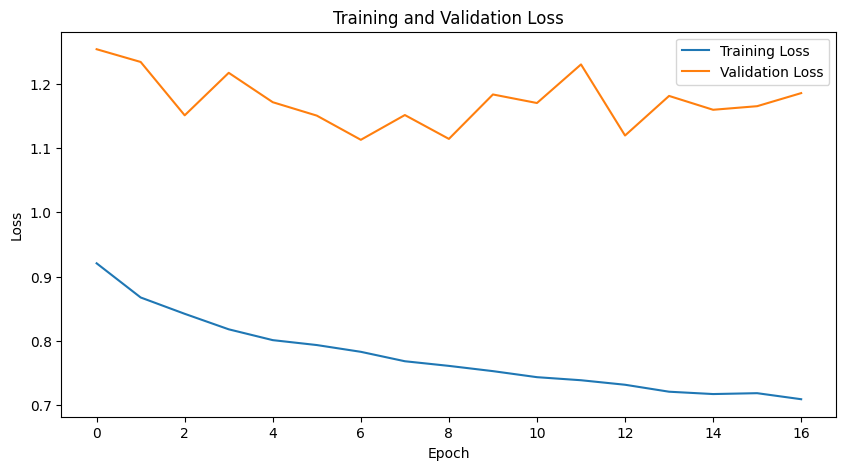

Test Loss: 1.1443
MAPE for PM: 14.87%
MAPE for PM_steam: 24.90%


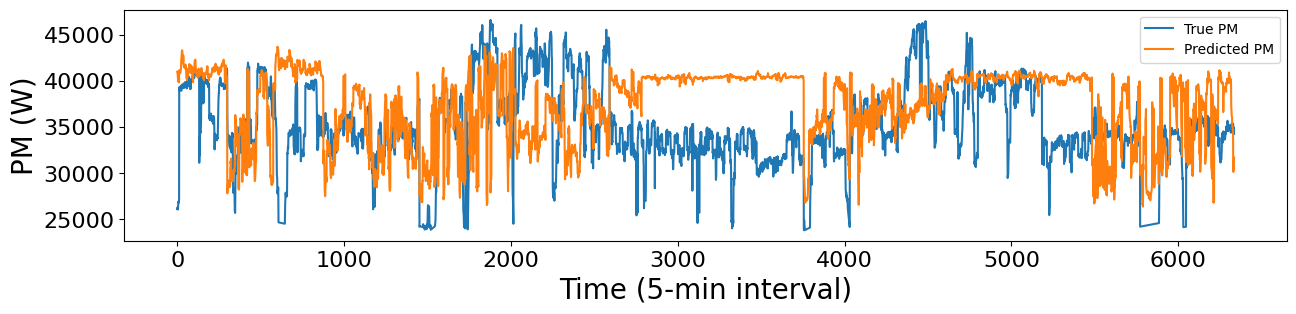

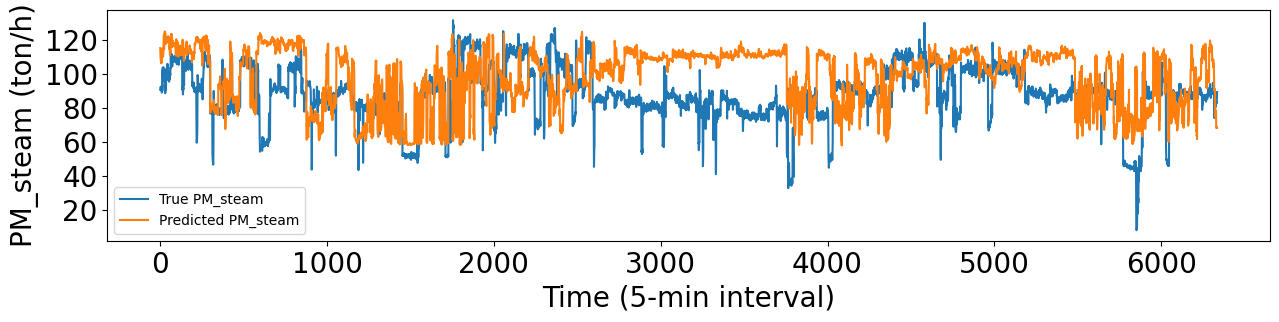

In [11]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random

# Đặt seed cho các thư viện khác nhau
random.seed(100)
np.random.seed(100)
torch.manual_seed(100)
torch.cuda.manual_seed(100)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Đọc và chuẩn bị dữ liệu
data = pd.read_csv('/Users/nguyendinhhuy/Desktop/Rolling/fortraining.csv')
data = data.sort_values(by='Time')

# Định nghĩa các đặc trưng
encoder_features = ['PM_lw1','PM_lw2', 'PM_lw3', 'PM_lw4', 'PM_lw5', 'PM_lw6', 'PM_lw7','PM_s1', 'PM_s2', 'PM_s3', 'PM_s4', 'PM_s5', 'PM_s6', 'PM_s7',
                    'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month', 'hour', 'minute'
                    ]
pm_features = ['PM_lw1', 'PM_lw2', 'PM_lw3', 'PM_lw4', 'PM_lw5', 'PM_lw6', 'PM_lw7', 'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month', 'hour', 'minute','PM_s1']
pm_steam_features = ['PM_s1', 'PM_s2', 'PM_s3', 'PM_s4', 'PM_s5', 'PM_s6', 'PM_s7', 'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month', 'hour', 'minute','PM_lw1']
y = data[['PM', 'PM_steam']].values

# Chuẩn hóa dữ liệu
scaler_encoder = StandardScaler()
scaler_pm = StandardScaler()
scaler_pm_steam = StandardScaler()
scaler_y = StandardScaler()  # Thêm scaler cho y

X_encoder = scaler_encoder.fit_transform(data[encoder_features])
X_pm = scaler_pm.fit_transform(data[pm_features])
X_pm_steam = scaler_pm_steam.fit_transform(data[pm_steam_features])
y = scaler_y.fit_transform(y)  # Chuẩn hóa y

# Định nghĩa tổng số mẫu và phần trăm chia
total_samples = len(data)
train_percentage = 0.8
val_percentage = 0.1
test_percentage = 0.1

# Tính kích thước các tập
train_size = int(total_samples * train_percentage)
val_size = int(total_samples * val_percentage)
test_size = total_samples - train_size - val_size

# Điều chỉnh kích thước để chia hết cho 288
train_size -= train_size % 288
val_size -= val_size % 288
test_size -= test_size % 288

# Chuyển đổi sang tensor
X_encoder = torch.tensor(X_encoder, dtype=torch.float32)
X_pm = torch.tensor(X_pm, dtype=torch.float32)
X_pm_steam = torch.tensor(X_pm_steam, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Tạo TensorDataset
train_dataset = TensorDataset(X_encoder[:train_size], X_pm[:train_size], X_pm_steam[:train_size], y[:train_size])
val_dataset = TensorDataset(X_encoder[train_size:train_size + val_size], X_pm[train_size:train_size + val_size], X_pm_steam[train_size:train_size + val_size], y[train_size:train_size + val_size])
test_dataset = TensorDataset(X_encoder[-test_size:], X_pm[-test_size:], X_pm_steam[-test_size:], y[-test_size:])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Kiểm tra kích thước của các tensor
for X_enc, X_pm, X_pm_steam, y in train_loader:
    print(f"X_encoder shape: {X_enc.shape}")
    print(f"X_pm shape: {X_pm.shape}")
    print(f"X_pm_steam shape: {X_pm_steam.shape}")
    print(f"y shape: {y.shape}")
    break  # Chỉ cần in kích thước của batch đầu tiên

# Định nghĩa mô hình với Dropout và Batch Normalization
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, dropout=0.1):
        super(Encoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=8, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.encoder(x)
        return self.norm(x)

class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, dropout=0.2):
        super(Decoder, self).__init__()
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=8, dropout=dropout)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)
        self.output_layer = nn.Linear(d_model, 1)  # Output is a scalar per time step

    def forward(self, memory, x):
        x = self.decoder(x, memory)
        x = self.norm(x)
        x = self.output_layer(x)
        return x

class MultiDeT(nn.Module):
    def __init__(self, encoder_layers=4, decoder_layers=4, d_model=64, dropout=0.4):
        super(MultiDeT, self).__init__()
        self.encoder = Encoder(encoder_layers, d_model=d_model, dropout=dropout)
        self.decoder1 = Decoder(decoder_layers, d_model=d_model, dropout=dropout)
        self.decoder2 = Decoder(decoder_layers, d_model=d_model, dropout=dropout)

        self.encoderLinear = nn.Sequential(
            nn.Linear(len(encoder_features), d_model),
            nn.BatchNorm1d(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.decoder1_Linear = nn.Sequential(
            nn.Linear(len(pm_features), d_model),
            nn.BatchNorm1d(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.decoder2_Linear = nn.Sequential(
            nn.Linear(len(pm_steam_features), d_model),
            nn.BatchNorm1d(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

    def forward(self, src, src_dec1, src_dec2):
        encoder_output = self.encoder(self.encoderLinear(src))

        decoder1_output = self.decoder1(encoder_output, self.decoder1_Linear(src_dec1))
        decoder2_output = self.decoder2(encoder_output, self.decoder2_Linear(src_dec2))

        return decoder1_output, decoder2_output

# Khởi tạo mô hình
model = MultiDeT()

# Định nghĩa hàm loss và optimizer với Weight Decay và Learning Rate Scheduler
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Hàm huấn luyện mô hình với Early Stopping
def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100, patience=10):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_enc, X_pm, X_pm_steam, y in train_loader:
            optimizer.zero_grad()
            output1, output2 = model(X_enc, X_pm, X_pm_steam)

            # Reshape outputs to match the target shape
            output1 = output1.view(-1)
            output2 = output2.view(-1)

            # Calculate loss for each output
            loss1 = criterion(output1, y[:, 0])
            loss2 = criterion(output2, y[:, 1])

            # Combine the losses
            loss = 0.8 * loss1 + 0.2 * loss2
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_enc.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_enc, X_pm, X_pm_steam, y in val_loader:
                output1, output2 = model(X_enc, X_pm, X_pm_steam)

                # Reshape outputs to match the target shape
                output1 = output1.view(-1)
                output2 = output2.view(-1)

                # Calculate loss for each output
                loss1 = criterion(output1, y[:, 0])
                loss2 = criterion(output2, y[:, 1])

                # Combine the losses
                loss = 0.8 * loss1 + 0.2 * loss2
                val_loss += loss.item() * X_enc.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}')

        # Step the scheduler
        scheduler.step(val_loss)

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # reset patience counter
            best_model_wts = model.state_dict()  # save the best model
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            model.load_state_dict(best_model_wts)  # load the best model weights
            break

    return train_losses, val_losses

# Huấn luyện mô hình với Early Stopping
train_losses, val_losses = train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100, patience=10)

# Vẽ biểu đồ loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

import numpy as np
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader, criterion, scaler_y):
    model.eval()
    test_loss = 0.0
    true_values_pm = []
    true_values_pm_steam = []
    predicted_values_pm = []
    predicted_values_pm_steam = []

    with torch.no_grad():
        for X_enc, X_pm, X_pm_steam, y in test_loader:
            output1, output2 = model(X_enc, X_pm, X_pm_steam)

            # Reshape outputs to match the target shape
            output1 = output1.view(-1)
            output2 = output2.view(-1)

            # Calculate loss for each output
            loss1 = criterion(output1, y[:, 0])
            loss2 = criterion(output2, y[:, 1])
            loss = 0.8 * loss1 + 0.2 * loss2  # Sử dụng cùng trọng số như trong quá trình huấn luyện
            test_loss += loss.item() * X_enc.size(0)

            true_values_pm.extend(y[:, 0].cpu().numpy())
            true_values_pm_steam.extend(y[:, 1].cpu().numpy())
            predicted_values_pm.extend(output1.cpu().numpy())
            predicted_values_pm_steam.extend(output2.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')

    # Convert lists to numpy arrays
    true_values_pm = np.array(true_values_pm)
    true_values_pm_steam = np.array(true_values_pm_steam)
    predicted_values_pm = np.array(predicted_values_pm)
    predicted_values_pm_steam = np.array(predicted_values_pm_steam)

    # Inverse transform the predictions and true values to their original scale
    true_values = scaler_y.inverse_transform(np.vstack((true_values_pm, true_values_pm_steam)).T)
    predicted_values = scaler_y.inverse_transform(np.vstack((predicted_values_pm, predicted_values_pm_steam)).T)

    true_values_pm = true_values[:, 0]
    true_values_pm_steam = true_values[:, 1]
    predicted_values_pm = predicted_values[:, 0]
    predicted_values_pm_steam = predicted_values[:, 1]

    # Calculate Mean Absolute Percentage Error (MAPE)
    mape_pm = np.mean(np.abs((true_values_pm - predicted_values_pm) / true_values_pm)) * 100
    mape_pm_steam = np.mean(np.abs((true_values_pm_steam - predicted_values_pm_steam) / true_values_pm_steam)) * 100

    print(f'MAPE for PM: {mape_pm:.2f}%')
    print(f'MAPE for PM_steam: {mape_pm_steam:.2f}%')

    return true_values_pm, true_values_pm_steam, predicted_values_pm, predicted_values_pm_steam, mape_pm, mape_pm_steam

# Đánh giá mô hình và lưu lại các giá trị dự báo và giá trị thực
true_values_pm, true_values_pm_steam, predicted_values_pm, predicted_values_pm_steam, mape_pm, mape_pm_steam = evaluate_model(model, test_loader, criterion, scaler_y)

# Vẽ biểu đồ dự báo và giá trị thực cho PM
plt.figure(figsize=(15, 3))
plt.plot(true_values_pm, label='True PM')
plt.plot(predicted_values_pm, label='Predicted PM')
plt.yticks( fontsize=16)  # Increased y-tick label font size
plt.xticks(fontsize=16)  # Increased x-tick label font size
plt.xlabel('Time (5-min interval)',fontsize=20)
plt.ylabel('PM (W)',fontsize=20)
plt.legend()
# plt.title('True vs Predicted PM')
plt.show()

# Vẽ biểu đồ dự báo và giá trị thực cho PM_steam
plt.figure(figsize=(15, 3))
plt.plot(true_values_pm_steam, label='True PM_steam')
plt.plot(predicted_values_pm_steam, label='Predicted PM_steam')
plt.yticks( fontsize=20)  # Increased y-tick label font size
plt.xticks(fontsize=20)  # Increased x-tick label font size
plt.xlabel('Time (5-min interval)',fontsize=20)
plt.ylabel('PM_steam (ton/h)',fontsize=20)
plt.legend()
# plt.title('True vs Predicted PM_steam')
plt.show()

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random

# Đặt seed cho các thư viện khác nhau
random.seed(100)
np.random.seed(100)
torch.manual_seed(100)
torch.cuda.manual_seed(100)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Đọc và chuẩn bị dữ liệu
data = pd.read_csv('/Users/nguyendinhhuy/Desktop/Rolling/fortraining.csv')
data = data.sort_values(by='Time')

# Định nghĩa các đặc trưng
encoder_features = ['PM_lw1','PM_lw2', 'PM_lw3', 'PM_lw4', 'PM_lw5', 'PM_lw6', 'PM_lw7','PM_s1', 'PM_s2', 'PM_s3', 'PM_s4', 'PM_s5', 'PM_s6', 'PM_s7',
                    'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month', 'hour', 'minute'
                    ]
pm_features = ['PM_lw1', 'PM_lw2', 'PM_lw3', 'PM_lw4', 'PM_lw5', 'PM_lw6', 'PM_lw7', 'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month', 'hour', 'minute','PM_s1']
pm_steam_features = ['PM_s1', 'PM_s2', 'PM_s3', 'PM_s4', 'PM_s5', 'PM_s6', 'PM_s7', 'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month', 'hour', 'minute','PM_lw1']
y = data[['PM', 'PM_steam']].values

# Chuẩn hóa dữ liệu
scaler_encoder = StandardScaler()
scaler_pm = StandardScaler()
scaler_pm_steam = StandardScaler()
scaler_y = StandardScaler()  # Thêm scaler cho y

X_encoder = scaler_encoder.fit_transform(data[encoder_features])
X_pm = scaler_pm.fit_transform(data[pm_features])
X_pm_steam = scaler_pm_steam.fit_transform(data[pm_steam_features])
y = scaler_y.fit_transform(y)  # Chuẩn hóa y

# Định nghĩa tổng số mẫu và phần trăm chia
total_samples = len(data)
train_percentage = 0.8
val_percentage = 0.1
test_percentage = 0.1

# Tính kích thước các tập
train_size = int(total_samples * train_percentage)
val_size = int(total_samples * val_percentage)
test_size = total_samples - train_size - val_size

# Điều chỉnh kích thước để chia hết cho 288
train_size -= train_size % 288
val_size -= val_size % 288
test_size -= test_size % 288

# Chuyển đổi sang tensor
X_encoder = torch.tensor(X_encoder, dtype=torch.float32)
X_pm = torch.tensor(X_pm, dtype=torch.float32)
X_pm_steam = torch.tensor(X_pm_steam, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Tạo TensorDataset
train_dataset = TensorDataset(X_encoder[:train_size], X_pm[:train_size], X_pm_steam[:train_size], y[:train_size])
val_dataset = TensorDataset(X_encoder[train_size:train_size + val_size], X_pm[train_size:train_size + val_size], X_pm_steam[train_size:train_size + val_size], y[train_size:train_size + val_size])
test_dataset = TensorDataset(X_encoder[-test_size:], X_pm[-test_size:], X_pm_steam[-test_size:], y[-test_size:])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Kiểm tra kích thước của các tensor
for X_enc, X_pm, X_pm_steam, y in train_loader:
    print(f"X_encoder shape: {X_enc.shape}")
    print(f"X_pm shape: {X_pm.shape}")
    print(f"X_pm_steam shape: {X_pm_steam.shape}")
    print(f"y shape: {y.shape}")
    break  # Chỉ cần in kích thước của batch đầu tiên

# Tính toán GCA và chọn các ngày tương tự
def grey_correlation_analysis(data, target_day, features, rho=0.5):
    # Chuẩn hóa dữ liệu
    normalized_data = data[features].apply(lambda x: x / x.mean(), axis=0)
    target_data = normalized_data.loc[target_day]

    # Tính toán độ chênh lệch tuyệt đối
    delta = np.abs(normalized_data - target_data)

    # Tính toán hệ số tương quan xám
    min_delta = delta.min().min()
    max_delta = delta.max().max()
    grey_relations = (min_delta + rho * max_delta) / (delta + rho * max_delta)

    # Tính mức độ tương quan xám tổng hợp
    grey_relations_mean = grey_relations.mean(axis=1)

    return grey_relations_mean

# Chọn các ngày tương tự
def select_similar_days(data, test_days, features, top_n=100):
    similar_days = []
    for test_day in test_days:
        grey_relations = grey_correlation_analysis(data, test_day, features)
        similar_days.append(grey_relations.nsmallest(top_n).index.tolist())
    return similar_days

# Lấy các ngày test
test_days = data.index[-test_size:]

# Chọn các ngày training tương tự với các ngày test
similar_days = select_similar_days(data, test_days, encoder_features)

# Tạo lại TensorDataset với các ngày tương tự
similar_indices = [day for sublist in similar_days for day in sublist]

# Lọc các chỉ số không hợp lệ
valid_indices = [idx for idx in similar_indices if idx < len(data)]

# Chuyển đổi valid_indices thành các chỉ số hợp lệ cho tensor
valid_indices = [idx for idx in valid_indices if idx < len(X_encoder)]

# In ra các chỉ số hợp lệ để kiểm tra
print(f"Valid indices: {valid_indices[:10]}")  # In ra 10 chỉ số đầu tiên để kiểm tra

# Tạo lại TensorDataset với các chỉ số hợp lệ
train_dataset = TensorDataset(X_encoder[valid_indices], X_pm[valid_indices], X_pm_steam[valid_indices], y[valid_indices])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Định nghĩa mô hình với Dropout và Batch Normalization
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, dropout=0.1):
        super(Encoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=8, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.encoder(x)
        return self.norm(x)

class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, dropout=0.2):
        super(Decoder, self).__init__()
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=8, dropout=dropout)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)
        self.output_layer = nn.Linear(d_model, 1)  # Output is a scalar per time step

    def forward(self, memory, x):
        x = self.decoder(x, memory)
        x = self.norm(x)
        x = self.output_layer(x)
        return x

class MultiDeT(nn.Module):
    def __init__(self, encoder_layers=4, decoder_layers=4, d_model=64, dropout=0.4):
        super(MultiDeT, self).__init__()
        self.encoder = Encoder(encoder_layers, d_model=d_model, dropout=dropout)
        self.decoder1 = Decoder(decoder_layers, d_model=d_model, dropout=dropout)
        self.decoder2 = Decoder(decoder_layers, d_model=d_model, dropout=dropout)

        self.encoderLinear = nn.Sequential(
            nn.Linear(len(encoder_features), d_model),
            nn.BatchNorm1d(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.decoder1_Linear = nn.Sequential(
            nn.Linear(len(pm_features), d_model),
            nn.BatchNorm1d(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.decoder2_Linear = nn.Sequential(
            nn.Linear(len(pm_steam_features), d_model),
            nn.BatchNorm1d(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

    def forward(self, src, src_dec1, src_dec2):
        encoder_output = self.encoder(self.encoderLinear(src))

        decoder1_output = self.decoder1(encoder_output, self.decoder1_Linear(src_dec1))
        decoder2_output = self.decoder2(encoder_output, self.decoder2_Linear(src_dec2))

        return decoder1_output, decoder2_output

# Khởi tạo mô hình
model = MultiDeT()

# Định nghĩa hàm loss và optimizer với Weight Decay và Learning Rate Scheduler
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Hàm huấn luyện mô hình với Early Stopping
def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100, patience=10):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_enc, X_pm, X_pm_steam, y in train_loader:
            optimizer.zero_grad()
            output1, output2 = model(X_enc, X_pm, X_pm_steam)

            # Reshape outputs to match the target shape
            output1 = output1.view(-1)
            output2 = output2.view(-1)

            # Calculate loss for each output
            loss1 = criterion(output1, y[:, 0])
            loss2 = criterion(output2, y[:, 1])

            # Combine the losses
            loss = 0.8 * loss1 + 0.2 * loss2
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_enc.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_enc, X_pm, X_pm_steam, y in val_loader:
                output1, output2 = model(X_enc, X_pm, X_pm_steam)

                # Reshape outputs to match the target shape
                output1 = output1.view(-1)
                output2 = output2.view(-1)

                # Calculate loss for each output
                loss1 = criterion(output1, y[:, 0])
                loss2 = criterion(output2, y[:, 1])

                # Combine the losses
                loss = 0.8 * loss1 + 0.2 * loss2
                val_loss += loss.item() * X_enc.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}')

        # Step the scheduler
        scheduler.step(val_loss)

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # reset patience counter
            best_model_wts = model.state_dict()  # save the best model
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            model.load_state_dict(best_model_wts)  # load the best model weights
            break

    return train_losses, val_losses

# Huấn luyện mô hình với Early Stopping
train_losses, val_losses = train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100, patience=10)

# Vẽ biểu đồ loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

import numpy as np
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader, criterion, scaler_y):
    model.eval()
    test_loss = 0.0
    true_values_pm = []
    true_values_pm_steam = []
    predicted_values_pm = []
    predicted_values_pm_steam = []

    with torch.no_grad():
        for X_enc, X_pm, X_pm_steam, y in test_loader:
            output1, output2 = model(X_enc, X_pm, X_pm_steam)

            # Reshape outputs to match the target shape
            output1 = output1.view(-1)
            output2 = output2.view(-1)

            # Calculate loss for each output
            loss1 = criterion(output1, y[:, 0])
            loss2 = criterion(output2, y[:, 1])
            loss = 0.8 * loss1 + 0.2 * loss2  # Sử dụng cùng trọng số như trong quá trình huấn luyện
            test_loss += loss.item() * X_enc.size(0)

            true_values_pm.extend(y[:, 0].cpu().numpy())
            true_values_pm_steam.extend(y[:, 1].cpu().numpy())
            predicted_values_pm.extend(output1.cpu().numpy())
            predicted_values_pm_steam.extend(output2.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')

    # Convert lists to numpy arrays
    true_values_pm = np.array(true_values_pm)
    true_values_pm_steam = np.array(true_values_pm_steam)
    predicted_values_pm = np.array(predicted_values_pm)
    predicted_values_pm_steam = np.array(predicted_values_pm_steam)

    # Inverse transform the predictions and true values to their original scale
    true_values = scaler_y.inverse_transform(np.vstack((true_values_pm, true_values_pm_steam)).T)
    predicted_values = scaler_y.inverse_transform(np.vstack((predicted_values_pm, predicted_values_pm_steam)).T)

    true_values_pm = true_values[:, 0]
    true_values_pm_steam = true_values[:, 1]
    predicted_values_pm = predicted_values[:, 0]
    predicted_values_pm_steam = predicted_values[:, 1]

    # Calculate Mean Absolute Percentage Error (MAPE)
    mape_pm = np.mean(np.abs((true_values_pm - predicted_values_pm) / true_values_pm)) * 100
    mape_pm_steam = np.mean(np.abs((true_values_pm_steam - predicted_values_pm_steam) / true_values_pm_steam)) * 100

    print(f'MAPE for PM: {mape_pm:.2f}%')
    print(f'MAPE for PM_steam: {mape_pm_steam:.2f}%')

    return true_values_pm, true_values_pm_steam, predicted_values_pm, predicted_values_pm_steam, mape_pm, mape_pm_steam

# Đánh giá mô hình và lưu lại các giá trị dự báo và giá trị thực
true_values_pm, true_values_pm_steam, predicted_values_pm, predicted_values_pm_steam, mape_pm, mape_pm_steam = evaluate_model(model, test_loader, criterion, scaler_y)

# Vẽ biểu đồ dự báo và giá trị thực cho PM
plt.figure(figsize=(15, 3))
plt.plot(true_values_pm, label='True PM')
plt.plot(predicted_values_pm, label='Predicted PM')
plt.yticks( fontsize=16)  # Increased y-tick label font size
plt.xticks(fontsize=16)  # Increased x-tick label font size
plt.xlabel('Time (5-min interval)',fontsize=20)
plt.ylabel('PM (W)',fontsize=20)
plt.legend()
# plt.title('True vs Predicted PM')
plt.show()

# Vẽ biểu đồ dự báo và giá trị thực cho PM_steam
plt.figure(figsize=(15, 3))
plt.plot(true_values_pm_steam, label='True PM_steam')
plt.plot(predicted_values_pm_steam, label='Predicted PM_steam')
plt.yticks( fontsize=20)  # Increased y-tick label font size
plt.xticks(fontsize=20)  # Increased x-tick label font size
plt.xlabel('Time (5-min interval)',fontsize=20)
plt.ylabel('PM_steam (ton/h)',fontsize=20)
plt.legend()
# plt.title('True vs Predicted PM_steam')
plt.show()

X_encoder shape: torch.Size([32, 23])
X_pm shape: torch.Size([32, 17])
X_pm_steam shape: torch.Size([32, 17])
y shape: torch.Size([32, 2])


KeyboardInterrupt: 

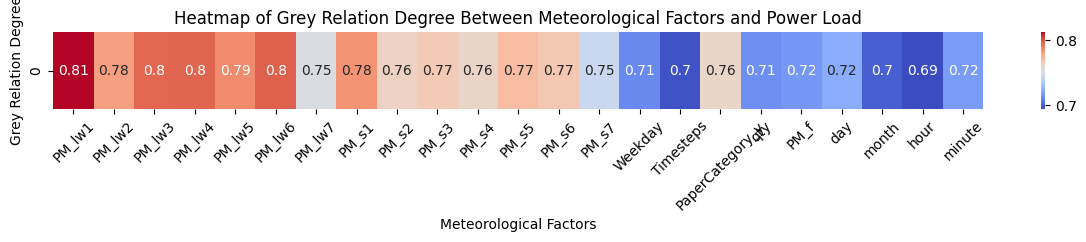

Có nhiều hơn một hàng phù hợp: Index([63360, 63361, 63362, 63363, 63364, 63365, 63366, 63367, 63368, 63369,
       ...
       63638, 63639, 63640, 63641, 63642, 63643, 63644, 63645, 63646, 63647],
      dtype='int64', length=288)
Các ngày tương tự nhất với ngày 1 tháng 6 năm 2024 trong tập train (top 20, sắp xếp theo thời gian):
Ngày tương tự (2023, 7, 28) với khoảng cách: 0.0000
Ngày tương tự (2023, 7, 29) với khoảng cách: 71.9844
Ngày tương tự (2023, 7, 31) với khoảng cách: 74.1537
Ngày tương tự (2023, 8, 3) với khoảng cách: 79.3390
Ngày tương tự (2023, 8, 4) với khoảng cách: 77.7807
Ngày tương tự (2023, 8, 25) với khoảng cách: 77.7995
Ngày tương tự (2023, 10, 12) với khoảng cách: 78.2658
Ngày tương tự (2023, 10, 29) với khoảng cách: 78.7929
Ngày tương tự (2023, 11, 4) với khoảng cách: 75.9906
Ngày tương tự (2023, 11, 16) với khoảng cách: 75.4557
Ngày tương tự (2023, 11, 17) với khoảng cách: 77.0353
Ngày tương tự (2023, 11, 23) với khoảng cách: 67.8181
Ngày tương tự (2023, 11, 25) vớ

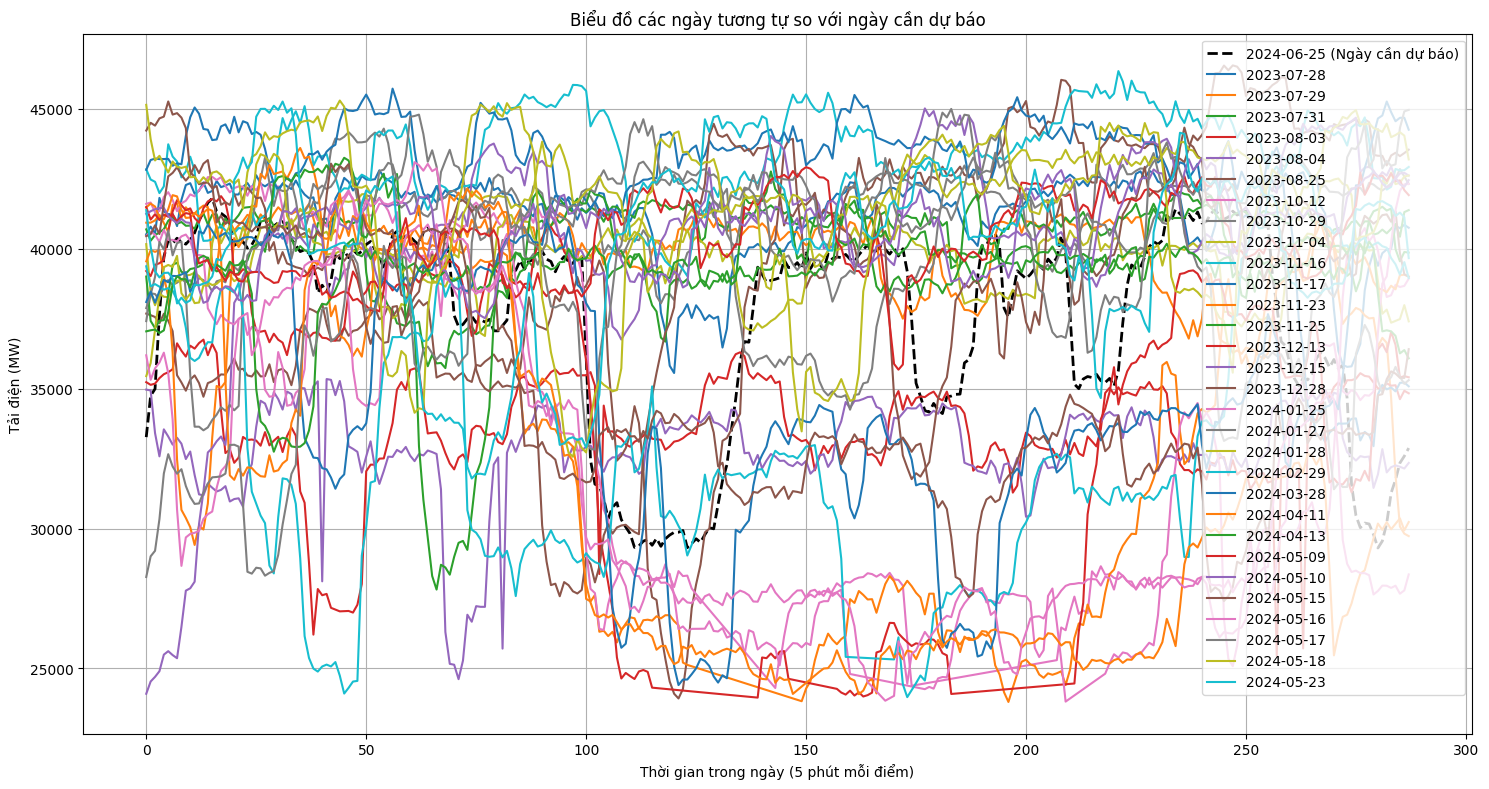

IndexError: index 53280 is out of bounds for dimension 0 with size 32

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import seaborn as sns

# Đặt seed để đảm bảo tính tái lập của kết quả
random.seed(100)
np.random.seed(100)
torch.manual_seed(100)
torch.cuda.manual_seed(100)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Đọc dữ liệu và chuẩn bị
data = pd.read_csv('/Users/nguyendinhhuy/Desktop/Rolling/testthudataa.csv')
data = data.sort_values(by='Time')

# Chuyển cột Time sang định dạng datetime nếu chưa đúng định dạng
data['Time'] = pd.to_datetime(data['Time'])

# Thêm cột 'year', 'day', và 'month' từ cột 'Time'
data['year'] = data['Time'].dt.year
data['day'] = data['Time'].dt.day
data['month'] = data['Time'].dt.month

# Tính toán số lượng mẫu và chia tỷ lệ cho train và test
total_samples = len(data)
train_percentage = 0.9
test_percentage = 0.1

# Tính kích thước các tập
train_size = int(total_samples * train_percentage)
test_size = total_samples - train_size

# Điều chỉnh kích thước để chia hết cho 288
train_size -= train_size % 288
test_size = total_samples - train_size  # Đảm bảo tổng số mẫu không thay đổi

# Chia dữ liệu thành train và test
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Kiểm tra và lọc các ngày có đủ 288 điểm trong tập train
daily_counts_train = train_data.groupby(['year', 'month', 'day']).size()
complete_days_train = daily_counts_train[daily_counts_train == 288].index

# Lọc dữ liệu chỉ lấy các ngày có đủ 288 điểm từ tập train
train_data = train_data[train_data.set_index(['year', 'month', 'day']).index.isin(complete_days_train)]

# Xác định các đặc trưng và chuỗi chính
encoder_features = ['PM_lw1','PM_lw2', 'PM_lw3', 'PM_lw4', 'PM_lw5', 'PM_lw6', 'PM_lw7',
                    'PM_s1', 'PM_s2', 'PM_s3', 'PM_s4', 'PM_s5', 'PM_s6', 'PM_s7',
                    'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month', 'hour', 'minute']
y_train = train_data[['PM', 'PM_steam']].values

# Chuẩn hóa dữ liệu
scaler_encoder = StandardScaler()
scaler_y = StandardScaler()

X_encoder_train = scaler_encoder.fit_transform(train_data[encoder_features])
y_train = scaler_y.fit_transform(y_train)

# Chuyển đổi sang tensor
X_encoder_train = torch.tensor(X_encoder_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

# Hàm tính hệ số tương quan xám giữa chuỗi chính và các yếu tố trong chuỗi con
def calculate_grey_relation_degree(y, X):
    n_samples, n_features = X.shape
    n_targets = y.shape[1]  # Số cột trong y (chuỗi chính)
    rho = 0.5  # Hệ số phân giải
    grey_relation_matrix = np.zeros((n_samples, n_features, n_targets))

    for j in range(n_targets):  # Lặp qua mỗi cột của chuỗi chính y
        for i in range(n_features):
            delta = np.abs(y[:, j] - X[:, i])
            min_delta = np.min(delta)
            max_delta = np.max(delta)

            # Tính toán hệ số tương quan xám cho mỗi cột của y với từng đặc trưng của X
            grey_relation_matrix[:, i, j] = (min_delta + rho * max_delta) / (delta + rho * max_delta)

    # Trung bình mức độ tương quan xám theo số cột của y để lấy giá trị tổng hợp cho mỗi đặc trưng
    grey_relation_mean = grey_relation_matrix.mean(axis=2)
    
    return grey_relation_mean

# Áp dụng tính toán tương quan xám cho dữ liệu chuẩn hóa của tập train
grey_relation_degrees = calculate_grey_relation_degree(y_train.numpy(), X_encoder_train.numpy())

# Tính mức độ tương quan xám tổng hợp
grey_relation_mean_values = grey_relation_degrees.mean(axis=0)

# Vẽ heatmap của mức độ tương quan xám
grey_relation_df = pd.DataFrame([grey_relation_mean_values], columns=encoder_features)
plt.figure(figsize=(15, 1))
sns.heatmap(grey_relation_df, annot=True, cmap='coolwarm', cbar=True)
plt.title('Heatmap of Grey Relation Degree Between Meteorological Factors and Power Load')
plt.xlabel('Meteorological Factors')
plt.ylabel('Grey Relation Degree')
plt.xticks(rotation=45)
plt.show()

# Xác định chỉ mục của ngày 1 tháng 6 năm 2024 trong tập test
target_day = 25
target_month = 6
target_year = 2024

# Tìm các hàng trong tập test mà có day = 1, month = 6, và year = 2024
target_indices = test_data[(test_data['day'] == target_day) & 
                           (test_data['month'] == target_month) & 
                           (test_data['year'] == target_year)].index

# Kiểm tra nếu có nhiều hơn một hàng thỏa mãn, chọn chỉ số phù hợp
if len(target_indices) > 1:
    print(f"Có nhiều hơn một hàng phù hợp: {target_indices}")
target_day_data = X_encoder_train[target_indices % 288].numpy()  # Lấy 288 điểm của ngày cần dự báo

# Lấy các chỉ số của từng ngày trong tập train
daily_indices_train = [train_data[(train_data['year'] == y) & 
                                  (train_data['month'] == m) & 
                                  (train_data['day'] == d)].index 
                       for y, m, d in complete_days_train]

# Hàm tính khoảng cách Euclid cho toàn bộ 288 điểm của mỗi ngày
def calculate_daily_euclidean_distance(target_day_data, historical_data, daily_indices):
    daily_distances = []
    for indices in daily_indices:
        day_data = historical_data[indices]  # Lấy dữ liệu cho ngày hiện tại (288 điểm)
        distance = np.sqrt(np.sum((day_data - target_day_data) ** 2))  # Tính khoảng cách Euclid
        daily_distances.append(distance)
    
    return np.array(daily_distances)

# Tính khoảng cách Euclid giữa ngày cần dự báo và các ngày trong tập train
distances = calculate_daily_euclidean_distance(target_day_data, X_encoder_train.numpy(), daily_indices_train)

# Bước 4: Sắp xếp và chọn các ngày tương tự nhất từ tập train
sorted_indices = np.argsort(distances)
top_similar_days = [complete_days_train[idx] for idx in sorted_indices[:30]]  # Chọn 20 ngày tương tự nhất từ tập train

# Sắp xếp các ngày tương tự theo thứ tự thời gian
top_similar_days_sorted = sorted(top_similar_days, key=lambda x: (x[0], x[1], x[2]))

# Hiển thị các ngày tương tự nhất từ tập train theo thứ tự thời gian
print("Các ngày tương tự nhất với ngày 1 tháng 6 năm 2024 trong tập train (top 20, sắp xếp theo thời gian):")
for day in top_similar_days_sorted:
    print(f"Ngày tương tự {day} với khoảng cách: {distances[sorted_indices[top_similar_days.index(day)]]:.4f}")

# Kiểm tra và xác nhận các ngày có đủ 288 điểm dữ liệu
valid_days = [day for day in top_similar_days_sorted if len(train_data[(train_data['year'] == day[0]) & 
                                                                       (train_data['month'] == day[1]) & 
                                                                       (train_data['day'] == day[2])]) == 288]

if valid_days:
    print("Các ngày có đủ 288 điểm dữ liệu:")
    for day in valid_days:
        print(f"Ngày {day} trong tập train với khoảng cách: {distances[sorted_indices[top_similar_days.index(day)]]:.4f}")
else:
    print("Không có ngày nào có đủ 288 điểm dữ liệu.")

import matplotlib.pyplot as plt

# Hàm vẽ biểu đồ các ngày tương tự
def plot_similar_days(train_data, similar_days, target_day_data, target_day_label):
    plt.figure(figsize=(15, 8))
    
    # Vẽ dữ liệu của ngày cần dự báo
    plt.plot(range(288), target_day_data, label=f'{target_day_label} (Ngày cần dự báo)', linewidth=2, linestyle='--', color='black')
    
    # Vẽ dữ liệu của các ngày tương tự
    for day in similar_days:
        day_data = train_data[(train_data['year'] == day[0]) & 
                              (train_data['month'] == day[1]) & 
                              (train_data['day'] == day[2])]
        load_values = day_data['PM'].values  # Điều chỉnh tên cột nếu cần thiết
        label = f'{day[0]}-{day[1]:02d}-{day[2]:02d}'  # Định dạng ngày tháng năm
        
        plt.plot(range(288), load_values, label=label)
    
    plt.title('Biểu đồ các ngày tương tự so với ngày cần dự báo')
    plt.xlabel('Thời gian trong ngày (5 phút mỗi điểm)')
    plt.ylabel('Tải điện (MW)')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Chuẩn bị dữ liệu của ngày cần dự báo
target_day_label = f'{target_year}-{target_month:02d}-{target_day:02d}'
target_day_load_values = test_data.loc[target_indices, 'PM'].values  # Điều chỉnh tên cột nếu cần thiết

# Gọi hàm vẽ các ngày tương tự
plot_similar_days(train_data, top_similar_days_sorted, target_day_load_values, target_day_label)

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import random

# Đặt seed để đảm bảo tính tái lập của kết quả
random.seed(100)
np.random.seed(100)
torch.manual_seed(100)
torch.cuda.manual_seed(100)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Giả sử top_similar_days_sorted chứa các ngày tương tự đã sắp xếp theo thời gian
# Lấy chỉ số của các ngày tương tự từ tập train
similar_day_indices = []

for day in top_similar_days_sorted:
    indices = train_data[(train_data['year'] == day[0]) & 
                         (train_data['month'] == day[1]) & 
                         (train_data['day'] == day[2])].index
    similar_day_indices.extend(indices)

# Chuẩn bị dữ liệu cho mô hình từ các ngày tương tự
X_encoder_train = X_encoder[similar_day_indices]
X_pm_train = X_pm[similar_day_indices]
X_pm_steam_train = X_pm_steam[similar_day_indices]
y_train = y[similar_day_indices]

# Tạo TensorDataset cho tập train với các ngày tương tự
train_dataset = TensorDataset(torch.tensor(X_encoder_train, dtype=torch.float32),
                              torch.tensor(X_pm_train, dtype=torch.float32),
                              torch.tensor(X_pm_steam_train, dtype=torch.float32),
                              torch.tensor(y_train, dtype=torch.float32))

# DataLoader cho tập train
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Định nghĩa lớp Encoder cho mô hình Transformer
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, dropout=0.1):
        super(Encoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=8, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.encoder(x)
        return self.norm(x)

# Định nghĩa lớp Decoder cho mô hình Transformer
class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, dropout=0.2):
        super(Decoder, self).__init__()
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=8, dropout=dropout)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)
        self.output_layer = nn.Linear(d_model, 1)  # Output là một scalar cho mỗi thời điểm

    def forward(self, memory, x):
        x = self.decoder(x, memory)
        x = self.norm(x)
        x = self.output_layer(x)
        return x

# Định nghĩa mô hình MultiDeT với hai Decoder cho hai loại tải
class MultiDeT(nn.Module):
    def __init__(self, encoder_layers=1, decoder_layers=1, d_model=16, dropout=0.2):
        super(MultiDeT, self).__init__()
        self.encoder = Encoder(encoder_layers, d_model=d_model, dropout=dropout)
        self.decoder1 = Decoder(decoder_layers, d_model=d_model, dropout=dropout)
        self.decoder2 = Decoder(decoder_layers, d_model=d_model, dropout=dropout)

        self.encoderLinear = nn.Sequential(
            nn.Linear(len(encoder_features), d_model),
            nn.BatchNorm1d(d_model)  # Thêm BatchNorm1d
        )
        self.decoder1_Linear = nn.Sequential(
            nn.Linear(len(pm_features), d_model),
            nn.BatchNorm1d(d_model)  # Thêm BatchNorm1d
        )
        self.decoder2_Linear = nn.Sequential(
            nn.Linear(len(pm_steam_features), d_model),
            nn.BatchNorm1d(d_model)  # Thêm BatchNorm1d
        )

    def forward(self, src, src_dec1, src_dec2):
        encoder_output = self.encoder(self.encoderLinear(src))

        decoder1_output = self.decoder1(encoder_output, self.decoder1_Linear(src_dec1))
        decoder2_output = self.decoder2(encoder_output, self.decoder2_Linear(src_dec2))

        return decoder1_output, decoder2_output

# Khởi tạo mô hình Transformer (MultiDeT)
model = MultiDeT(encoder_layers=1, decoder_layers=1, d_model=16, dropout=0.2)

# Định nghĩa hàm loss và optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-3)  # Sử dụng AdamW optimizer
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=10, verbose=True)

# Hàm huấn luyện mô hình
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=50):
    train_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_enc, X_pm, X_pm_steam, y in train_loader:
            optimizer.zero_grad()
            output1, output2 = model(X_enc, X_pm, X_pm_steam)

            # Reshape outputs to match the target shape
            output1 = output1.view(-1)
            output2 = output2.view(-1)

            # Calculate loss for each output
            loss1 = criterion(output1, y[:, 0])
            loss2 = criterion(output2, y[:, 1])

            # Combine the losses
            loss = 0.8 * loss1 + 0.2 * loss2
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_enc.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

        # Step the scheduler
        scheduler.step(epoch_loss)

    return train_losses

# Huấn luyện mô hình với tập dữ liệu từ các ngày tương tự
train_losses = train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=50)

# Tạo tập test cho đánh giá
# Thay đổi phần này để chỉ dự báo cho ngày đã chỉ định trước đó trong tập test
test_day = 25
test_month = 6
test_year = 2024

# Tìm chỉ số của ngày cần dự báo trong tập test
test_indices = test_data[(test_data['day'] == test_day) & 
                        (test_data['month'] == test_month) & 
                        (test_data['year'] == test_year)].index

# Đảm bảo có đủ 288 điểm dữ liệu cho ngày này
if len(test_indices) == 288:
    print(f"Dự báo cho ngày {test_day}/{test_month}/{test_year}")

    # Chuẩn bị dữ liệu cho mô hình từ ngày cần dự báo
    X_encoder_test = X_encoder[test_indices]
    X_pm_test = X_pm[test_indices]
    X_pm_steam_test = X_pm_steam[test_indices]
    y_test = y[test_indices]

    # Tạo TensorDataset cho tập test
    test_dataset = TensorDataset(torch.tensor(X_encoder_test, dtype=torch.float32),
                                 torch.tensor(X_pm_test, dtype=torch.float32),
                                 torch.tensor(X_pm_steam_test, dtype=torch.float32),
                                 torch.tensor(y_test, dtype=torch.float32))

    # DataLoader cho tập test
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Đánh giá mô hình với tập test
    def evaluate_model(model, test_loader, criterion, scaler_y):
        model.eval()
        test_loss = 0.0
        true_values_pm = []
        true_values_pm_steam = []
        predicted_values_pm = []
        predicted_values_pm_steam = []

        with torch.no_grad():
            for X_enc, X_pm, X_pm_steam, y in test_loader:
                output1, output2 = model(X_enc, X_pm, X_pm_steam)

                # Reshape outputs to match the target shape
                output1 = output1.view(-1)
                output2 = output2.view(-1)

                # Calculate loss for each output
                loss1 = criterion(output1, y[:, 0])
                loss2 = criterion(output2, y[:, 1])
                loss = 0.8 * loss1 + 0.2 * loss2  # Sử dụng cùng trọng số như trong quá trình huấn luyện
                test_loss += loss.item() * X_enc.size(0)

                true_values_pm.extend(y[:, 0].cpu().numpy())
                true_values_pm_steam.extend(y[:, 1].cpu().numpy())
                predicted_values_pm.extend(output1.cpu().numpy())
                predicted_values_pm_steam.extend(output2.cpu().numpy())

        test_loss = test_loss / len(test_loader.dataset)
        print(f'Test Loss: {test_loss:.4f}')

        # Convert lists to numpy arrays
        true_values_pm = np.array(true_values_pm)
        true_values_pm_steam = np.array(true_values_pm_steam)
        predicted_values_pm = np.array(predicted_values_pm)
        predicted_values_pm_steam = np.array(predicted_values_pm_steam)

        # Inverse transform the predictions and true values to their original scale
        true_values = scaler_y.inverse_transform(np.vstack((true_values_pm, true_values_pm_steam)).T)
        predicted_values = scaler_y.inverse_transform(np.vstack((predicted_values_pm, predicted_values_pm_steam)).T)

        true_values_pm = true_values[:, 0]
        true_values_pm_steam = true_values[:, 1]
        predicted_values_pm = predicted_values[:, 0]
        predicted_values_pm_steam = predicted_values[:, 1]

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape_pm = np.mean(np.abs((true_values_pm - predicted_values_pm) / true_values_pm)) * 100
        mape_pm_steam = np.mean(np.abs((true_values_pm_steam - predicted_values_pm_steam) / true_values_pm_steam)) * 100

        print(f'MAPE for PM: {mape_pm:.2f}%')
        print(f'MAPE for PM_steam: {mape_pm_steam:.2f}%')

        return true_values_pm, true_values_pm_steam, predicted_values_pm, predicted_values_pm_steam, mape_pm, mape_pm_steam

    # Đánh giá mô hình với tập test
    true_values_pm, true_values_pm_steam, predicted_values_pm, predicted_values_pm_steam, mape_pm, mape_pm_steam = evaluate_model(model, test_loader, criterion, scaler_y)

    # Vẽ biểu đồ dự báo và giá trị thực cho PM
    plt.figure(figsize=(15, 3))
    plt.plot(true_values_pm, label='True PM')
    plt.plot(predicted_values_pm, label='Predicted PM')
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    plt.xlabel('Time (5-min interval)', fontsize=20)
    plt.ylabel('PM (W)', fontsize=20)
    plt.title(f'Dự báo PM cho ngày {test_day}/{test_month}/{test_year}', fontsize=20)
    plt.legend(fontsize=16)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Vẽ biểu đồ dự báo và giá trị thực cho PM_steam
    plt.figure(figsize=(15, 3))

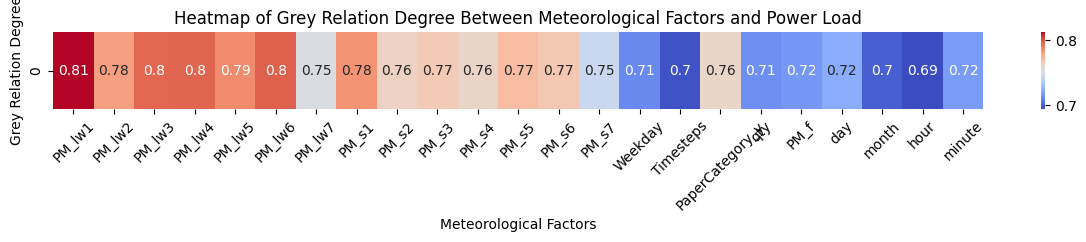

Có nhiều hơn một hàng phù hợp: Index([63360, 63361, 63362, 63363, 63364, 63365, 63366, 63367, 63368, 63369,
       ...
       63638, 63639, 63640, 63641, 63642, 63643, 63644, 63645, 63646, 63647],
      dtype='int64', length=288)
Các ngày tương tự nhất với ngày 1 tháng 6 năm 2024 trong tập train (top 20, sắp xếp theo thời gian):
Ngày tương tự (2023, 7, 28) với khoảng cách: 0.0000
Ngày tương tự (2023, 7, 29) với khoảng cách: 71.9844
Ngày tương tự (2023, 7, 31) với khoảng cách: 74.1537
Ngày tương tự (2023, 8, 3) với khoảng cách: 79.3390
Ngày tương tự (2023, 8, 4) với khoảng cách: 77.7807
Ngày tương tự (2023, 8, 25) với khoảng cách: 77.7995
Ngày tương tự (2023, 10, 12) với khoảng cách: 78.2658
Ngày tương tự (2023, 10, 29) với khoảng cách: 78.7929
Ngày tương tự (2023, 11, 4) với khoảng cách: 75.9906
Ngày tương tự (2023, 11, 16) với khoảng cách: 75.4557
Ngày tương tự (2023, 11, 17) với khoảng cách: 77.0353
Ngày tương tự (2023, 11, 23) với khoảng cách: 67.8181
Ngày tương tự (2023, 11, 25) vớ

/var/folders/cm/nfg3lzjx1yb8gh0lpqtj20zc0000gn/T/ipykernel_2690/135356668.py:189: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


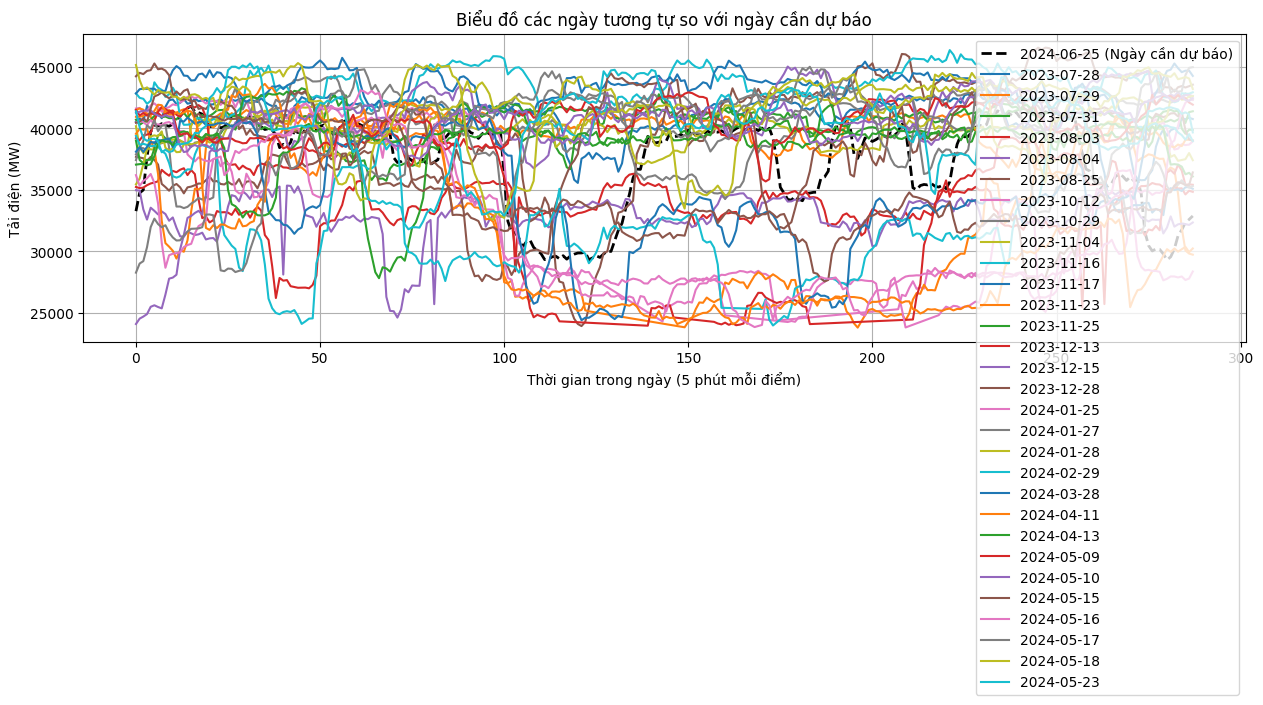

In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import seaborn as sns

# Đặt seed để đảm bảo tính tái lập của kết quả
random.seed(100)
np.random.seed(100)
torch.manual_seed(100)
torch.cuda.manual_seed(100)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Đọc dữ liệu và chuẩn bị
data = pd.read_csv('/Users/nguyendinhhuy/Desktop/Rolling/testthudataa.csv')
data = data.sort_values(by='Time')

# Chuyển cột Time sang định dạng datetime nếu chưa đúng định dạng
data['Time'] = pd.to_datetime(data['Time'])

# Thêm cột 'year', 'day', và 'month' từ cột 'Time'
data['year'] = data['Time'].dt.year
data['day'] = data['Time'].dt.day
data['month'] = data['Time'].dt.month

# Tính toán số lượng mẫu và chia tỷ lệ cho train và test
total_samples = len(data)
train_percentage = 0.9
test_percentage = 0.1

# Tính kích thước các tập
train_size = int(total_samples * train_percentage)
test_size = total_samples - train_size

# Điều chỉnh kích thước để chia hết cho 288
train_size -= train_size % 288
test_size = total_samples - train_size  # Đảm bảo tổng số mẫu không thay đổi

# Chia dữ liệu thành train và test
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Kiểm tra và lọc các ngày có đủ 288 điểm trong tập train
daily_counts_train = train_data.groupby(['year', 'month', 'day']).size()
complete_days_train = daily_counts_train[daily_counts_train == 288].index

# Lọc dữ liệu chỉ lấy các ngày có đủ 288 điểm từ tập train
train_data = train_data[train_data.set_index(['year', 'month', 'day']).index.isin(complete_days_train)]

# Xác định các đặc trưng và chuỗi chính
encoder_features = ['PM_lw1','PM_lw2', 'PM_lw3', 'PM_lw4', 'PM_lw5', 'PM_lw6', 'PM_lw7',
                    'PM_s1', 'PM_s2', 'PM_s3', 'PM_s4', 'PM_s5', 'PM_s6', 'PM_s7',
                    'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month', 'hour', 'minute']
y_train = train_data[['PM', 'PM_steam']].values

# Chuẩn hóa dữ liệu
scaler_encoder = StandardScaler()
scaler_y = StandardScaler()

X_encoder_train = scaler_encoder.fit_transform(train_data[encoder_features])
y_train = scaler_y.fit_transform(y_train)

# Chuyển đổi sang tensor
X_encoder_train = torch.tensor(X_encoder_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

# Hàm tính hệ số tương quan xám giữa chuỗi chính và các yếu tố trong chuỗi con
def calculate_grey_relation_degree(y, X):
    n_samples, n_features = X.shape
    n_targets = y.shape[1]  # Số cột trong y (chuỗi chính)
    rho = 0.5  # Hệ số phân giải
    grey_relation_matrix = np.zeros((n_samples, n_features, n_targets))

    for j in range(n_targets):  # Lặp qua mỗi cột của chuỗi chính y
        for i in range(n_features):
            delta = np.abs(y[:, j] - X[:, i])
            min_delta = np.min(delta)
            max_delta = np.max(delta)

            # Tính toán hệ số tương quan xám cho mỗi cột của y với từng đặc trưng của X
            grey_relation_matrix[:, i, j] = (min_delta + rho * max_delta) / (delta + rho * max_delta)

    # Trung bình mức độ tương quan xám theo số cột của y để lấy giá trị tổng hợp cho mỗi đặc trưng
    grey_relation_mean = grey_relation_matrix.mean(axis=2)
    
    return grey_relation_mean

# Áp dụng tính toán tương quan xám cho dữ liệu chuẩn hóa của tập train
grey_relation_degrees = calculate_grey_relation_degree(y_train.numpy(), X_encoder_train.numpy())

# Tính mức độ tương quan xám tổng hợp
grey_relation_mean_values = grey_relation_degrees.mean(axis=0)

# Vẽ heatmap của mức độ tương quan xám
grey_relation_df = pd.DataFrame([grey_relation_mean_values], columns=encoder_features)
plt.figure(figsize=(15, 1))
sns.heatmap(grey_relation_df, annot=True, cmap='coolwarm', cbar=True)
plt.title('Heatmap of Grey Relation Degree Between Meteorological Factors and Power Load')
plt.xlabel('Meteorological Factors')
plt.ylabel('Grey Relation Degree')
plt.xticks(rotation=45)
plt.show()

# Xác định chỉ mục của ngày 1 tháng 6 năm 2024 trong tập test
target_day = 25
target_month = 6
target_year = 2024

# Tìm các hàng trong tập test mà có day = 1, month = 6, và year = 2024
target_indices = test_data[(test_data['day'] == target_day) & 
                           (test_data['month'] == target_month) & 
                           (test_data['year'] == target_year)].index

# Kiểm tra nếu có nhiều hơn một hàng thỏa mãn, chọn chỉ số phù hợp
if len(target_indices) > 1:
    print(f"Có nhiều hơn một hàng phù hợp: {target_indices}")
target_day_data = X_encoder_train[target_indices % 288].numpy()  # Lấy 288 điểm của ngày cần dự báo

# Lấy các chỉ số của từng ngày trong tập train
daily_indices_train = [train_data[(train_data['year'] == y) & 
                                  (train_data['month'] == m) & 
                                  (train_data['day'] == d)].index 
                       for y, m, d in complete_days_train]

# Hàm tính khoảng cách Euclid cho toàn bộ 288 điểm của mỗi ngày
def calculate_daily_euclidean_distance(target_day_data, historical_data, daily_indices):
    daily_distances = []
    for indices in daily_indices:
        day_data = historical_data[indices]  # Lấy dữ liệu cho ngày hiện tại (288 điểm)
        distance = np.sqrt(np.sum((day_data - target_day_data) ** 2))  # Tính khoảng cách Euclid
        daily_distances.append(distance)
    
    return np.array(daily_distances)

# Tính khoảng cách Euclid giữa ngày cần dự báo và các ngày trong tập train
distances = calculate_daily_euclidean_distance(target_day_data, X_encoder_train.numpy(), daily_indices_train)

# Bước 4: Sắp xếp và chọn các ngày tương tự nhất từ tập train
sorted_indices = np.argsort(distances)
top_similar_days = [complete_days_train[idx] for idx in sorted_indices[:30]]  # Chọn 20 ngày tương tự nhất từ tập train

# Sắp xếp các ngày tương tự theo thứ tự thời gian
top_similar_days_sorted = sorted(top_similar_days, key=lambda x: (x[0], x[1], x[2]))

# Hiển thị các ngày tương tự nhất từ tập train theo thứ tự thời gian
print("Các ngày tương tự nhất với ngày 1 tháng 6 năm 2024 trong tập train (top 20, sắp xếp theo thời gian):")
for day in top_similar_days_sorted:
    print(f"Ngày tương tự {day} với khoảng cách: {distances[sorted_indices[top_similar_days.index(day)]]:.4f}")

# Kiểm tra và xác nhận các ngày có đủ 288 điểm dữ liệu
valid_days = [day for day in top_similar_days_sorted if len(train_data[(train_data['year'] == day[0]) & 
                                                                       (train_data['month'] == day[1]) & 
                                                                       (train_data['day'] == day[2])]) == 288]

if valid_days:
    print("Các ngày có đủ 288 điểm dữ liệu:")
    for day in valid_days:
        print(f"Ngày {day} trong tập train với khoảng cách: {distances[sorted_indices[top_similar_days.index(day)]]:.4f}")
else:
    print("Không có ngày nào có đủ 288 điểm dữ liệu.")

import matplotlib.pyplot as plt

# Hàm vẽ biểu đồ các ngày tương tự
def plot_similar_days(train_data, similar_days, target_day_data, target_day_label):
    plt.figure(figsize=(15,4))
    
    # Vẽ dữ liệu của ngày cần dự báo
    plt.plot(range(288), target_day_data, label=f'{target_day_label} (Ngày cần dự báo)', linewidth=2, linestyle='--', color='black')
    
    # Vẽ dữ liệu của các ngày tương tự
    for day in similar_days:
        day_data = train_data[(train_data['year'] == day[0]) & 
                              (train_data['month'] == day[1]) & 
                              (train_data['day'] == day[2])]
        load_values = day_data['PM'].values  # Điều chỉnh tên cột nếu cần thiết
        label = f'{day[0]}-{day[1]:02d}-{day[2]:02d}'  # Định dạng ngày tháng năm
        
        plt.plot(range(288), load_values, label=label)
    
    plt.title('Biểu đồ các ngày tương tự so với ngày cần dự báo')
    plt.xlabel('Thời gian trong ngày (5 phút mỗi điểm)')
    plt.ylabel('Tải điện (MW)')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Chuẩn bị dữ liệu của ngày cần dự báo
target_day_label = f'{target_year}-{target_month:02d}-{target_day:02d}'
target_day_load_values = test_data.loc[target_indices, 'PM'].values  # Điều chỉnh tên cột nếu cần thiết

# Gọi hàm vẽ các ngày tương tự
plot_similar_days(train_data, top_similar_days_sorted, target_day_load_values, target_day_label)

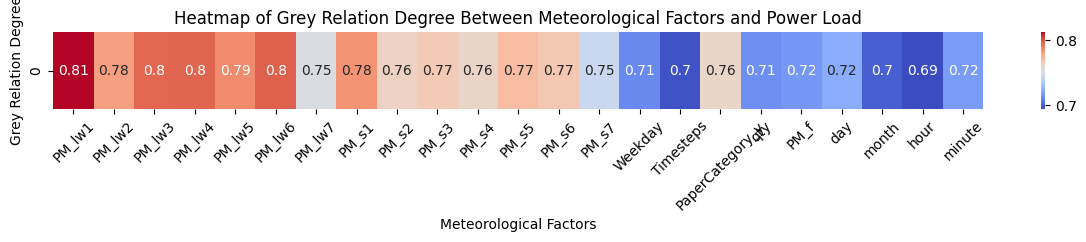

Có nhiều hơn một hàng phù hợp: Index([63360, 63361, 63362, 63363, 63364, 63365, 63366, 63367, 63368, 63369,
       ...
       63638, 63639, 63640, 63641, 63642, 63643, 63644, 63645, 63646, 63647],
      dtype='int64', length=288)
Các ngày tương tự nhất với ngày 1 tháng 6 năm 2024 trong tập train (top 20, sắp xếp theo thời gian):
Ngày tương tự (2023, 7, 28) với khoảng cách: 0.0000
Ngày tương tự (2023, 7, 29) với khoảng cách: 71.9844
Ngày tương tự (2023, 7, 31) với khoảng cách: 74.1537
Ngày tương tự (2023, 8, 3) với khoảng cách: 79.3390
Ngày tương tự (2023, 8, 4) với khoảng cách: 77.7807
Ngày tương tự (2023, 8, 25) với khoảng cách: 77.7995
Ngày tương tự (2023, 10, 12) với khoảng cách: 78.2658
Ngày tương tự (2023, 10, 29) với khoảng cách: 78.7929
Ngày tương tự (2023, 11, 4) với khoảng cách: 75.9906
Ngày tương tự (2023, 11, 16) với khoảng cách: 75.4557
Ngày tương tự (2023, 11, 17) với khoảng cách: 77.0353
Ngày tương tự (2023, 11, 23) với khoảng cách: 67.8181
Ngày tương tự (2023, 11, 25) vớ

/var/folders/cm/nfg3lzjx1yb8gh0lpqtj20zc0000gn/T/ipykernel_2690/3774432895.py:192: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


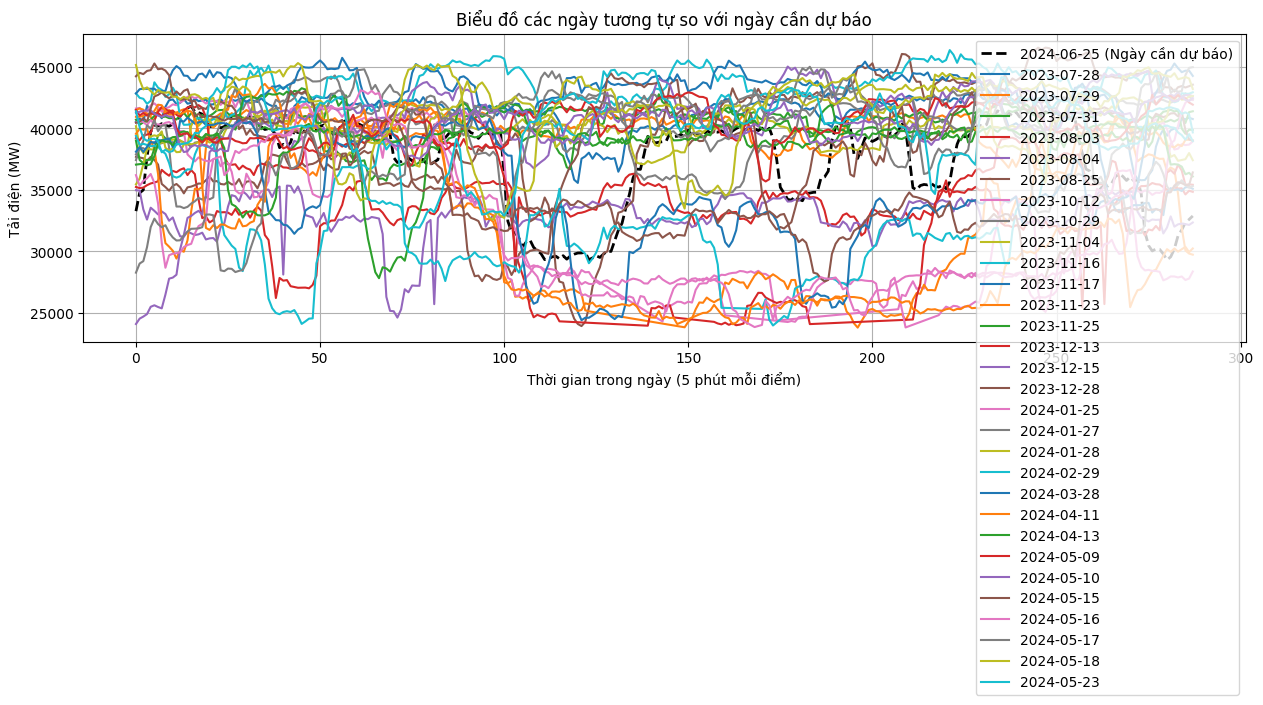

/Users/nguyendinhhuy/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/Users/nguyendinhhuy/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x23 and 17x16)

In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# Đặt seed để đảm bảo tính tái lập của kết quả
random.seed(100)
np.random.seed(100)
torch.manual_seed(100)
torch.cuda.manual_seed(100)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Đọc dữ liệu và chuẩn bị
data = pd.read_csv('/Users/nguyendinhhuy/Desktop/Rolling/testthudataa.csv')
data = data.sort_values(by='Time')

# Chuyển cột Time sang định dạng datetime nếu chưa đúng định dạng
data['Time'] = pd.to_datetime(data['Time'])

# Thêm cột 'year', 'day', và 'month' từ cột 'Time'
data['year'] = data['Time'].dt.year
data['day'] = data['Time'].dt.day
data['month'] = data['Time'].dt.month

# Tính toán số lượng mẫu và chia tỷ lệ cho train và test
total_samples = len(data)
train_percentage = 0.9
test_percentage = 0.1

# Tính kích thước các tập
train_size = int(total_samples * train_percentage)
test_size = total_samples - train_size

# Điều chỉnh kích thước để chia hết cho 288
train_size -= train_size % 288
test_size = total_samples - train_size  # Đảm bảo tổng số mẫu không thay đổi

# Chia dữ liệu thành train và test
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Kiểm tra và lọc các ngày có đủ 288 điểm trong tập train
daily_counts_train = train_data.groupby(['year', 'month', 'day']).size()
complete_days_train = daily_counts_train[daily_counts_train == 288].index

# Lọc dữ liệu chỉ lấy các ngày có đủ 288 điểm từ tập train
train_data = train_data[train_data.set_index(['year', 'month', 'day']).index.isin(complete_days_train)]

# Xác định các đặc trưng và chuỗi chính
encoder_features = ['PM_lw1','PM_lw2', 'PM_lw3', 'PM_lw4', 'PM_lw5', 'PM_lw6', 'PM_lw7',
                    'PM_s1', 'PM_s2', 'PM_s3', 'PM_s4', 'PM_s5', 'PM_s6', 'PM_s7',
                    'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month', 'hour', 'minute']
y_train = train_data[['PM', 'PM_steam']].values

# Chuẩn hóa dữ liệu
scaler_encoder = StandardScaler()
scaler_y = StandardScaler()

X_encoder_train = scaler_encoder.fit_transform(train_data[encoder_features])
y_train = scaler_y.fit_transform(y_train)

# Chuyển đổi sang tensor
X_encoder_train = torch.tensor(X_encoder_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

# Hàm tính hệ số tương quan xám giữa chuỗi chính và các yếu tố trong chuỗi con
def calculate_grey_relation_degree(y, X):
    n_samples, n_features = X.shape
    n_targets = y.shape[1]  # Số cột trong y (chuỗi chính)
    rho = 0.5  # Hệ số phân giải
    grey_relation_matrix = np.zeros((n_samples, n_features, n_targets))

    for j in range(n_targets):  # Lặp qua mỗi cột của chuỗi chính y
        for i in range(n_features):
            delta = np.abs(y[:, j] - X[:, i])
            min_delta = np.min(delta)
            max_delta = np.max(delta)

            # Tính toán hệ số tương quan xám cho mỗi cột của y với từng đặc trưng của X
            grey_relation_matrix[:, i, j] = (min_delta + rho * max_delta) / (delta + rho * max_delta)

    # Trung bình mức độ tương quan xám theo số cột của y để lấy giá trị tổng hợp cho mỗi đặc trưng
    grey_relation_mean = grey_relation_matrix.mean(axis=2)
    
    return grey_relation_mean

# Áp dụng tính toán tương quan xám cho dữ liệu chuẩn hóa của tập train
grey_relation_degrees = calculate_grey_relation_degree(y_train.numpy(), X_encoder_train.numpy())

# Tính mức độ tương quan xám tổng hợp
grey_relation_mean_values = grey_relation_degrees.mean(axis=0)

# Vẽ heatmap của mức độ tương quan xám
grey_relation_df = pd.DataFrame([grey_relation_mean_values], columns=encoder_features)
plt.figure(figsize=(15, 1))
sns.heatmap(grey_relation_df, annot=True, cmap='coolwarm', cbar=True)
plt.title('Heatmap of Grey Relation Degree Between Meteorological Factors and Power Load')
plt.xlabel('Meteorological Factors')
plt.ylabel('Grey Relation Degree')
plt.xticks(rotation=45)
plt.show()

# Xác định chỉ mục của ngày 1 tháng 6 năm 2024 trong tập test
target_day = 25
target_month = 6
target_year = 2024

# Tìm các hàng trong tập test mà có day = 1, month = 6, và year = 2024
target_indices = test_data[(test_data['day'] == target_day) & 
                           (test_data['month'] == target_month) & 
                           (test_data['year'] == target_year)].index

# Kiểm tra nếu có nhiều hơn một hàng thỏa mãn, chọn chỉ số phù hợp
if len(target_indices) > 1:
    print(f"Có nhiều hơn một hàng phù hợp: {target_indices}")
target_day_data = X_encoder_train[target_indices % 288].numpy()  # Lấy 288 điểm của ngày cần dự báo

# Lấy các chỉ số của từng ngày trong tập train
daily_indices_train = [train_data[(train_data['year'] == y) & 
                                  (train_data['month'] == m) & 
                                  (train_data['day'] == d)].index 
                       for y, m, d in complete_days_train]

# Hàm tính khoảng cách Euclid cho toàn bộ 288 điểm của mỗi ngày
def calculate_daily_euclidean_distance(target_day_data, historical_data, daily_indices):
    daily_distances = []
    for indices in daily_indices:
        day_data = historical_data[indices]  # Lấy dữ liệu cho ngày hiện tại (288 điểm)
        distance = np.sqrt(np.sum((day_data - target_day_data) ** 2))  # Tính khoảng cách Euclid
        daily_distances.append(distance)
    
    return np.array(daily_distances)

# Tính khoảng cách Euclid giữa ngày cần dự báo và các ngày trong tập train
distances = calculate_daily_euclidean_distance(target_day_data, X_encoder_train.numpy(), daily_indices_train)

# Bước 4: Sắp xếp và chọn các ngày tương tự nhất từ tập train
sorted_indices = np.argsort(distances)
top_similar_days = [complete_days_train[idx] for idx in sorted_indices[:30]]  # Chọn 20 ngày tương tự nhất từ tập train

# Sắp xếp các ngày tương tự theo thứ tự thời gian
top_similar_days_sorted = sorted(top_similar_days, key=lambda x: (x[0], x[1], x[2]))

# Hiển thị các ngày tương tự nhất từ tập train theo thứ tự thời gian
print("Các ngày tương tự nhất với ngày 1 tháng 6 năm 2024 trong tập train (top 20, sắp xếp theo thời gian):")
for day in top_similar_days_sorted:
    print(f"Ngày tương tự {day} với khoảng cách: {distances[sorted_indices[top_similar_days.index(day)]]:.4f}")

# Kiểm tra và xác nhận các ngày có đủ 288 điểm dữ liệu
valid_days = [day for day in top_similar_days_sorted if len(train_data[(train_data['year'] == day[0]) & 
                                                                       (train_data['month'] == day[1]) & 
                                                                       (train_data['day'] == day[2])]) == 288]

if valid_days:
    print("Các ngày có đủ 288 điểm dữ liệu:")
    for day in valid_days:
        print(f"Ngày {day} trong tập train với khoảng cách: {distances[sorted_indices[top_similar_days.index(day)]]:.4f}")
else:
    print("Không có ngày nào có đủ 288 điểm dữ liệu.")

import matplotlib.pyplot as plt

# Hàm vẽ biểu đồ các ngày tương tự
def plot_similar_days(train_data, similar_days, target_day_data, target_day_label):
    plt.figure(figsize=(15,4))
    
    # Vẽ dữ liệu của ngày cần dự báo
    plt.plot(range(288), target_day_data, label=f'{target_day_label} (Ngày cần dự báo)', linewidth=2, linestyle='--', color='black')
    
    # Vẽ dữ liệu của các ngày tương tự
    for day in similar_days:
        day_data = train_data[(train_data['year'] == day[0]) & 
                              (train_data['month'] == day[1]) & 
                              (train_data['day'] == day[2])]
        load_values = day_data['PM'].values  # Điều chỉnh tên cột nếu cần thiết
        label = f'{day[0]}-{day[1]:02d}-{day[2]:02d}'  # Định dạng ngày tháng năm
        
        plt.plot(range(288), load_values, label=label)
    
    plt.title('Biểu đồ các ngày tương tự so với ngày cần dự báo')
    plt.xlabel('Thời gian trong ngày (5 phút mỗi điểm)')
    plt.ylabel('Tải điện (MW)')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Chuẩn bị dữ liệu của ngày cần dự báo
target_day_label = f'{target_year}-{target_month:02d}-{target_day:02d}'
target_day_load_values = test_data.loc[target_indices, 'PM'].values  # Điều chỉnh tên cột nếu cần thiết

# Gọi hàm vẽ các ngày tương tự
plot_similar_days(train_data, top_similar_days_sorted, target_day_load_values, target_day_label)

# Định nghĩa lớp Encoder cho mô hình Transformer
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, dropout=0.1):
        super(Encoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=8, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.encoder(x)
        return self.norm(x)

# Định nghĩa lớp Decoder cho mô hình Transformer
class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, dropout=0.2):
        super(Decoder, self).__init__()
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=8, dropout=dropout)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)
        self.output_layer = nn.Linear(d_model, 1)  # Output là một scalar cho mỗi thời điểm

    def forward(self, memory, x):
        x = self.decoder(x, memory)
        x = self.norm(x)
        x = self.output_layer(x)
        return x

# Định nghĩa mô hình MultiDeT với hai Decoder cho hai loại tải
class MultiDeT(nn.Module):
    def __init__(self, encoder_layers=1, decoder_layers=1, d_model=16, dropout=0.2):
        super(MultiDeT, self).__init__()
        self.encoder = Encoder(encoder_layers, d_model=d_model, dropout=dropout)
        self.decoder1 = Decoder(decoder_layers, d_model=d_model, dropout=dropout)
        self.decoder2 = Decoder(decoder_layers, d_model=d_model, dropout=dropout)

        self.encoderLinear = nn.Sequential(
            nn.Linear(len(encoder_features), d_model),
            nn.BatchNorm1d(d_model)  # Thêm BatchNorm1d
        )
        self.decoder1_Linear = nn.Sequential(
            nn.Linear(len(pm_features), d_model),
            nn.BatchNorm1d(d_model)  # Thêm BatchNorm1d
        )
        self.decoder2_Linear = nn.Sequential(
            nn.Linear(len(pm_steam_features), d_model),
            nn.BatchNorm1d(d_model)  # Thêm BatchNorm1d
        )

    def forward(self, src, src_dec1, src_dec2):
        encoder_output = self.encoder(self.encoderLinear(src))

        decoder1_output = self.decoder1(encoder_output, self.decoder1_Linear(src_dec1))
        decoder2_output = self.decoder2(encoder_output, self.decoder2_Linear(src_dec2))

        return decoder1_output, decoder2_output

# Khởi tạo mô hình Transformer (MultiDeT)
model = MultiDeT(encoder_layers=1, decoder_layers=1, d_model=16, dropout=0.2)

# Định nghĩa hàm loss và optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-3)  # Sử dụng AdamW optimizer
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=10, verbose=True)

# Hàm huấn luyện mô hình
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=50):
    train_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_enc, X_pm, X_pm_steam, y in train_loader:
            optimizer.zero_grad()
            output1, output2 = model(X_enc, X_pm, X_pm_steam)

            # Reshape outputs to match the target shape
            output1 = output1.view(-1)
            output2 = output2.view(-1)

            # Calculate loss for each output
            loss1 = criterion(output1, y[:, 0])
            loss2 = criterion(output2, y[:, 1])

            # Combine the losses
            loss = 0.8 * loss1 + 0.2 * loss2
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_enc.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

        # Step the scheduler
        scheduler.step(epoch_loss)

    return train_losses

# Chuẩn bị dữ liệu cho mô hình từ các ngày tương tự
similar_day_indices = []

for day in top_similar_days_sorted:
    indices = train_data[(train_data['year'] == day[0]) & 
                         (train_data['month'] == day[1]) & 
                         (train_data['day'] == day[2])].index
    similar_day_indices.extend(indices)

X_encoder_train_similar = X_encoder_train[similar_day_indices]
X_pm_train_similar = X_encoder_train[similar_day_indices]  # Adjust if you have separate features for PM
X_pm_steam_train_similar = X_encoder_train[similar_day_indices]  # Adjust if you have separate features for PM_steam
y_train_similar = y_train[similar_day_indices]

# Tạo TensorDataset cho tập train với các ngày tương tự
train_dataset = TensorDataset(X_encoder_train_similar, X_pm_train_similar, X_pm_steam_train_similar, y_train_similar)

# DataLoader cho tập train
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Huấn luyện mô hình với tập dữ liệu từ các ngày tương tự
train_losses = train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=50)

# Tạo tập test cho đánh giá
X_encoder_test = torch.tensor(scaler_encoder.transform(test_data[encoder_features]), dtype=torch.float32)
X_pm_test = X_encoder_test  # Adjust if you have separate features for PM
X_pm_steam_test = X_encoder_test  # Adjust if you have separate features for PM_steam
y_test = torch.tensor(scaler_y.transform(test_data[['PM', 'PM_steam']]), dtype=torch.float32)

# Tạo TensorDataset cho tập test
test_dataset = TensorDataset(X_encoder_test, X_pm_test, X_pm_steam_test, y_test)

# DataLoader cho tập test
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Đánh giá mô hình với tập test
def evaluate_model(model, test_loader, criterion, scaler_y):
    model.eval()
    test_loss = 0.0
    true_values_pm = []
    true_values_pm_steam = []
    predicted_values_pm = []
    predicted_values_pm_steam = []

    with torch.no_grad():
        for X_enc, X_pm, X_pm_steam, y in test_loader:
            output1, output2 = model(X_enc, X_pm, X_pm_steam)

            # Reshape outputs to match the target shape
            output1 = output1.view(-1)
            output2 = output2.view(-1)

            # Calculate loss for each output
            loss1 = criterion(output1, y[:, 0])
            loss2 = criterion(output2, y[:, 1])
            loss = 0.8 * loss1 + 0.2 * loss2  # Sử dụng cùng trọng số như trong quá trình huấn luyện
            test_loss += loss.item() * X_enc.size(0)

            true_values_pm.extend(y[:, 0].cpu().numpy())
            true_values_pm_steam.extend(y[:, 1].cpu().numpy())
            predicted_values_pm.extend(output1.cpu().numpy())
            predicted_values_pm_steam.extend(output2.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')

    # Convert lists to numpy arrays
    true_values_pm = np.array(true_values_pm)
    true_values_pm_steam = np.array(true_values_pm_steam)
    predicted_values_pm = np.array(predicted_values_pm)
    predicted_values_pm_steam = np.array(predicted_values_pm_steam)

    # Inverse transform the predictions and true values to their original scale
    true_values = scaler_y.inverse_transform(np.vstack((true_values_pm, true_values_pm_steam)).T)
    predicted_values = scaler_y.inverse_transform(np.vstack((predicted_values_pm, predicted_values_pm_steam)).T)

    true_values_pm = true_values[:, 0]
    true_values_pm_steam = true_values[:, 1]
    predicted_values_pm = predicted_values[:, 0]
    predicted_values_pm_steam = predicted_values[:, 1]

    # Calculate Mean Absolute Percentage Error (MAPE)
    mape_pm = np.mean(np.abs((true_values_pm - predicted_values_pm) / true_values_pm)) * 100
    mape_pm_steam = np.mean(np.abs((true_values_pm_steam - predicted_values_pm_steam) / true_values_pm_steam)) * 100

    print(f'MAPE for PM: {mape_pm:.2f}%')
    print(f'MAPE for PM_steam: {mape_pm_steam:.2f}%')

    return true_values_pm, true_values_pm_steam, predicted_values_pm, predicted_values_pm_steam, mape_pm, mape_pm_steam

# Đánh giá mô hình với tập test
true_values_pm, true_values_pm_steam, predicted_values_pm, predicted_values_pm_steam, mape_pm, mape_pm_steam = evaluate_model(model, test_loader, criterion, scaler_y)

# Vẽ biểu đồ dự báo và giá trị thực cho PM
plt.figure(figsize=(15, 3))
plt.plot(true_values_pm, label='True PM')
plt.plot(predicted_values_pm, label='Predicted PM')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel('Time (5-min interval)', fontsize=20)
plt.ylabel('PM (W)', fontsize=20)
plt.title(f'Dự báo PM cho ngày {target_day}/{target_month}/{target_year}', fontsize=20)
plt.legend(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# Vẽ biểu đồ dự báo và giá trị thực cho PM_steam
plt.figure(figsize=(15, 3))
plt.plot(true_values_pm_steam, label='True PM_steam')
plt.plot(predicted_values_pm_steam, label='Predicted PM_steam')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel('Time (5-min interval)', fontsize=20)
plt.ylabel('PM_steam (ton/h)', fontsize=20)
plt.title(f'Dự báo PM_steam cho ngày {target_day}/{target_month}/{target_year}', fontsize=20)
plt.legend(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import random

# Đặt seed để đảm bảo tính tái lập của kết quả
random.seed(100)
np.random.seed(100)
torch.manual_seed(100)
torch.cuda.manual_seed(100)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Giả sử `top_similar_days_sorted` chứa các ngày tương tự đã sắp xếp theo thời gian
# Lấy chỉ số của các ngày tương tự từ tập train
similar_day_indices = []

for day in top_similar_days_sorted:
    indices = train_data[(train_data['year'] == day[0]) & 
                         (train_data['month'] == day[1]) & 
                         (train_data['day'] == day[2])].index
    similar_day_indices.extend(indices)

# Chuẩn bị dữ liệu cho mô hình từ các ngày tương tự
X_encoder_train = X_encoder[similar_day_indices]
X_pm_train = X_pm[similar_day_indices]
X_pm_steam_train = X_pm_steam[similar_day_indices]
y_train = y[similar_day_indices]

# Tạo TensorDataset cho tập train với các ngày tương tự
train_dataset = TensorDataset(torch.tensor(X_encoder_train, dtype=torch.float32),
                              torch.tensor(X_pm_train, dtype=torch.float32),
                              torch.tensor(X_pm_steam_train, dtype=torch.float32),
                              torch.tensor(y_train, dtype=torch.float32))

# DataLoader cho tập train
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Định nghĩa lớp Encoder cho mô hình Transformer
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, dropout=0.1):
        super(Encoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=8, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.encoder(x)
        return self.norm(x)

# Định nghĩa lớp Decoder cho mô hình Transformer
class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, dropout=0.2):
        super(Decoder, self).__init__()
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=8, dropout=dropout)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)
        self.output_layer = nn.Linear(d_model, 1)  # Output là một scalar cho mỗi thời điểm

    def forward(self, memory, x):
        x = self.decoder(x, memory)
        x = self.norm(x)
        x = self.output_layer(x)
        return x

# Định nghĩa mô hình MultiDeT với hai Decoder cho hai loại tải
class MultiDeT(nn.Module):
    def __init__(self, encoder_layers=1, decoder_layers=1, d_model=16, dropout=0.2):
        super(MultiDeT, self).__init__()
        self.encoder = Encoder(encoder_layers, d_model=d_model, dropout=dropout)
        self.decoder1 = Decoder(decoder_layers, d_model=d_model, dropout=dropout)
        self.decoder2 = Decoder(decoder_layers, d_model=d_model, dropout=dropout)

        self.encoderLinear = nn.Sequential(
            nn.Linear(len(encoder_features), d_model),
            nn.BatchNorm1d(d_model)  # Thêm BatchNorm1d
        )
        self.decoder1_Linear = nn.Sequential(
            nn.Linear(len(pm_features), d_model),
            nn.BatchNorm1d(d_model)  # Thêm BatchNorm1d
        )
        self.decoder2_Linear = nn.Sequential(
            nn.Linear(len(pm_steam_features), d_model),
            nn.BatchNorm1d(d_model)  # Thêm BatchNorm1d
        )

    def forward(self, src, src_dec1, src_dec2):
        encoder_output = self.encoder(self.encoderLinear(src))

        decoder1_output = self.decoder1(encoder_output, self.decoder1_Linear(src_dec1))
        decoder2_output = self.decoder2(encoder_output, self.decoder2_Linear(src_dec2))

        return decoder1_output, decoder2_output

# Khởi tạo mô hình Transformer (MultiDeT)
model = MultiDeT(encoder_layers=1, decoder_layers=1, d_model=16, dropout=0.2)

# Định nghĩa hàm loss và optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-3)  # Sử dụng AdamW optimizer
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=10, verbose=True)

# Hàm huấn luyện mô hình
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=50):
    train_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_enc, X_pm, X_pm_steam, y in train_loader:
            optimizer.zero_grad()
            output1, output2 = model(X_enc, X_pm, X_pm_steam)

            # Reshape outputs to match the target shape
            output1 = output1.view(-1)
            output2 = output2.view(-1)

            # Calculate loss for each output
            loss1 = criterion(output1, y[:, 0])
            loss2 = criterion(output2, y[:, 1])

            # Combine the losses
            loss = 0.8 * loss1 + 0.2 * loss2
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_enc.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

        # Step the scheduler
        scheduler.step(epoch_loss)

    return train_losses

# Huấn luyện mô hình với tập dữ liệu từ các ngày tương tự
train_losses = train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=50)

# Tạo tập test cho đánh giá
# Thay đổi phần này để chỉ dự báo cho ngày đã chỉ định trước đó trong tập test
test_day = 25
test_month = 6
test_year = 2024

# Tìm chỉ số của ngày cần dự báo trong tập test
test_indices = test_data[(test_data['day'] == test_day) & 
                        (test_data['month'] == test_month) & 
                        (test_data['year'] == test_year)].index

# Đảm bảo có đủ 288 điểm dữ liệu cho ngày này
if len(test_indices) == 288:
    print(f"Dự báo cho ngày {test_day}/{test_month}/{test_year}")

    # Chuẩn bị dữ liệu cho mô hình từ ngày cần dự báo
    X_encoder_test = X_encoder[test_indices]
    X_pm_test = X_pm[test_indices]
    X_pm_steam_test = X_pm_steam[test_indices]
    y_test = y[test_indices]

    # Tạo TensorDataset cho tập test
    test_dataset = TensorDataset(torch.tensor(X_encoder_test, dtype=torch.float32),
                                 torch.tensor(X_pm_test, dtype=torch.float32),
                                 torch.tensor(X_pm_steam_test, dtype=torch.float32),
                                 torch.tensor(y_test, dtype=torch.float32))

    # DataLoader cho tập test
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Đánh giá mô hình với tập test
    def evaluate_model(model, test_loader, criterion, scaler_y):
        model.eval()
        test_loss = 0.0
        true_values_pm = []
        true_values_pm_steam = []
        predicted_values_pm = []
        predicted_values_pm_steam = []

        with torch.no_grad():
            for X_enc, X_pm, X_pm_steam, y in test_loader:
                output1, output2 = model(X_enc, X_pm, X_pm_steam)

                # Reshape outputs to match the target shape
                output1 = output1.view(-1)
                output2 = output2.view(-1)

                # Calculate loss for each output
                loss1 = criterion(output1, y[:, 0])
                loss2 = criterion(output2, y[:, 1])
                loss = 0.8 * loss1 + 0.2 * loss2  # Sử dụng cùng trọng số như trong quá trình huấn luyện
                test_loss += loss.item() * X_enc.size(0)

                true_values_pm.extend(y[:, 0].cpu().numpy())
                true_values_pm_steam.extend(y[:, 1].cpu().numpy())
                predicted_values_pm.extend(output1.cpu().numpy())
                predicted_values_pm_steam.extend(output2.cpu().numpy())

        test_loss = test_loss / len(test_loader.dataset)
        print(f'Test Loss: {test_loss:.4f}')

        # Convert lists to numpy arrays
        true_values_pm = np.array(true_values_pm)
        true_values_pm_steam = np.array(true_values_pm_steam)
        predicted_values_pm = np.array(predicted_values_pm)
        predicted_values_pm_steam = np.array(predicted_values_pm_steam)

        # Inverse transform the predictions and true values to their original scale
        true_values = scaler_y.inverse_transform(np.vstack((true_values_pm, true_values_pm_steam)).T)
        predicted_values = scaler_y.inverse_transform(np.vstack((predicted_values_pm, predicted_values_pm_steam)).T)

        true_values_pm = true_values[:, 0]
        true_values_pm_steam = true_values[:, 1]
        predicted_values_pm = predicted_values[:, 0]
        predicted_values_pm_steam = predicted_values[:, 1]

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape_pm = np.mean(np.abs((true_values_pm - predicted_values_pm) / true_values_pm)) * 100
        mape_pm_steam = np.mean(np.abs((true_values_pm_steam - predicted_values_pm_steam) / true_values_pm_steam)) * 100

        print(f'MAPE for PM: {mape_pm:.2f}%')
        print(f'MAPE for PM_steam: {mape_pm_steam:.2f}%')

        return true_values_pm, true_values_pm_steam, predicted_values_pm, predicted_values_pm_steam, mape_pm, mape_pm_steam

    # Đánh giá mô hình với tập test
    true_values_pm, true_values_pm_steam, predicted_values_pm, predicted_values_pm_steam, mape_pm, mape_pm_steam = evaluate_model(model, test_loader, criterion, scaler_y)

    # Vẽ biểu đồ dự báo và giá trị thực cho PM
    plt.figure(figsize=(15, 3))
    plt.plot(true_values_pm, label='True PM')
    plt.plot(predicted_values_pm, label='Predicted PM')
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)

    plt.xlabel('Time (5-min interval)', fontsize=20)
    plt.ylabel('PM (W)', fontsize=20)
    plt.title(f'Dự báo PM cho ngày {test_day}/{test_month}/{test_year}')
    plt.legend()
    plt.show()

    # Vẽ biểu đồ dự báo và giá trị thực cho PM_steam
    plt.figure(figsize=(15, 3))
    plt.plot(true_values_pm_steam, label='True PM_steam')
    plt.plot(predicted_values_pm_steam, label='Predicted PM_steam')
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.xlabel('Time (5-min interval)', fontsize=20)
    plt.ylabel('PM_steam (ton/h)', fontsize=20)
    plt.title(f'Dự báo PM_steam cho ngày {test_day}/{test_month}/{test_year}')
    plt.legend()
    plt.show()
else:
    print(f"Không đủ 288 điểm dữ liệu cho ngày {test_day}/{test_month}/{test_year}")


IndentationError: unexpected indent (1853659923.py, line 361)

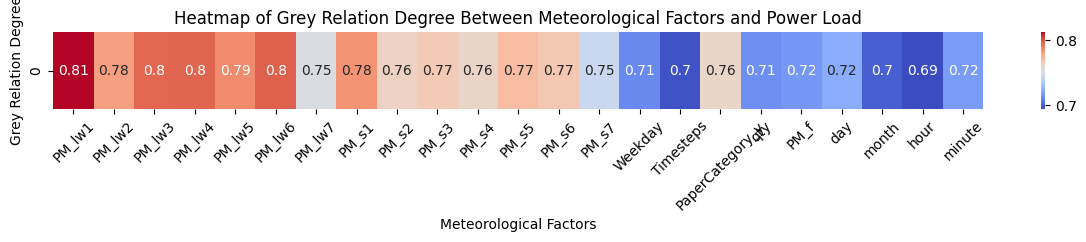

Most similar days to June 25, 2024 in the training set (top 30, sorted chronologically):
Similar day: (2023, 7, 28) with distance: 0.0000
Similar day: (2023, 7, 29) with distance: 71.9844
Similar day: (2023, 7, 31) with distance: 74.1537
Similar day: (2023, 8, 3) with distance: 79.3390
Similar day: (2023, 8, 4) with distance: 77.7807
Similar day: (2023, 8, 25) with distance: 77.7995
Similar day: (2023, 10, 12) with distance: 78.2658
Similar day: (2023, 10, 29) with distance: 78.7929
Similar day: (2023, 11, 4) with distance: 75.9906
Similar day: (2023, 11, 16) with distance: 75.4557
Similar day: (2023, 11, 17) with distance: 77.0353
Similar day: (2023, 11, 23) with distance: 67.8181
Similar day: (2023, 11, 25) with distance: 74.3896
Similar day: (2023, 12, 13) with distance: 75.5421
Similar day: (2023, 12, 15) with distance: 78.1177
Similar day: (2023, 12, 28) with distance: 68.9082
Similar day: (2024, 1, 25) with distance: 78.0345
Similar day: (2024, 1, 27) with distance: 72.3737
Simil

/var/folders/cm/nfg3lzjx1yb8gh0lpqtj20zc0000gn/T/ipykernel_3758/4242511106.py:174: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


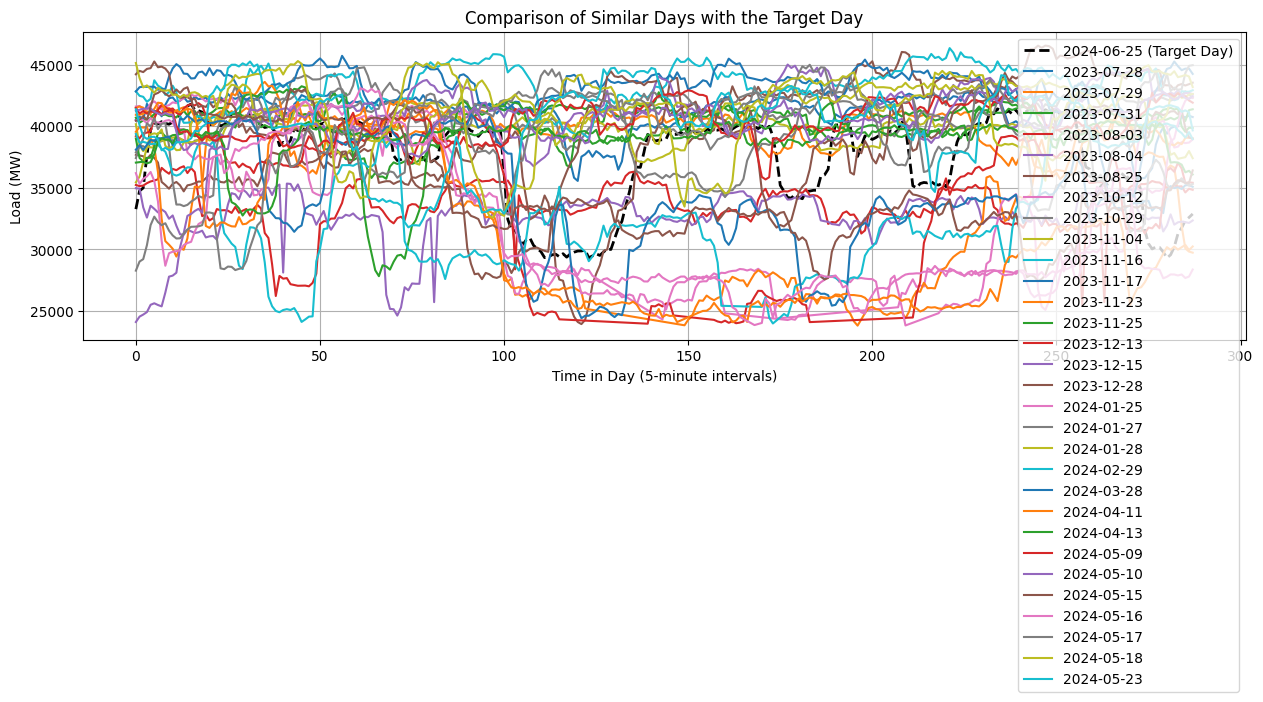

/Users/nguyendinhhuy/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/Users/nguyendinhhuy/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50, Training Loss: 0.7648
Epoch 2/50, Training Loss: 0.6261
Epoch 3/50, Training Loss: 0.5611
Epoch 4/50, Training Loss: 0.5128
Epoch 5/50, Training Loss: 0.4860
Epoch 6/50, Training Loss: 0.4635
Epoch 7/50, Training Loss: 0.4395
Epoch 8/50, Training Loss: 0.4208
Epoch 9/50, Training Loss: 0.4114
Epoch 10/50, Training Loss: 0.3943
Epoch 11/50, Training Loss: 0.3903
Epoch 12/50, Training Loss: 0.3782
Epoch 13/50, Training Loss: 0.3774
Epoch 14/50, Training Loss: 0.3567
Epoch 15/50, Training Loss: 0.3528
Epoch 16/50, Training Loss: 0.3446
Epoch 17/50, Training Loss: 0.3310
Epoch 18/50, Training Loss: 0.3280
Epoch 19/50, Training Loss: 0.3278
Epoch 20/50, Training Loss: 0.3197
Epoch 21/50, Training Loss: 0.3104
Epoch 22/50, Training Loss: 0.3058
Epoch 23/50, Training Loss: 0.3006
Epoch 24/50, Training Loss: 0.2962
Epoch 25/50, Training Loss: 0.2980
Epoch 26/50, Training Loss: 0.2919
Epoch 27/50, Training Loss: 0.2914
Epoch 28/50, Training Loss: 0.2859
Epoch 29/50, Training Loss: 0

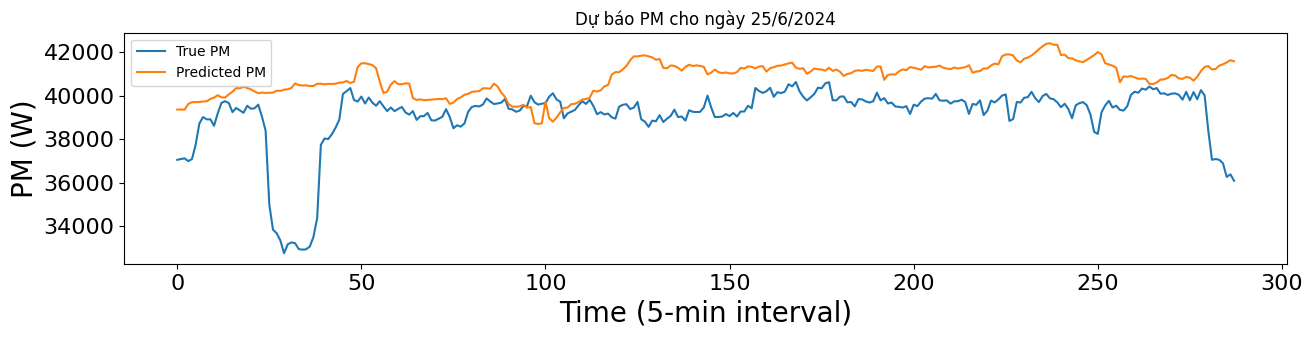

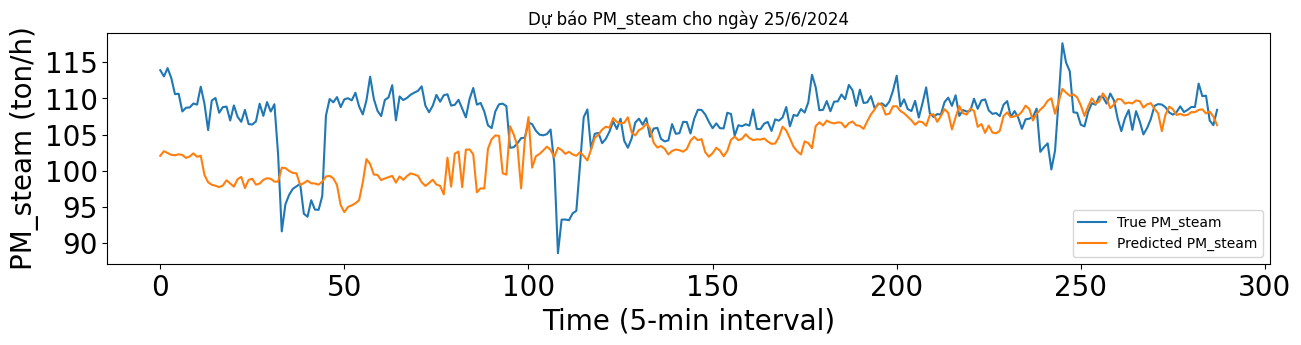

In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
import random
import matplotlib.pyplot as plt
import seaborn as sns

# Set seed for reproducibility
random.seed(100)
np.random.seed(100)
torch.manual_seed(100)
torch.cuda.manual_seed(100)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load and sort data
data = pd.read_csv('/Users/nguyendinhhuy/Desktop/Rolling/testthudataa.csv')
data = data.sort_values(by='Time')

# Convert 'Time' column to datetime format
data['Time'] = pd.to_datetime(data['Time'])

# Extract 'year', 'day', and 'month' from 'Time'
data['year'] = data['Time'].dt.year
data['day'] = data['Time'].dt.day
data['month'] = data['Time'].dt.month

# Split the data into training and testing sets
total_samples = len(data)
train_percentage = 0.9

# Calculate the train and test sizes
train_size = int(total_samples * train_percentage)
train_size -= train_size % 288  # Adjust to ensure it's divisible by 288

# Split the data
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Filter complete days in the training set (288 points per day)
daily_counts_train = train_data.groupby(['year', 'month', 'day']).size()
complete_days_train = daily_counts_train[daily_counts_train == 288].index

# Keep only complete days in the training set
train_data = train_data[train_data.set_index(['year', 'month', 'day']).index.isin(complete_days_train)]

# Define encoder features and scale data
encoder_features = ['PM_lw1', 'PM_lw2', 'PM_lw3', 'PM_lw4', 'PM_lw5', 'PM_lw6', 'PM_lw7',
                    'PM_s1', 'PM_s2', 'PM_s3', 'PM_s4', 'PM_s5', 'PM_s6', 'PM_s7',
                    'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month', 'hour', 'minute']

# Define features for PM and PM_steam
pm_features = ['PM_lw1', 'PM_lw2', 'PM_lw3', 'PM_lw4', 'PM_lw5', 'PM_lw6', 'PM_lw7',
               'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month', 'hour', 'minute', 'PM_s1']
pm_steam_features = ['PM_s1', 'PM_s2', 'PM_s3', 'PM_s4', 'PM_s5', 'PM_s6', 'PM_s7',
                     'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month', 'hour', 'minute', 'PM_lw1']

# Scale features and targets
scaler_encoder = StandardScaler()
scaler_y = StandardScaler()

X_encoder = scaler_encoder.fit_transform(train_data[encoder_features])
X_pm = scaler_encoder.fit_transform(train_data[pm_features])
X_pm_steam = scaler_encoder.fit_transform(train_data[pm_steam_features])
y = scaler_y.fit_transform(train_data[['PM', 'PM_steam']])

# Convert scaled data to PyTorch tensors
X_encoder = torch.tensor(X_encoder, dtype=torch.float32)
X_pm = torch.tensor(X_pm, dtype=torch.float32)
X_pm_steam = torch.tensor(X_pm_steam, dtype=torch.float32)
y_train = torch.tensor(y, dtype=torch.float32)

# Function to calculate grey relational degree
def calculate_grey_relation_degree(y, X):
    n_samples, n_features = X.shape
    n_targets = y.shape[1]  # Number of columns in y
    rho = 0.5  # Resolution coefficient
    grey_relation_matrix = np.zeros((n_samples, n_features, n_targets))

    for j in range(n_targets):  # Loop through each column of y
        for i in range(n_features):
            delta = np.abs(y[:, j] - X[:, i])
            min_delta = np.min(delta)
            max_delta = np.max(delta)

            # Calculate grey relational coefficient for each feature of X with each column of y
            grey_relation_matrix[:, i, j] = (min_delta + rho * max_delta) / (delta + rho * max_delta)

    # Average grey relation degree to get a comprehensive value for each feature
    grey_relation_mean = grey_relation_matrix.mean(axis=2)
    
    return grey_relation_mean

# Apply grey relation degree calculation to normalized train set
grey_relation_degrees = calculate_grey_relation_degree(y_train.numpy(), X_encoder.numpy())

# Calculate comprehensive grey relation degree
grey_relation_mean_values = grey_relation_degrees.mean(axis=0)

# Plot heatmap of grey relation degree
grey_relation_df = pd.DataFrame([grey_relation_mean_values], columns=encoder_features)
plt.figure(figsize=(15, 1))
sns.heatmap(grey_relation_df, annot=True, cmap='coolwarm', cbar=True)
plt.title('Heatmap of Grey Relation Degree Between Meteorological Factors and Power Load')
plt.xlabel('Meteorological Factors')
plt.ylabel('Grey Relation Degree')
plt.xticks(rotation=45)
plt.show()

# Identify indices for target day (June 25, 2024) in the test set
target_day = 25
target_month = 6
target_year = 2024

target_indices = test_data[(test_data['day'] == target_day) & 
                           (test_data['month'] == target_month) & 
                           (test_data['year'] == target_year)].index

# Gather indices for complete days in the training set
daily_indices_train = [train_data[(train_data['year'] == y) & 
                                  (train_data['month'] == m) & 
                                  (train_data['day'] == d)].index 
                       for y, m, d in complete_days_train]

# Function to calculate Euclidean distance for the complete 288 points of each day
def calculate_daily_euclidean_distance(target_day_data, historical_data, daily_indices):
    daily_distances = []
    for indices in daily_indices:
        day_data = historical_data[indices]  # Get data for the current day (288 points)
        distance = np.sqrt(np.sum((day_data - target_day_data) ** 2))  # Calculate Euclidean distance
        daily_distances.append(distance)
    
    return np.array(daily_distances)

# Calculate Euclidean distance between target day and days in the training set
target_day_data = X_encoder[target_indices % 288].numpy()
distances = calculate_daily_euclidean_distance(target_day_data, X_encoder.numpy(), daily_indices_train)

# Sort and select the most similar days from the training set
sorted_indices = np.argsort(distances)
top_similar_days = [complete_days_train[idx] for idx in sorted_indices[:30]]  # Top 30 similar days

# Sort similar days by chronological order
top_similar_days_sorted = sorted(top_similar_days, key=lambda x: (x[0], x[1], x[2]))

# Display most similar days to June 25, 2024
print("Most similar days to June 25, 2024 in the training set (top 30, sorted chronologically):")
for day in top_similar_days_sorted:
    print(f"Similar day: {day} with distance: {distances[sorted_indices[top_similar_days.index(day)]]:.4f}")

# Function to plot similar days
def plot_similar_days(train_data, similar_days, target_day_data, target_day_label):
    plt.figure(figsize=(15, 4))
    
    # Plot data for the target day
    plt.plot(range(288), target_day_data, label=f'{target_day_label} (Target Day)', linewidth=2, linestyle='--', color='black')
    
    # Plot data for each similar day
    for day in similar_days:
        day_data = train_data[(train_data['year'] == day[0]) & 
                              (train_data['month'] == day[1]) & 
                              (train_data['day'] == day[2])]
        load_values = day_data['PM'].values  # Adjust column name if necessary
        label = f'{day[0]}-{day[1]:02d}-{day[2]:02d}'  # Format day-month-year
        
        plt.plot(range(288), load_values, label=label)
    
    plt.title('Comparison of Similar Days with the Target Day')
    plt.xlabel('Time in Day (5-minute intervals)')
    plt.ylabel('Load (MW)')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Prepare data of the target day for plotting
target_day_label = f'{target_year}-{target_month:02d}-{target_day:02d}'
target_day_load_values = test_data.loc[target_indices, 'PM'].values  # Adjust column name if necessary

# Plot similar days
plot_similar_days(train_data, top_similar_days_sorted, target_day_load_values, target_day_label)

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Prepare training data from similar days
similar_day_indices = []
for day in top_similar_days_sorted:
    indices = train_data[(train_data['year'] == day[0]) & 
                         (train_data['month'] == day[1]) & 
                         (train_data['day'] == day[2])].index
    similar_day_indices.extend(indices)

X_encoder_train = X_encoder[similar_day_indices]
X_pm_train = X_pm[similar_day_indices]
X_pm_steam_train = X_pm_steam[similar_day_indices]
y_train = y_train[similar_day_indices]

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(X_encoder_train, X_pm_train, X_pm_steam_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define Encoder for the Transformer model
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, dropout=0.1):
        super(Encoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=8, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.encoder(x)
        return self.norm(x)

# Define Decoder for the Transformer model
class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, dropout=0.2):
        super(Decoder, self).__init__()
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=8, dropout=dropout)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)
        self.output_layer = nn.Linear(d_model, 1)  # Output is a scalar for each time step

    def forward(self, memory, x):
        x = self.decoder(x, memory)
        x = self.norm(x)
        x = self.output_layer(x)
        return x

# Define MultiDeT model with two decoders for two load types
class MultiDeT(nn.Module):
    def __init__(self, encoder_layers=1, decoder_layers=1, d_model=16, dropout=0.2):
        super(MultiDeT, self).__init__()
        self.encoder = Encoder(encoder_layers, d_model=d_model, dropout=dropout)
        self.decoder1 = Decoder(decoder_layers, d_model=d_model, dropout=dropout)
        self.decoder2 = Decoder(decoder_layers, d_model=d_model, dropout=dropout)

        self.encoderLinear = nn.Sequential(
            nn.Linear(len(encoder_features), d_model),
            nn.BatchNorm1d(d_model)
        )
        self.decoder1_Linear = nn.Sequential(
            nn.Linear(X_pm_train.shape[1], d_model),
            nn.BatchNorm1d(d_model)
        )
        self.decoder2_Linear = nn.Sequential(
            nn.Linear(X_pm_steam_train.shape[1], d_model),
            nn.BatchNorm1d(d_model)
        )

    def forward(self, src, src_dec1, src_dec2):
        encoder_output = self.encoder(self.encoderLinear(src))

        decoder1_output = self.decoder1(encoder_output, self.decoder1_Linear(src_dec1))
        decoder2_output = self.decoder2(encoder_output, self.decoder2_Linear(src_dec2))

        return decoder1_output, decoder2_output

# Initialize model, loss function, optimizer, and scheduler
model = MultiDeT(encoder_layers=1, decoder_layers=1, d_model=16, dropout=0.2)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=10, verbose=True)

# Function to train the model
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=50):
    train_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_enc, X_pm, X_pm_steam, y in train_loader:
            optimizer.zero_grad()
            output1, output2 = model(X_enc, X_pm, X_pm_steam)

            # Reshape outputs to match the target shape
            output1 = output1.view(-1)
            output2 = output2.view(-1)

            # Calculate loss for each output
            loss1 = criterion(output1, y[:, 0])
            loss2 = criterion(output2, y[:, 1])

            # Combine the losses
            loss = 0.8 * loss1 + 0.2 * loss2
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_enc.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

        # Step the scheduler
        scheduler.step(epoch_loss)

    return train_losses

# Train the model
train_losses = train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=50)

import matplotlib.pyplot as plt

# Prepare the test set for evaluation (targeting June 25, 2024)
test_day = 25
test_month = 6
test_year = 2024

# Ensure indices within bounds by aligning indices with data shapes
# Extract test day indices based on relative positions within the testing set
test_indices = test_data[(test_data['day'] == test_day) & 
                         (test_data['month'] == test_month) & 
                         (test_data['year'] == test_year)].index

# Adjust indices if necessary
# Ensure indices are within the bounds of the tensors by mapping the indices correctly
relative_test_indices = [i for i in test_indices if i < len(X_encoder)]  # Adjust as needed

if len(relative_test_indices) == 288:
    print(f"Dự báo cho ngày {test_day}/{test_month}/{test_year}")

    # Prepare test data for the model using valid indices
    X_encoder_test = X_encoder[relative_test_indices]
    X_pm_test = X_pm[relative_test_indices]
    X_pm_steam_test = X_pm_steam[relative_test_indices]
    y_test = y_train[relative_test_indices]

    # Create DataLoader for test data
    test_dataset = TensorDataset(X_encoder_test, X_pm_test, X_pm_steam_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Function to evaluate the model
    def evaluate_model(model, test_loader, criterion, scaler_y):
        model.eval()
        test_loss = 0.0
        true_values_pm = []
        true_values_pm_steam = []
        predicted_values_pm = []
        predicted_values_pm_steam = []

        with torch.no_grad():
            for X_enc, X_pm, X_pm_steam, y in test_loader:
                output1, output2 = model(X_enc, X_pm, X_pm_steam)

                # Reshape outputs to match the target shape
                output1 = output1.view(-1)
                output2 = output2.view(-1)

                # Calculate loss for each output
                loss1 = criterion(output1, y[:, 0])
                loss2 = criterion(output2, y[:, 1])
                loss = 0.8 * loss1 + 0.2 * loss2
                test_loss += loss.item() * X_enc.size(0)

                true_values_pm.extend(y[:, 0].cpu().numpy())
                true_values_pm_steam.extend(y[:, 1].cpu().numpy())
                predicted_values_pm.extend(output1.cpu().numpy())
                predicted_values_pm_steam.extend(output2.cpu().numpy())

        test_loss = test_loss / len(test_loader.dataset)
        print(f'Test Loss: {test_loss:.4f}')

        # Convert lists to numpy arrays
        true_values_pm = np.array(true_values_pm)
        true_values_pm_steam = np.array(true_values_pm_steam)
        predicted_values_pm = np.array(predicted_values_pm)
        predicted_values_pm_steam = np.array(predicted_values_pm_steam)

        # Inverse transform the predictions and true values to their original scale
        true_values = scaler_y.inverse_transform(np.vstack((true_values_pm, true_values_pm_steam)).T)
        predicted_values = scaler_y.inverse_transform(np.vstack((predicted_values_pm, predicted_values_pm_steam)).T)

        true_values_pm = true_values[:, 0]
        true_values_pm_steam = true_values[:, 1]
        predicted_values_pm = predicted_values[:, 0]
        predicted_values_pm_steam = predicted_values[:, 1]

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape_pm = np.mean(np.abs((true_values_pm - predicted_values_pm) / true_values_pm)) * 100
        mape_pm_steam = np.mean(np.abs((true_values_pm_steam - predicted_values_pm_steam) / true_values_pm_steam)) * 100

        print(f'MAPE for PM: {mape_pm:.2f}%')
        print(f'MAPE for PM_steam: {mape_pm_steam:.2f}%')

        return true_values_pm, true_values_pm_steam, predicted_values_pm, predicted_values_pm_steam, mape_pm, mape_pm_steam

    # Evaluate the model on the test set
    true_values_pm, true_values_pm_steam, predicted_values_pm, predicted_values_pm_steam, mape_pm, mape_pm_steam = evaluate_model(model, test_loader, criterion, scaler_y)

    # Plot predictions vs. true values for PM
    plt.figure(figsize=(15, 3))
    plt.plot(true_values_pm, label='True PM')
    plt.plot(predicted_values_pm, label='Predicted PM')
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    plt.xlabel('Time (5-min interval)', fontsize=20)
    plt.ylabel('PM (W)', fontsize=20)
    plt.title(f'Dự báo PM cho ngày {test_day}/{test_month}/{test_year}')
    plt.legend()
    plt.show()

    # Plot predictions vs. true values for PM_steam
    plt.figure(figsize=(15, 3))
    plt.plot(true_values_pm_steam, label='True PM_steam')
    plt.plot(predicted_values_pm_steam, label='Predicted PM_steam')
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.xlabel('Time (5-min interval)', fontsize=20)
    plt.ylabel('PM_steam (ton/h)', fontsize=20)
    plt.title(f'Dự báo PM_steam cho ngày {test_day}/{test_month}/{test_year}')
    plt.legend()
    plt.show()
else:
    print(f"Không đủ 288 điểm dữ liệu cho ngày {test_day}/{test_month}/{test_year} hoặc các chỉ số vượt quá giới hạn của tensor.")

import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Define date variables
test_day = 25
test_month = 6
test_year = 2024

# Extract test day data from the test dataframe
target_day_data = test_data[(test_data['day'] == test_day) & 
                            (test_data['month'] == test_month) & 
                            (test_data['year'] == test_year)]

# Check if the target day has exactly 288 data points
if len(target_day_data) < 288:
    print(f"Ngày {test_day}/{test_month}/{test_year} không có đủ 288 điểm dữ liệu.")
else:
    print(f"Ngày {test_day}/{test_month}/{test_year} có đủ 288 điểm dữ liệu.")

    # Get the starting index of the test data within the full dataset
    test_data_start_index = test_data.index[0]
    
    # Calculate relative indices within the test data for the target day
    relative_test_indices = target_day_data.index - test_data_start_index
    
    # Validate indices are within bounds
    relative_test_indices = relative_test_indices[relative_test_indices < len(X_encoder)]

    # Check again if we have exactly 288 indices
    if len(relative_test_indices) == 288:
        print(f"Dự báo cho ngày {test_day}/{test_month}/{test_year}")
        
        # Prepare test data using the relative indices
        X_encoder_test = X_encoder[relative_test_indices]
        X_pm_test = X_pm[relative_test_indices]
        X_pm_steam_test = X_pm_steam[relative_test_indices]
        y_test = y_train[relative_test_indices]

        # Create DataLoader for test data
        test_dataset = TensorDataset(X_encoder_test, X_pm_test, X_pm_steam_test, y_test)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        # Define function to evaluate the model
        def evaluate_model(model, test_loader, criterion, scaler_y):
            model.eval()
            test_loss = 0.0
            true_values_pm = []
            true_values_pm_steam = []
            predicted_values_pm = []
            predicted_values_pm_steam = []

            with torch.no_grad():
                for X_enc, X_pm, X_pm_steam, y in test_loader:
                    output1, output2 = model(X_enc, X_pm, X_pm_steam)

                    # Reshape outputs to match the target shape
                    output1 = output1.view(-1)
                    output2 = output2.view(-1)

                    # Calculate loss for each output
                    loss1 = criterion(output1, y[:, 0])
                    loss2 = criterion(output2, y[:, 1])
                    loss = 0.8 * loss1 + 0.2 * loss2
                    test_loss += loss.item() * X_enc.size(0)

                    true_values_pm.extend(y[:, 0].cpu().numpy())
                    true_values_pm_steam.extend(y[:, 1].cpu().numpy())
                    predicted_values_pm.extend(output1.cpu().numpy())
                    predicted_values_pm_steam.extend(output2.cpu().numpy())

            test_loss = test_loss / len(test_loader.dataset)
            print(f'Test Loss: {test_loss:.4f}')

            # Convert lists to numpy arrays
            true_values_pm = np.array(true_values_pm)
            true_values_pm_steam = np.array(true_values_pm_steam)
            predicted_values_pm = np.array(predicted_values_pm)
            predicted_values_pm_steam = np.array(predicted_values_pm_steam)

            # Inverse transform the predictions and true values to their original scale
            true_values = scaler_y.inverse_transform(np.vstack((true_values_pm, true_values_pm_steam)).T)
            predicted_values = scaler_y.inverse_transform(np.vstack((predicted_values_pm, predicted_values_pm_steam)).T)

            true_values_pm = true_values[:, 0]
            true_values_pm_steam = true_values[:, 1]
            predicted_values_pm = predicted_values[:, 0]
            predicted_values_pm_steam = predicted_values[:, 1]

            # Calculate Mean Absolute Percentage Error (MAPE)
            mape_pm = np.mean(np.abs((true_values_pm - predicted_values_pm) / true_values_pm)) * 100
            mape_pm_steam = np.mean(np.abs((true_values_pm_steam - predicted_values_pm_steam) / true_values_pm_steam)) * 100

            print(f'MAPE for PM: {mape_pm:.2f}%')
            print(f'MAPE for PM_steam: {mape_pm_steam:.2f}%')

            return true_values_pm, true_values_pm_steam, predicted_values_pm, predicted_values_pm_steam, mape_pm, mape_pm_steam

        # Evaluate the model on the test set
        true_values_pm, true_values_pm_steam, predicted_values_pm, predicted_values_pm_steam, mape_pm, mape_pm_steam = evaluate_model(model, test_loader, criterion, scaler_y)

        # Plot predictions vs. true values for PM
        plt.figure(figsize=(15, 3))
        plt.plot(true_values_pm, label='True PM')
        plt.plot(predicted_values_pm, label='Predicted PM')
        plt.yticks(fontsize=16)
        plt.xticks(fontsize=16)
        plt.xlabel('Time (5-min interval)', fontsize=20)
        plt.ylabel('PM (W)', fontsize=20)
        plt.title(f'Dự báo PM cho ngày {test_day}/{test_month}/{test_year}')
        plt.legend()
        plt.show()

        # Plot predictions vs. true values for PM_steam
        plt.figure(figsize=(15, 3))
        plt.plot(true_values_pm_steam, label='True PM_steam')
        plt.plot(predicted_values_pm_steam, label='Predicted PM_steam')
        plt.yticks(fontsize=20)
        plt.xticks(fontsize=20)
        plt.xlabel('Time (5-min interval)', fontsize=20)
        plt.ylabel('PM_steam (ton/h)', fontsize=20)
        plt.title(f'Dự báo PM_steam cho ngày {test_day}/{test_month}/{test_year}')
        plt.legend()
        plt.show()
    else:
        print(f"Không đủ 288 điểm dữ liệu cho ngày {test_day}/{test_month}/{test_year} hoặc các chỉ số vượt quá giới hạn của tensor.")

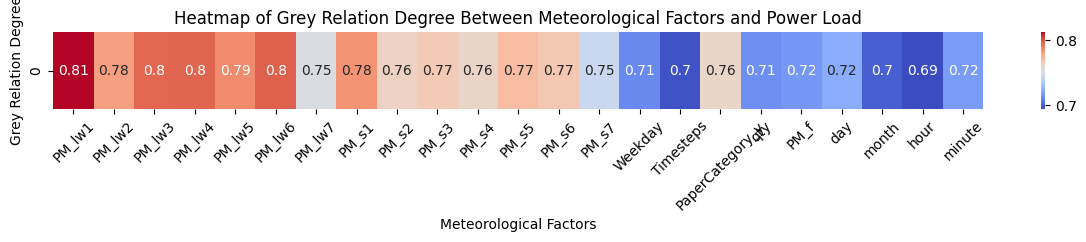

Most similar days to June 25, 2024 in the training set (top 30, sorted chronologically):
Similar day: (2023, 7, 28) with distance: 0.0000
Similar day: (2023, 7, 29) with distance: 71.9844
Similar day: (2023, 7, 31) with distance: 74.1537
Similar day: (2023, 8, 3) with distance: 79.3390
Similar day: (2023, 8, 4) with distance: 77.7807
Similar day: (2023, 8, 25) with distance: 77.7995
Similar day: (2023, 10, 12) with distance: 78.2658
Similar day: (2023, 10, 29) with distance: 78.7929
Similar day: (2023, 11, 4) with distance: 75.9906
Similar day: (2023, 11, 16) with distance: 75.4557
Similar day: (2023, 11, 17) with distance: 77.0353
Similar day: (2023, 11, 23) with distance: 67.8181
Similar day: (2023, 11, 25) with distance: 74.3896
Similar day: (2023, 12, 13) with distance: 75.5421
Similar day: (2023, 12, 15) with distance: 78.1177
Similar day: (2023, 12, 28) with distance: 68.9082
Similar day: (2024, 1, 25) with distance: 78.0345
Similar day: (2024, 1, 27) with distance: 72.3737
Simil

/var/folders/cm/nfg3lzjx1yb8gh0lpqtj20zc0000gn/T/ipykernel_3758/2484405266.py:174: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


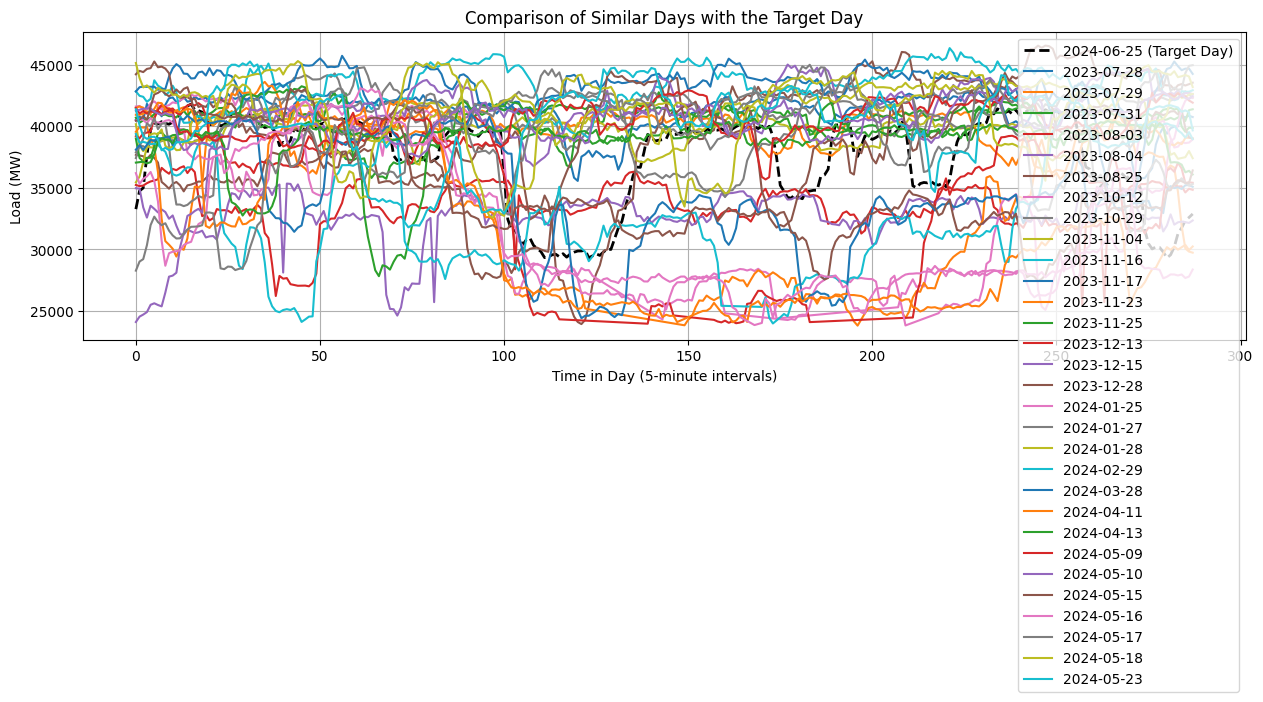

/Users/nguyendinhhuy/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/Users/nguyendinhhuy/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50, Training Loss: 0.7648
Epoch 2/50, Training Loss: 0.6261
Epoch 3/50, Training Loss: 0.5611
Epoch 4/50, Training Loss: 0.5128
Epoch 5/50, Training Loss: 0.4860
Epoch 6/50, Training Loss: 0.4635
Epoch 7/50, Training Loss: 0.4395
Epoch 8/50, Training Loss: 0.4208
Epoch 9/50, Training Loss: 0.4114
Epoch 10/50, Training Loss: 0.3943
Epoch 11/50, Training Loss: 0.3903
Epoch 12/50, Training Loss: 0.3782
Epoch 13/50, Training Loss: 0.3774
Epoch 14/50, Training Loss: 0.3567
Epoch 15/50, Training Loss: 0.3528
Epoch 16/50, Training Loss: 0.3446
Epoch 17/50, Training Loss: 0.3310
Epoch 18/50, Training Loss: 0.3280
Epoch 19/50, Training Loss: 0.3278
Epoch 20/50, Training Loss: 0.3197
Epoch 21/50, Training Loss: 0.3104
Epoch 22/50, Training Loss: 0.3058
Epoch 23/50, Training Loss: 0.3006
Epoch 24/50, Training Loss: 0.2962
Epoch 25/50, Training Loss: 0.2980
Epoch 26/50, Training Loss: 0.2919
Epoch 27/50, Training Loss: 0.2914
Epoch 28/50, Training Loss: 0.2859
Epoch 29/50, Training Loss: 0

In [15]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
import random
import matplotlib.pyplot as plt
import seaborn as sns

# Set seed for reproducibility
random.seed(100)
np.random.seed(100)
torch.manual_seed(100)
torch.cuda.manual_seed(100)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load and sort data
data = pd.read_csv('/Users/nguyendinhhuy/Desktop/Rolling/testthudataa.csv')
data = data.sort_values(by='Time')

# Convert 'Time' column to datetime format
data['Time'] = pd.to_datetime(data['Time'])

# Extract 'year', 'day', and 'month' from 'Time'
data['year'] = data['Time'].dt.year
data['day'] = data['Time'].dt.day
data['month'] = data['Time'].dt.month

# Split the data into training and testing sets
total_samples = len(data)
train_percentage = 0.9

# Calculate the train and test sizes
train_size = int(total_samples * train_percentage)
train_size -= train_size % 288  # Adjust to ensure it's divisible by 288

# Split the data
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Filter complete days in the training set (288 points per day)
daily_counts_train = train_data.groupby(['year', 'month', 'day']).size()
complete_days_train = daily_counts_train[daily_counts_train == 288].index

# Keep only complete days in the training set
train_data = train_data[train_data.set_index(['year', 'month', 'day']).index.isin(complete_days_train)]

# Define encoder features and scale data
encoder_features = ['PM_lw1', 'PM_lw2', 'PM_lw3', 'PM_lw4', 'PM_lw5', 'PM_lw6', 'PM_lw7',
                    'PM_s1', 'PM_s2', 'PM_s3', 'PM_s4', 'PM_s5', 'PM_s6', 'PM_s7',
                    'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month', 'hour', 'minute']

# Define features for PM and PM_steam
pm_features = ['PM_lw1', 'PM_lw2', 'PM_lw3', 'PM_lw4', 'PM_lw5', 'PM_lw6', 'PM_lw7',
               'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month', 'hour', 'minute', 'PM_s1']
pm_steam_features = ['PM_s1', 'PM_s2', 'PM_s3', 'PM_s4', 'PM_s5', 'PM_s6', 'PM_s7',
                     'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month', 'hour', 'minute', 'PM_lw1']

# Scale features and targets
scaler_encoder = StandardScaler()
scaler_y = StandardScaler()

X_encoder = scaler_encoder.fit_transform(train_data[encoder_features])
X_pm = scaler_encoder.fit_transform(train_data[pm_features])
X_pm_steam = scaler_encoder.fit_transform(train_data[pm_steam_features])
y = scaler_y.fit_transform(train_data[['PM', 'PM_steam']])

# Convert scaled data to PyTorch tensors
X_encoder_tensor = torch.tensor(X_encoder, dtype=torch.float32)
X_pm_tensor = torch.tensor(X_pm, dtype=torch.float32)
X_pm_steam_tensor = torch.tensor(X_pm_steam, dtype=torch.float32)
y_train_tensor = torch.tensor(y, dtype=torch.float32)

# Function to calculate grey relational degree
def calculate_grey_relation_degree(y, X):
    n_samples, n_features = X.shape
    n_targets = y.shape[1]  # Number of columns in y
    rho = 0.5  # Resolution coefficient
    grey_relation_matrix = np.zeros((n_samples, n_features, n_targets))

    for j in range(n_targets):  # Loop through each column of y
        for i in range(n_features):
            delta = np.abs(y[:, j] - X[:, i])
            min_delta = np.min(delta)
            max_delta = np.max(delta)

            # Calculate grey relational coefficient for each feature of X with each column of y
            grey_relation_matrix[:, i, j] = (min_delta + rho * max_delta) / (delta + rho * max_delta)

    # Average grey relation degree to get a comprehensive value for each feature
    grey_relation_mean = grey_relation_matrix.mean(axis=2)
    
    return grey_relation_mean

# Apply grey relation degree calculation to normalized train set
grey_relation_degrees = calculate_grey_relation_degree(y_train_tensor.numpy(), X_encoder_tensor.numpy())

# Calculate comprehensive grey relation degree
grey_relation_mean_values = grey_relation_degrees.mean(axis=0)

# Plot heatmap of grey relation degree
grey_relation_df = pd.DataFrame([grey_relation_mean_values], columns=encoder_features)
plt.figure(figsize=(15, 1))
sns.heatmap(grey_relation_df, annot=True, cmap='coolwarm', cbar=True)
plt.title('Heatmap of Grey Relation Degree Between Meteorological Factors and Power Load')
plt.xlabel('Meteorological Factors')
plt.ylabel('Grey Relation Degree')
plt.xticks(rotation=45)
plt.show()

# Identify indices for target day (June 25, 2024) in the test set
target_day = 25
target_month = 6
target_year = 2024

target_indices = test_data[(test_data['day'] == target_day) & 
                           (test_data['month'] == target_month) & 
                           (test_data['year'] == target_year)].index

# Gather indices for complete days in the training set
daily_indices_train = [train_data[(train_data['year'] == y) & 
                                  (train_data['month'] == m) & 
                                  (train_data['day'] == d)].index 
                       for y, m, d in complete_days_train]

# Function to calculate Euclidean distance for the complete 288 points of each day
def calculate_daily_euclidean_distance(target_day_data, historical_data, daily_indices):
    daily_distances = []
    for indices in daily_indices:
        day_data = historical_data[indices]  # Get data for the current day (288 points)
        distance = np.sqrt(np.sum((day_data - target_day_data) ** 2))  # Calculate Euclidean distance
        daily_distances.append(distance)
    
    return np.array(daily_distances)

# Calculate Euclidean distance between target day and days in the training set
target_day_data = X_encoder_tensor[target_indices % 288].numpy()
distances = calculate_daily_euclidean_distance(target_day_data, X_encoder_tensor.numpy(), daily_indices_train)

# Sort and select the most similar days from the training set
sorted_indices = np.argsort(distances)
top_similar_days = [complete_days_train[idx] for idx in sorted_indices[:30]]  # Top 30 similar days

# Sort similar days by chronological order
top_similar_days_sorted = sorted(top_similar_days, key=lambda x: (x[0], x[1], x[2]))

# Display most similar days to June 25, 2024
print("Most similar days to June 25, 2024 in the training set (top 30, sorted chronologically):")
for day in top_similar_days_sorted:
    print(f"Similar day: {day} with distance: {distances[sorted_indices[top_similar_days.index(day)]]:.4f}")

# Function to plot similar days
def plot_similar_days(train_data, similar_days, target_day_data, target_day_label):
    plt.figure(figsize=(15, 4))
    
    # Plot data for the target day
    plt.plot(range(288), target_day_data, label=f'{target_day_label} (Target Day)', linewidth=2, linestyle='--', color='black')
    
    # Plot data for each similar day
    for day in similar_days:
        day_data = train_data[(train_data['year'] == day[0]) & 
                              (train_data['month'] == day[1]) & 
                              (train_data['day'] == day[2])]
        load_values = day_data['PM'].values  # Adjust column name if necessary
        label = f'{day[0]}-{day[1]:02d}-{day[2]:02d}'  # Format day-month-year
        
        plt.plot(range(288), load_values, label=label)
    
    plt.title('Comparison of Similar Days with the Target Day')
    plt.xlabel('Time in Day (5-minute intervals)')
    plt.ylabel('Load (MW)')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Prepare data of the target day for plotting
target_day_label = f'{target_year}-{target_month:02d}-{target_day:02d}'
target_day_load_values = test_data.loc[target_indices, 'PM'].values  # Adjust column name if necessary

# Plot similar days
plot_similar_days(train_data, top_similar_days_sorted, target_day_load_values, target_day_label)

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Prepare training data from similar days
similar_day_indices = []
for day in top_similar_days_sorted:
    indices = train_data[(train_data['year'] == day[0]) & 
                         (train_data['month'] == day[1]) & 
                         (train_data['day'] == day[2])].index
    similar_day_indices.extend(indices)

X_encoder_train = X_encoder_tensor[similar_day_indices]
X_pm_train = X_pm_tensor[similar_day_indices]
X_pm_steam_train = X_pm_steam_tensor[similar_day_indices]
y_train = y_train_tensor[similar_day_indices]

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(X_encoder_train, X_pm_train, X_pm_steam_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define Encoder for the Transformer model
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, dropout=0.1):
        super(Encoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=8, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.encoder(x)
        return self.norm(x)

# Define Decoder for the Transformer model
class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, dropout=0.2):
        super(Decoder, self).__init__()
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=8, dropout=dropout)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)
        self.output_layer = nn.Linear(d_model, 1)  # Output is a scalar for each time step

    def forward(self, memory, x):
        x = self.decoder(x, memory)
        x = self.norm(x)
        x = self.output_layer(x)
        return x

# Define MultiDeT model with two decoders for two load types
class MultiDeT(nn.Module):
    def __init__(self, encoder_layers=1, decoder_layers=1, d_model=16, dropout=0.2):
        super(MultiDeT, self).__init__()
        self.encoder = Encoder(encoder_layers, d_model=d_model, dropout=dropout)
        self.decoder1 = Decoder(decoder_layers, d_model=d_model, dropout=dropout)
        self.decoder2 = Decoder(decoder_layers, d_model=d_model, dropout=dropout)

        self.encoderLinear = nn.Sequential(
            nn.Linear(len(encoder_features), d_model),
            nn.BatchNorm1d(d_model)
        )
        self.decoder1_Linear = nn.Sequential(
            nn.Linear(X_pm_train.shape[1], d_model),
            nn.BatchNorm1d(d_model)
        )
        self.decoder2_Linear = nn.Sequential(
            nn.Linear(X_pm_steam_train.shape[1], d_model),
            nn.BatchNorm1d(d_model)
        )

    def forward(self, src, src_dec1, src_dec2):
        encoder_output = self.encoder(self.encoderLinear(src))

        decoder1_output = self.decoder1(encoder_output, self.decoder1_Linear(src_dec1))
        decoder2_output = self.decoder2(encoder_output, self.decoder2_Linear(src_dec2))

        return decoder1_output, decoder2_output

# Initialize model, loss function, optimizer, and scheduler
model = MultiDeT(encoder_layers=1, decoder_layers=1, d_model=16, dropout=0.2)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=10, verbose=True)

# Function to train the model
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=50):
    train_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_enc, X_pm, X_pm_steam, y in train_loader:
            optimizer.zero_grad()
            output1, output2 = model(X_enc, X_pm, X_pm_steam)

            # Reshape outputs to match the target shape
            output1 = output1.view(-1)
            output2 = output2.view(-1)

            # Calculate loss for each output
            loss1 = criterion(output1, y[:, 0])
            loss2 = criterion(output2, y[:, 1])

            # Combine the losses
            loss = 0.8 * loss1 + 0.2 * loss2
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_enc.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

        # Step the scheduler
        scheduler.step(epoch_loss)

    return train_losses

# Train the model
train_losses = train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=50)

import matplotlib.pyplot as plt

# Prepare the test set for evaluation (targeting June 25, 2024)
test_day = 25
test_month = 6
test_year = 2024

# Ensure indices within bounds by aligning indices with data shapes
# Extract test day indices based on relative positions within the testing set
test_indices = test_data[(test_data['day'] == test_day) & 
                         (test_data['month'] == test_month) & 
                         (test_data['year'] == test_year)].index

# Adjust indices if necessary
# Ensure indices are within the bounds of the tensors by mapping the indices correctly
relative_test_indices = [i for i in test_indices if i < len(X_encoder_tensor)]  # Adjust as needed

if len(relative_test_indices) == 288:
    print(f"Dự báo cho ngày {test_day}/{test_month}/{test_year}")

    # Prepare test data for the model using valid indices
    X_encoder_test = X_encoder_tensor[relative_test_indices]
    X_pm_test = X_pm_tensor[relative_test_indices]
    X_pm_steam_test = X_pm_steam_tensor[relative_test_indices]
    y_test = y_train_tensor[relative_test_indices]

    # Create DataLoader for test data
    test_dataset = TensorDataset(X_encoder_test, X_pm_test, X_pm_steam_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Function to evaluate the model
    def evaluate_model(model, test_loader, criterion, scaler_y):
        model.eval()
        test_loss = 0.0
        true_values_pm = []
        true_values_pm_steam = []
        predicted_values_pm = []
        predicted_values_pm_steam = []

        with torch.no_grad():
            for X_enc, X_pm, X_pm_steam, y in test_loader:
                output1, output2 = model(X_enc, X_pm, X_pm_steam)

                # Reshape outputs to match the target shape
                output1 = output1.view(-1)
                output2 = output2.view(-1)

                # Calculate loss for each output
                loss1 = criterion(output1, y[:, 0])
                loss2 = criterion(output2, y[:, 1])
                loss = 0.8 * loss1 + 0.2 * loss2
                test_loss += loss.item() * X_enc.size(0)

                true_values_pm.extend(y[:, 0].cpu().numpy())
                true_values_pm_steam.extend(y[:, 1].cpu().numpy())
                predicted_values_pm.extend(output1.cpu().numpy())
                predicted_values_pm_steam.extend(output2.cpu().numpy())

        test_loss = test_loss / len(test_loader.dataset)
        print(f'Test Loss: {test_loss:.4f}')

        # Convert lists to numpy arrays
        true_values_pm = np.array(true_values_pm)
        true_values_pm_steam = np.array(true_values_pm_steam)
        predicted_values_pm = np.array(predicted_values_pm)
        predicted_values_pm_steam = np.array(predicted_values_pm_steam)

        # Inverse transform the predictions and true values to their original scale
        true_values = scaler_y.inverse_transform(np.vstack((true_values_pm, true_values_pm_steam)).T)
        predicted_values = scaler_y.inverse_transform(np.vstack((predicted_values_pm, predicted_values_pm_steam)).T)

        true_values_pm = true_values[:, 0]
        true_values_pm_steam = true_values[:, 1]
        predicted_values_pm = predicted_values[:, 0]
        predicted_values_pm_steam = predicted_values[:, 1]

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape_pm = np.mean(np.abs((true_values_pm - predicted_values_pm) / true_values_pm)) * 100
        mape_pm_steam = np.mean(np.abs((true_values_pm_steam - predicted_values_pm_steam) / true_values_pm_steam)) * 100

        print(f'MAPE for PM: {mape_pm:.2f}%')
        print(f'MAPE for PM_steam: {mape_pm_steam:.2f}%')

        return true_values_pm, true_values_pm_steam, predicted_values_pm, predicted_values_pm_steam, mape_pm, mape_pm_steam

    # Evaluate the model on the test set
    true_values_pm, true_values_pm_steam, predicted_values_pm, predicted_values_pm_steam, mape_pm, mape_pm_steam = evaluate_model(model, test_loader, criterion, scaler_y)

    # Plot predictions vs. true values for PM
    plt.figure(figsize=(15, 3))
    plt.plot(true_values_pm, label='True PM')
    plt.plot(predicted_values_pm, label='Predicted PM')
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    plt.xlabel('Time (5-min interval)', fontsize=20)
    plt.ylabel('PM (W)', fontsize=20)
    plt.title(f'Dự báo PM cho ngày {test_day}/{test_month}/{test_year}')
    plt.legend()
    plt.show()

    # Plot predictions vs. true values for PM_steam
    plt.figure(figsize=(15, 3))
    plt.plot(true_values_pm_steam, label='True PM_steam')
    plt.plot(predicted_values_pm_steam, label='Predicted PM_steam')
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.xlabel('Time (5-min interval)', fontsize=20)
    plt.ylabel('PM_steam (ton/h)', fontsize=20)
    plt.title(f'Dự báo PM_steam cho ngày {test_day}/{test_month}/{test_year}')
    plt.legend()
    plt.show()
else:
    print(f"Không đủ 288 điểm dữ liệu cho ngày 25/6/2024 hoặc các chỉ số vượt quá giới hạn của tensor.")

/Users/nguyendinhhuy/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/Users/nguyendinhhuy/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Training Loss: 0.8980
Epoch 1/100, Validation Loss: 1.1770
Epoch 2/100, Training Loss: 0.7991
Epoch 2/100, Validation Loss: 1.2246
Epoch 3/100, Training Loss: 0.7589
Epoch 3/100, Validation Loss: 1.2308
Epoch 4/100, Training Loss: 0.7285
Epoch 4/100, Validation Loss: 1.1637
Epoch 5/100, Training Loss: 0.7051
Epoch 5/100, Validation Loss: 1.2783
Epoch 6/100, Training Loss: 0.6837
Epoch 6/100, Validation Loss: 1.2778
Epoch 7/100, Training Loss: 0.6664
Epoch 7/100, Validation Loss: 1.3877
Epoch 8/100, Training Loss: 0.6478
Epoch 8/100, Validation Loss: 1.2799
Epoch 9/100, Training Loss: 0.6265
Epoch 9/100, Validation Loss: 1.3792
Epoch 10/100, Training Loss: 0.6131
Epoch 10/100, Validation Loss: 1.3540
Epoch 11/100, Training Loss: 0.5850
Epoch 11/100, Validation Loss: 1.3502
Epoch 12/100, Training Loss: 0.5744
Epoch 12/100, Validation Loss: 1.3525
Epoch 13/100, Training Loss: 0.5698
Epoch 13/100, Validation Loss: 1.3838
Epoch 14/100, Training Loss: 0.5684
Epoch 14/100, Valida

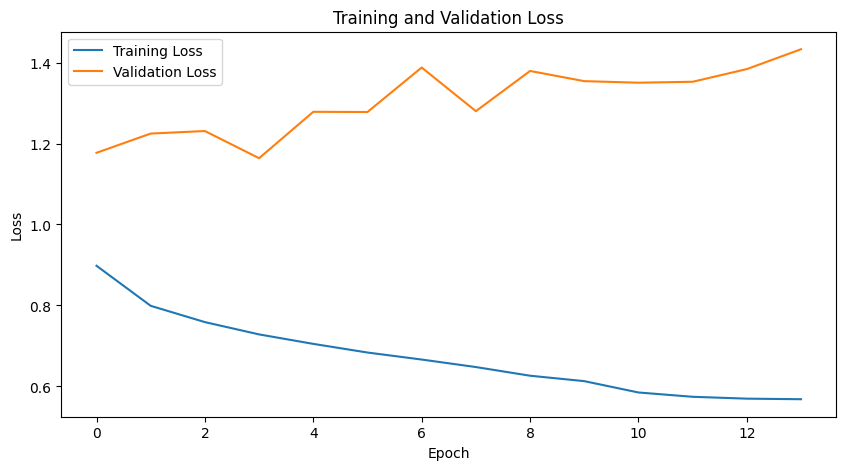

Test Loss: 1.2885
MAPE for PM: 16.21%
MAPE for PM_steam: 22.79%


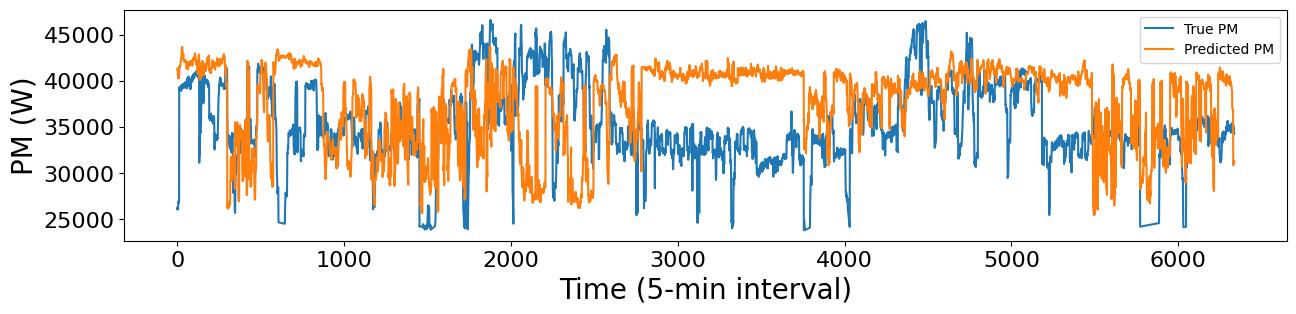

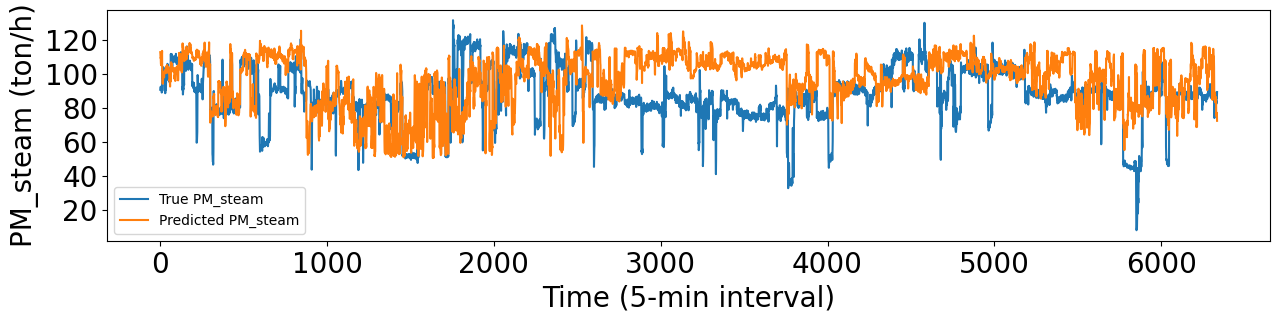

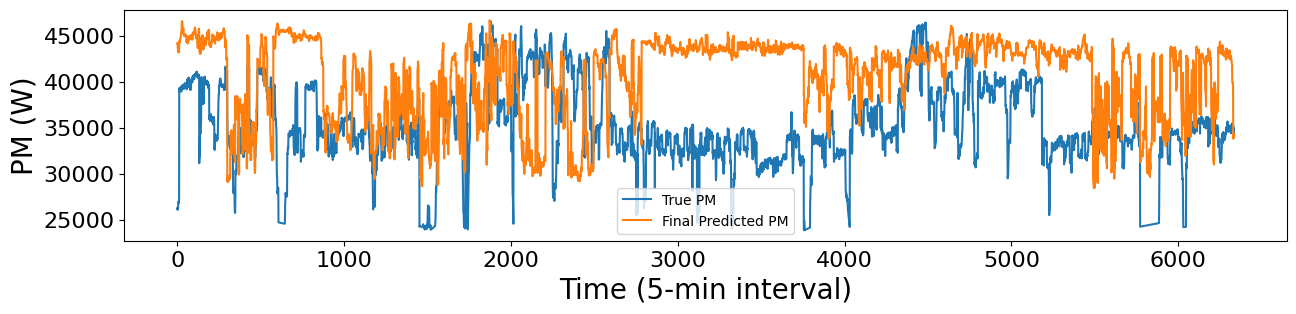

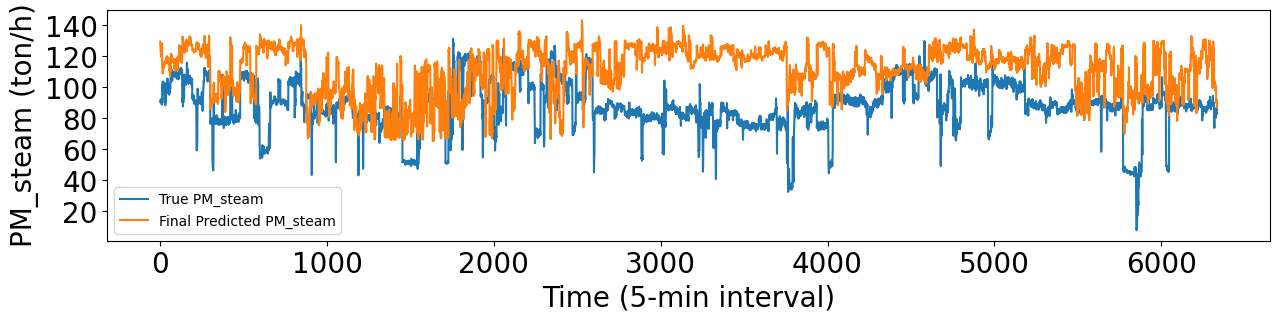

In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random
from statsmodels.tsa.arima.model import ARIMA

# Set seed for reproducibility
random.seed(100)
np.random.seed(100)
torch.manual_seed(100)
torch.cuda.manual_seed(100)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load and sort data
data = pd.read_csv('/Users/nguyendinhhuy/Desktop/Rolling/fortraining.csv')
data = data.sort_values(by='Time')

# Define features
encoder_features = ['PM_lw1','PM_lw2', 'PM_lw3', 'PM_lw4', 'PM_lw5', 'PM_lw6', 'PM_lw7','PM_s1', 'PM_s2', 'PM_s3', 'PM_s4', 'PM_s5', 'PM_s6', 'PM_s7',
                    'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month', 'hour', 'minute']
pm_features = ['PM_lw1', 'PM_lw2', 'PM_lw3', 'PM_lw4', 'PM_lw5', 'PM_lw6', 'PM_lw7', 'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month', 'hour', 'minute','PM_s1']
pm_steam_features = ['PM_s1', 'PM_s2', 'PM_s3', 'PM_s4', 'PM_s5', 'PM_s6', 'PM_s7', 'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month', 'hour', 'minute','PM_lw1']
y = data[['PM', 'PM_steam']].values

# Scale data
scaler_encoder = StandardScaler()
scaler_pm = StandardScaler()
scaler_pm_steam = StandardScaler()
scaler_y = StandardScaler()

X_encoder = scaler_encoder.fit_transform(data[encoder_features])
X_pm = scaler_pm.fit_transform(data[pm_features])
X_pm_steam = scaler_pm_steam.fit_transform(data[pm_steam_features])
y = scaler_y.fit_transform(y)

# Define dataset sizes
total_samples = len(data)
train_percentage = 0.8
val_percentage = 0.1
test_percentage = 0.1

train_size = int(total_samples * train_percentage)
val_size = int(total_samples * val_percentage)
test_size = total_samples - train_size - val_size

train_size -= train_size % 288
val_size -= val_size % 288
test_size -= test_size % 288

# Convert to tensor
X_encoder = torch.tensor(X_encoder, dtype=torch.float32)
X_pm = torch.tensor(X_pm, dtype=torch.float32)
X_pm_steam = torch.tensor(X_pm_steam, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Create TensorDataset
train_dataset = TensorDataset(X_encoder[:train_size], X_pm[:train_size], X_pm_steam[:train_size], y[:train_size])
val_dataset = TensorDataset(X_encoder[train_size:train_size + val_size], X_pm[train_size:train_size + val_size], X_pm_steam[train_size:train_size + val_size], y[train_size:train_size + val_size])
test_dataset = TensorDataset(X_encoder[-test_size:], X_pm[-test_size:], X_pm_steam[-test_size:], y[-test_size:])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define upgraded model with more layers and heads
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, nhead, dropout=0.1):
        super(Encoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.encoder(x)
        return self.norm(x)

class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, nhead, dropout=0.2):
        super(Decoder, self).__init__()
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)
        self.output_layer = nn.Linear(d_model, 1)

    def forward(self, memory, x):
        x = self.decoder(x, memory)
        x = self.norm(x)
        x = self.output_layer(x)
        return x

class MultiDeT(nn.Module):
    def __init__(self, encoder_layers=6, decoder_layers=6, d_model=128, nhead=16, dropout=0.3):
        super(MultiDeT, self).__init__()
        self.encoder = Encoder(encoder_layers, d_model=d_model, nhead=nhead, dropout=dropout)
        self.decoder1 = Decoder(decoder_layers, d_model=d_model, nhead=nhead, dropout=dropout)
        self.decoder2 = Decoder(decoder_layers, d_model=d_model, nhead=nhead, dropout=dropout)

        self.encoderLinear = nn.Sequential(
            nn.Linear(len(encoder_features), d_model),
            nn.BatchNorm1d(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.decoder1_Linear = nn.Sequential(
            nn.Linear(len(pm_features), d_model),
            nn.BatchNorm1d(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.decoder2_Linear = nn.Sequential(
            nn.Linear(len(pm_steam_features), d_model),
            nn.BatchNorm1d(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

    def forward(self, src, src_dec1, src_dec2):
        encoder_output = self.encoder(self.encoderLinear(src))

        decoder1_output = self.decoder1(encoder_output, self.decoder1_Linear(src_dec1))
        decoder2_output = self.decoder2(encoder_output, self.decoder2_Linear(src_dec2))

        return decoder1_output, decoder2_output

# Initialize model
model = MultiDeT()

# Define loss function and optimizer with weight decay
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-3)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, verbose=True)

# Train model with early stopping
def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100, patience=10):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_enc, X_pm, X_pm_steam, y in train_loader:
            optimizer.zero_grad()
            output1, output2 = model(X_enc, X_pm, X_pm_steam)

            output1 = output1.view(-1)
            output2 = output2.view(-1)

            loss1 = criterion(output1, y[:, 0])
            loss2 = criterion(output2, y[:, 1])

            loss = 0.8 * loss1 + 0.2 * loss2
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_enc.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_enc, X_pm, X_pm_steam, y in val_loader:
                output1, output2 = model(X_enc, X_pm, X_pm_steam)

                output1 = output1.view(-1)
                output2 = output2.view(-1)

                loss1 = criterion(output1, y[:, 0])
                loss2 = criterion(output2, y[:, 1])

                loss = 0.8 * loss1 + 0.2 * loss2
                val_loss += loss.item() * X_enc.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}')

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_wts = model.state_dict()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            model.load_state_dict(best_model_wts)
            break

    return train_losses, val_losses

# Train the model
train_losses, val_losses = train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100, patience=10)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Evaluate model
def evaluate_model(model, test_loader, criterion, scaler_y):
    model.eval()
    test_loss = 0.0
    true_values_pm = []
    true_values_pm_steam = []
    predicted_values_pm = []
    predicted_values_pm_steam = []

    with torch.no_grad():
        for X_enc, X_pm, X_pm_steam, y in test_loader:
            output1, output2 = model(X_enc, X_pm, X_pm_steam)

            output1 = output1.view(-1)
            output2 = output2.view(-1)

            loss1 = criterion(output1, y[:, 0])
            loss2 = criterion(output2, y[:, 1])
            loss = 0.8 * loss1 + 0.2 * loss2
            test_loss += loss.item() * X_enc.size(0)

            true_values_pm.extend(y[:, 0].cpu().numpy())
            true_values_pm_steam.extend(y[:, 1].cpu().numpy())
            predicted_values_pm.extend(output1.cpu().numpy())
            predicted_values_pm_steam.extend(output2.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')

    true_values_pm = np.array(true_values_pm)
    true_values_pm_steam = np.array(true_values_pm_steam)
    predicted_values_pm = np.array(predicted_values_pm)
    predicted_values_pm_steam = np.array(predicted_values_pm_steam)

    true_values = scaler_y.inverse_transform(np.vstack((true_values_pm, true_values_pm_steam)).T)
    predicted_values = scaler_y.inverse_transform(np.vstack((predicted_values_pm, predicted_values_pm_steam)).T)

    true_values_pm = true_values[:, 0]
    true_values_pm_steam = true_values[:, 1]
    predicted_values_pm = predicted_values[:, 0]
    predicted_values_pm_steam = predicted_values[:, 1]

    mape_pm = np.mean(np.abs((true_values_pm - predicted_values_pm) / true_values_pm)) * 100
    mape_pm_steam = np.mean(np.abs((true_values_pm_steam - predicted_values_pm_steam) / true_values_pm_steam)) * 100

    print(f'MAPE for PM: {mape_pm:.2f}%')
    print(f'MAPE for PM_steam: {mape_pm_steam:.2f}%')

    return true_values_pm, true_values_pm_steam, predicted_values_pm, predicted_values_pm_steam, mape_pm, mape_pm_steam

# Evaluate the model
true_values_pm, true_values_pm_steam, predicted_values_pm, predicted_values_pm_steam, mape_pm, mape_pm_steam = evaluate_model(model, test_loader, criterion, scaler_y)

# Plot predictions vs. true values for PM
plt.figure(figsize=(15, 3))
plt.plot(true_values_pm, label='True PM')
plt.plot(predicted_values_pm, label='Predicted PM')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel('Time (5-min interval)', fontsize=20)
plt.ylabel('PM (W)', fontsize=20)
plt.legend()
plt.show()

# Plot predictions vs. true values for PM_steam
plt.figure(figsize=(15, 3))
plt.plot(true_values_pm_steam, label='True PM_steam')
plt.plot(predicted_values_pm_steam, label='Predicted PM_steam')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Time (5-min interval)', fontsize=20)
plt.ylabel('PM_steam (ton/h)', fontsize=20)
plt.legend()
plt.show()

# Calculate residuals
residuals_pm = true_values_pm - predicted_values_pm
residuals_pm_steam = true_values_pm_steam - predicted_values_pm_steam

# Fit ARIMA model to residuals
arima_order = (5, 1, 0)  # Example order, you may need to tune this
arima_model_pm = ARIMA(residuals_pm, order=arima_order).fit()
arima_model_pm_steam = ARIMA(residuals_pm_steam, order=arima_order).fit()

# Forecast residuals using ARIMA
arima_forecast_pm = arima_model_pm.forecast(steps=len(residuals_pm))
arima_forecast_pm_steam = arima_model_pm_steam.forecast(steps=len(residuals_pm_steam))

# Combine predictions
final_predictions_pm = predicted_values_pm + arima_forecast_pm
final_predictions_pm_steam = predicted_values_pm_steam + arima_forecast_pm_steam

# Plot final predictions vs. true values for PM
plt.figure(figsize=(15, 3))
plt.plot(true_values_pm, label='True PM')
plt.plot(final_predictions_pm, label='Final Predicted PM')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel('Time (5-min interval)', fontsize=20)
plt.ylabel('PM (W)', fontsize=20)
plt.legend()
plt.show()

# Plot final predictions vs. true values for PM_steam
plt.figure(figsize=(15, 3))
plt.plot(true_values_pm_steam, label='True PM_steam')
plt.plot(final_predictions_pm_steam, label='Final Predicted PM_steam')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Time (5-min interval)', fontsize=20)
plt.ylabel('PM_steam (ton/h)', fontsize=20)
plt.legend()
plt.show()